### Exclude atoms farthur than 8A From Ligand

In [261]:
#negative_graph_48A:2~4A  + 4~8A
positivePDBDir = "../positive_truncated_data/"
positiveTarDir = "../positive_graph_save8A_test/"  # used for DGL output
negativePDBDir = "../negative_pdb/"
negativeTarDir = "../negative_graph_48A/"  # used for DGL output

In [233]:
def ligandCenter(pdbData):
    minX, minY, minZ = 99999.0, 99999.0, 99999.0
    maxX, maxY, maxZ = -99999.0, -99999.0, -99999.0
    for data in pdbData:
        if data[1] == 0:     # Ignore Protein Atoms
            continue
        minX = data[3] if data[3]<minX else minX
        minY = data[4] if data[4]<minY else minY
        minZ = data[5] if data[5]<minZ else minZ
        maxX = data[3] if data[3]>maxX else maxX
        maxY = data[4] if data[4]>maxY else maxY
        maxZ = data[5] if data[5]>maxZ else maxZ
    return minX, minY, minZ, maxX, maxY, maxZ

In [234]:
def fartherThan8A(ligandBox, atomPosition):
    x, y, z = atomPosition[0], atomPosition[1], atomPosition[2]
    minX, minY, minZ, maxX, maxY, maxZ = ligandBox
#     x_dis = x - minX
#     y_dis = y - minY
#     z_dis = z - minZ
#     disMin = math.sqrt(x_dis**2+y_dis**2+z_dis**2)
    
#     x_dis = x - maxX
#     y_dis = y - maxY
#     z_dis = z - maxZ
#     disMax = math.sqrt(x_dis**2+y_dis**2+z_dis**2)
    centerX, centerY, centerZ = (minX+maxX)/2, (minY+maxY)/2, (minZ+maxZ)/2
    disMin = math.sqrt((centerX-minX)**2+(centerY-minY)**2+(centerZ-minZ)**2)
    disMax = math.sqrt((centerX-maxX)**2+(centerY-maxY)**2+(centerZ-maxZ)**2)
    radius = disMin if disMin > disMax else disMax
    
    dis = math.sqrt((centerX-x)**2+(centerY-y)**2+(centerZ-z)**2)
    return (dis-radius)>8

In [235]:
from dgl.data import DGLDataset
import os
import numpy as np
import pandas as pd
import torch as th
import dgl
import json
import math

In [264]:
rmsdDf = pd.read_csv('../dock_rsmd.csv')
ligandRMSD48A = []
for i, row in rmsdDf.iterrows():
    if row[2] > 2 and row[2] <8:
        ligandRMSD48A.append(row[1])
len(ligandRMSD48A)

21778

In [267]:
receptorPDBQTDir = '/home/kmk_gmx/Desktop/bioinfo/receptor_dock/'  # receptor Dir (file name eg:5orh.pdbqt)
ligandPDBQTDir = '/home/kmk_gmx/Desktop/bioinfo/v2020_ligand_dock/'      # ligand Dir (file name eg:5orh.pdbqt)
dockingPDBQTDir = '/data/bilab/kaku/test_dockings_splited/'              # docking Dir (file name eg:5orh_ligand_3.pdbqt)
dockingPDBQTDir = '/home/kmk_gmx/Desktop/bioinfo/dockings/'
receptorPDBQTFiles = [i for i in os.listdir(receptorPDBQTDir)]
ligandPDBQTFiles = [i for i in os.listdir(ligandPDBQTDir)]
#dockingPDBQTFiles = os.listdir('/home/kmk_gmx/Desktop/bioinfo/negative_pdb/')
#dockingPDBQTFiles = os.listdir(dockingPDBQTDir)   # docking file name list(used in `getAllDocks()`)
dockingPDBQTFiles = []
for f in ligandRMSD48A:
    dockingPDBQTFiles.append(f + '.pdbqt')
len(dockingPDBQTFiles)

21778

In [237]:
def extractAtomLines(pdbqtLines):
    atomLines = []
    for line in pdbqtLines:
        l = line.strip()
        if l[:4] != 'ATOM':
            continue
        pdbqtCols = []
        pdbqtCols.append(l[0:6].strip())
        pdbqtCols.append(l[6:11].strip())
        pdbqtCols.append(l[12:16].strip())
        pdbqtCols.append(l[16:17].strip())
        pdbqtCols.append(l[17:21].strip())
        pdbqtCols.append(l[21:22].strip())
        pdbqtCols.append(l[22:26].strip())
        pdbqtCols.append(l[26:27].strip())
        pdbqtCols.append(l[30:38].strip())
        pdbqtCols.append(l[38:46].strip())
        pdbqtCols.append(l[46:54].strip())
        pdbqtCols.append(l[54:60].strip())
        pdbqtCols.append(l[60:66].strip())
        pdbqtCols.append(l[66:76].strip())
        pdbqtCols.append(l[76:].strip())
        if pdbqtCols[PDBQT_TYPE_INDEX].upper() not in ELEMENT_TYPE:
            continue
        atomLines.append(pdbqtCols)
    return atomLines

In [238]:
def getAllDocks(recepName):
    docks = []
    dockNames = []
    for dockFileName in dockingPDBQTFiles:
        if recepName in dockFileName:
            dockFile = open(dockingPDBQTDir + dockFileName + 'qt')
            dockLines = extractAtomLines(dockFile.readlines())
            docks.append(dockLines)
            dockNames.append(dockFileName[:-4])
    return docks, dockNames

In [266]:
# specified for test dataset
def getAllTestDocks(recepName):
    docks = []
    dockNames = []
    for dockFileName in dockingPDBQTFiles:
        if recepName in dockFileName:
            dockFile = open(dockingPDBQTDir + dockFileName)
            dockLines = extractAtomLines(dockFile.readlines())
            docks.append(dockLines)
            dockNames.append(dockFileName[:-6])
    return docks, dockNames

In [239]:
PDBQT_X_POS_INDEX = 8
PDBQT_Y_POS_INDEX = 9
PDBQT_Z_POS_INDEX = 10
PDBQT_TYPE_INDEX  = 14
ELEMENT_TYPE = ['H', 'HD', 'HS', 'C', 'A', 'N', 'NA', 'NS', 'OA', 'OS', 'F', 'MG', 'P', 'SA', 'S', 'CL', 'CA', 'MN', 'FE', 'ZN', 'BR', 'I']
RECEP_ELEMENT_ONEHOT = {}
LIG_ELEMENT_ONEHOT = {}
for idx, ele in enumerate(ELEMENT_TYPE):
    RECEP_ELEMENT_ONEHOT[ele] = [0]*len(ELEMENT_TYPE)*2
    RECEP_ELEMENT_ONEHOT[ele][idx] = 1
for idx, ele in enumerate(ELEMENT_TYPE):
    LIG_ELEMENT_ONEHOT[ele] = [0]*len(ELEMENT_TYPE)*2
    LIG_ELEMENT_ONEHOT[ele][idx+len(ELEMENT_TYPE)] = 1

In [142]:
s = '      '
s.strip()

''

In [240]:
def distanceIn2Atoms(atom1, atom2):
    atom1x = float(atom1[PDBQT_X_POS_INDEX])
    atom1y = float(atom1[PDBQT_Y_POS_INDEX])
    atom1z = float(atom1[PDBQT_Z_POS_INDEX])
    atom2x = float(atom2[PDBQT_X_POS_INDEX])
    atom2y = float(atom2[PDBQT_Y_POS_INDEX])
    atom2z = float(atom2[PDBQT_Z_POS_INDEX])
    return math.sqrt((atom1x-atom2x)**2 + (atom1y-atom2y)**2 + (atom1z-atom2z)**2)

In [241]:
def distancesFromLigand(atom, ligand):
    atomx = float(atom[PDBQT_X_POS_INDEX])
    atomy = float(atom[PDBQT_Y_POS_INDEX])
    atomz = float(atom[PDBQT_Z_POS_INDEX])
    distances = []
    for a in ligand:
        ax = float(a[PDBQT_X_POS_INDEX])
        ay = float(a[PDBQT_Y_POS_INDEX])
        az = float(a[PDBQT_Z_POS_INDEX])
        dist = math.sqrt((atomx-ax)**2 + (atomy-ay)**2 + (atomz-az)**2)
        distances.append(dist)
    return distances

In [242]:
def minDisFromLigand(atom, ligand):
    distances = distancesFromLigand(atom, ligand)
    return min(distances)

In [129]:
a = [1,2,3,4,5]
b = [8,7,8,5]
a = [i+1 for i in a]
a

[2, 3, 4, 5, 6]

In [243]:
def generateDGL(receptor, ligand, name):
    u_set = []
    v_set = []
    graph_ndata = []
    graph_edata = [] #edge weights
    for atom in receptor:
        if atom[PDBQT_TYPE_INDEX].upper() not in RECEP_ELEMENT_ONEHOT:
            print(atom[PDBQT_TYPE_INDEX])
        #print(atom)
        graph_ndata.append([RECEP_ELEMENT_ONEHOT[atom[PDBQT_TYPE_INDEX].upper()]])
    for atom in ligand:
        if atom[PDBQT_TYPE_INDEX].upper() not in RECEP_ELEMENT_ONEHOT:
            print(atom[PDBQT_TYPE_INDEX])
        graph_ndata.append([LIG_ELEMENT_ONEHOT[atom[PDBQT_TYPE_INDEX].upper()]]) 
        
    for i, atomI in enumerate(receptor + ligand):
        ligI  = False if i < len(receptor) else True  # whether it's a ligand atom
        for j, atomJ in enumerate(receptor + ligand):
            ligJ  = False if j < len(receptor) else True
            dis = distanceIn2Atoms(atomI, atomJ)
            if dis < 2.0 and ligI == ligJ:
                graph_edata.append([1])
                u_set.append(i)
                v_set.append(j)
            elif dis < 5.0 and ligI != ligJ:
                graph_edata.append([dis])
                u_set.append(i)
                v_set.append(j)
    g = dgl.DGLGraph()
    g.add_nodes(len(graph_ndata))
    g.add_edges(u_set, v_set)
    print(name, len(graph_ndata), len(graph_edata), len(graph_ndata), len(u_set), len(v_set))
    g.edata['h'] = th.tensor(graph_edata)
    g.ndata['h'] = th.tensor(graph_ndata)

    dgl.save_graphs(name, [g])

In [244]:
def generatePosiDGL(recep, lig, name):
    recepAtomIn8 = []
    for atom in recep:
        if minDisFromLigand(atom, lig) > 8:
            continue
        recepAtomIn8.append(atom)
    generateDGL(recepAtomIn8, lig, positiveTarDir + name)


In [245]:
def generateNegaDGL(recep, docks, dockNames):
    if len(docks) == 0:
        return
    for i, dock in enumerate(docks):
        recepAtomIn8 = []
        for atom in recep:
            if minDisFromLigand(atom, dock)>8:
                continue
            recepAtomIn8.append(atom)
        generateDGL(recepAtomIn8, dock, negativeTarDir + dockNames[i])

In [230]:
for name in receptorPDBQTFiles:
    recepFile = open(receptorPDBQTDir + name)
    ligFile   = open(ligandPDBQTDir + name)
    recep = extractAtomLines(recepFile.readlines())
    lig   = extractAtomLines(ligFile.readlines())
    docks, dockNames = getAllDocks(name[:4])

    generatePosiDGL(recep, lig, name[:4])
    generateNegaDGL(recep, docks, dockNames)
    
    # print(name[:4], len(docks))
    ligFile.close()
    recepFile.close()

../positive_graph_save8A/6dil 505 3057 505 3057 3057
../positive_graph_save8A/3d8z 242 1508 242 1508 1508
../negative_graph_save8A/3d8z_ligand_4 266 1786 266 1786 1786
../positive_graph_save8A/3el5 551 3321 551 3321 3321
../negative_graph_save8A/3el5_ligand_3 536 3144 536 3144 3144
../positive_graph_save8A/6gl9 390 2280 390 2280 2280
../negative_graph_save8A/6gl9_ligand_2 356 1984 356 1984 1984
../positive_graph_save8A/4ahs 266 1424 266 1424 1424
../negative_graph_save8A/4ahs_ligand_4 258 1350 258 1350 1350
../negative_graph_save8A/4ahs_ligand_5 269 1431 269 1431 1431
../negative_graph_save8A/4ahs_ligand_7 261 1367 261 1367 1367
../negative_graph_save8A/4ahs_ligand_1 267 1399 267 1399 1399
../negative_graph_save8A/4ahs_ligand_3 245 1299 245 1299 1299
../positive_graph_save8A/5lvq 251 1385 251 1385 1385
../negative_graph_save8A/5lvq_ligand_2 233 1319 233 1319 1319
../positive_graph_save8A/3c4h 252 1386 252 1386 1386
../negative_graph_save8A/3c4h_ligand_4 262 1378 262 1378 1378
../negati

../positive_graph_save8A/4lm0 235 1021 235 1021 1021
../negative_graph_save8A/4lm0_ligand_4 227 1051 227 1051 1051
../negative_graph_save8A/4lm0_ligand_2 228 1068 228 1068 1068
../negative_graph_save8A/4lm0_ligand_9 234 1074 234 1074 1074
../negative_graph_save8A/4lm0_ligand_7 247 1161 247 1161 1161
../positive_graph_save8A/2zkj 429 2945 429 2945 2945
../negative_graph_save8A/2zkj_ligand_4 422 2848 422 2848 2848
../negative_graph_save8A/2zkj_ligand_2 437 2949 437 2949 2949
../negative_graph_save8A/2zkj_ligand_3 443 2945 443 2945 2945
../positive_graph_save8A/2zcr 456 2512 456 2512 2512
../negative_graph_save8A/2zcr_ligand_1 458 2478 458 2478 2478
../negative_graph_save8A/2zcr_ligand_3 452 2474 452 2474 2474
../negative_graph_save8A/2zcr_ligand_2 463 2535 463 2535 2535
../positive_graph_save8A/5cc2 271 1527 271 1527 1527
../negative_graph_save8A/5cc2_ligand_2 266 1422 266 1422 1422
../positive_graph_save8A/4mc9 533 3155 533 3155 3155
../negative_graph_save8A/4mc9_ligand_6 491 2907 491 2

../negative_graph_save8A/6gfs_ligand_7 304 1226 304 1226 1226
../negative_graph_save8A/6gfs_ligand_9 302 1198 302 1198 1198
../negative_graph_save8A/6gfs_ligand_4 313 1289 313 1289 1289
../positive_graph_save8A/3nee 350 1736 350 1736 1736
../negative_graph_save8A/3nee_ligand_5 362 1780 362 1780 1780
../negative_graph_save8A/3nee_ligand_7 348 1762 348 1762 1762
../negative_graph_save8A/3nee_ligand_8 349 1713 349 1713 1713
../negative_graph_save8A/3nee_ligand_9 348 1752 348 1752 1752
../positive_graph_save8A/1g45 314 1672 314 1672 1672
../negative_graph_save8A/1g45_ligand_4 349 1747 349 1747 1747
../negative_graph_save8A/1g45_ligand_2 340 1718 340 1718 1718
../negative_graph_save8A/1g45_ligand_5 361 1847 361 1847 1847
../negative_graph_save8A/1g45_ligand_1 343 1763 343 1763 1763
../negative_graph_save8A/1g45_ligand_6 317 1683 317 1683 1683
../negative_graph_save8A/1g45_ligand_7 322 1686 322 1686 1686
../negative_graph_save8A/1g45_ligand_9 336 1668 336 1668 1668
../negative_graph_save8A/1

../positive_graph_save8A/5sz6 324 1826 324 1826 1826
../negative_graph_save8A/5sz6_ligand_8 303 1617 303 1617 1617
../negative_graph_save8A/5sz6_ligand_3 332 1762 332 1762 1762
../positive_graph_save8A/5j27 431 2533 431 2533 2533
../negative_graph_save8A/5j27_ligand_6 417 2453 417 2453 2453
../positive_graph_save8A/2yhw 396 2488 396 2488 2488
../positive_graph_save8A/1w3k 418 2854 418 2854 2854
../negative_graph_save8A/1w3k_ligand_2 409 2821 409 2821 2821
../positive_graph_save8A/2qe4 350 1678 350 1678 1678
../negative_graph_save8A/2qe4_ligand_2 341 1697 341 1697 1697
../positive_graph_save8A/4v24 510 2530 510 2530 2530
../negative_graph_save8A/4v24_ligand_9 499 2539 499 2539 2539
../negative_graph_save8A/4v24_ligand_7 510 2574 510 2574 2574
../positive_graph_save8A/3r4m 340 2046 340 2046 2046
../negative_graph_save8A/3r4m_ligand_2 366 2104 366 2104 2104
../negative_graph_save8A/3r4m_ligand_3 340 2064 340 2064 2064
../negative_graph_save8A/3r4m_ligand_9 331 1941 331 1941 1941
../negati

../positive_graph_save8A/3hku 369 2135 369 2135 2135
../positive_graph_save8A/3l0v 303 1765 303 1765 1765
../negative_graph_save8A/3l0v_ligand_2 289 1649 289 1649 1649
../negative_graph_save8A/3l0v_ligand_3 285 1529 285 1529 1529
../negative_graph_save8A/3l0v_ligand_4 296 1576 296 1576 1576
../positive_graph_save8A/4nxu 429 2693 429 2693 2693
../positive_graph_save8A/2g5u 316 1430 316 1430 1430
../negative_graph_save8A/2g5u_ligand_4 321 1461 321 1461 1461
../negative_graph_save8A/2g5u_ligand_1 321 1469 321 1469 1469
../negative_graph_save8A/2g5u_ligand_8 317 1441 317 1441 1441
../positive_graph_save8A/6cdp 447 2691 447 2691 2691
../positive_graph_save8A/4qgi 538 3598 538 3598 3598
../positive_graph_save8A/4do5 336 2116 336 2116 2116
../negative_graph_save8A/4do5_ligand_3 310 1930 310 1930 1930
../positive_graph_save8A/1y0l 317 1667 317 1667 1667
../negative_graph_save8A/1y0l_ligand_4 280 1506 280 1506 1506
../negative_graph_save8A/1y0l_ligand_8 280 1398 280 1398 1398
../negative_graph_

../negative_graph_save8A/4knn_ligand_1 353 1853 353 1853 1853
../negative_graph_save8A/4knn_ligand_3 349 1825 349 1825 1825
../positive_graph_save8A/2qi7 468 2760 468 2760 2760
../negative_graph_save8A/2qi7_ligand_2 480 2582 480 2582 2582
../negative_graph_save8A/2qi7_ligand_3 471 2663 471 2663 2663
../positive_graph_save8A/1owh 357 2389 357 2389 2389
../negative_graph_save8A/1owh_ligand_3 372 2492 372 2492 2492
../negative_graph_save8A/1owh_ligand_7 344 2156 344 2156 2156
../positive_graph_save8A/1mq5 427 2727 427 2727 2727
../positive_graph_save8A/3bv9 507 3659 507 3659 3659
../negative_graph_save8A/3bv9_ligand_3 492 3300 492 3300 3300
../negative_graph_save8A/3bv9_ligand_7 466 3304 466 3304 3304
../negative_graph_save8A/3bv9_ligand_2 474 3406 474 3406 3406
../positive_graph_save8A/4xoc 338 2062 338 2062 2062
../negative_graph_save8A/4xoc_ligand_4 333 1981 333 1981 1981
../positive_graph_save8A/2amt 457 2791 457 2791 2791
../positive_graph_save8A/2j62 465 2777 465 2777 2777
../positi

../positive_graph_save8A/4cpt 531 3483 531 3483 3483
../positive_graph_save8A/1ydr 348 1732 348 1732 1732
../negative_graph_save8A/1ydr_ligand_7 342 1726 342 1726 1726
../negative_graph_save8A/1ydr_ligand_3 344 1684 344 1684 1684
../negative_graph_save8A/1ydr_ligand_4 343 1699 343 1699 1699
../negative_graph_save8A/1ydr_ligand_5 335 1621 335 1621 1621
../positive_graph_save8A/2vk2 374 2252 374 2252 2252
../negative_graph_save8A/2vk2_ligand_3 377 2239 377 2239 2239
../positive_graph_save8A/6guh 378 2142 378 2142 2142
../negative_graph_save8A/6guh_ligand_7 374 2044 374 2044 2044
../negative_graph_save8A/6guh_ligand_4 345 1915 345 1915 1915
../positive_graph_save8A/5uoo 314 1714 314 1714 1714
../negative_graph_save8A/5uoo_ligand_2 310 1656 310 1656 1656
../positive_graph_save8A/1dar 288 2050 288 2050 2050
../negative_graph_save8A/1dar_ligand_5 268 1838 268 1838 1838
../negative_graph_save8A/1dar_ligand_3 268 1748 268 1748 1748
../negative_graph_save8A/1dar_ligand_2 269 1873 269 1873 1873


../negative_graph_save8A/3f3e_ligand_3 297 1497 297 1497 1497
../negative_graph_save8A/3f3e_ligand_2 297 1469 297 1469 1469
../positive_graph_save8A/2tmn 274 1564 274 1564 1564
../negative_graph_save8A/2tmn_ligand_6 260 1558 260 1558 1558
../negative_graph_save8A/2tmn_ligand_4 268 1526 268 1526 1526
../negative_graph_save8A/2tmn_ligand_2 276 1446 276 1446 1446
../negative_graph_save8A/2tmn_ligand_3 292 1514 292 1514 1514
../positive_graph_save8A/4jfs 286 1658 286 1658 1658
../negative_graph_save8A/4jfs_ligand_5 270 1492 270 1492 1492
../negative_graph_save8A/4jfs_ligand_9 267 1435 267 1435 1435
../positive_graph_save8A/1lpk 482 3234 482 3234 3234
../positive_graph_save8A/4jz1 465 2981 465 2981 2981
../negative_graph_save8A/4jz1_ligand_8 428 2566 428 2566 2566
../positive_graph_save8A/2j75 344 2112 344 2112 2112
../negative_graph_save8A/2j75_ligand_6 337 2069 337 2069 2069
../negative_graph_save8A/2j75_ligand_2 336 2084 336 2084 2084
../negative_graph_save8A/2j75_ligand_4 343 2117 343 2

../positive_graph_save8A/4ufk 274 1612 274 1612 1612
../negative_graph_save8A/4ufk_ligand_2 244 1456 244 1456 1456
../positive_graph_save8A/1m1b 276 1466 276 1466 1466
../negative_graph_save8A/1m1b_ligand_9 281 1403 281 1403 1403
../negative_graph_save8A/1m1b_ligand_2 277 1413 277 1413 1413
../negative_graph_save8A/1m1b_ligand_4 275 1415 275 1415 1415
../negative_graph_save8A/1m1b_ligand_8 278 1336 278 1336 1336
../negative_graph_save8A/1m1b_ligand_7 272 1400 272 1400 1400
../negative_graph_save8A/1m1b_ligand_6 269 1319 269 1319 1319
../positive_graph_save8A/2c92 544 3808 544 3808 3808
../negative_graph_save8A/2c92_ligand_3 505 3465 505 3465 3465
../positive_graph_save8A/1siv 440 2834 440 2834 2834
../positive_graph_save8A/1h2k 297 1377 297 1377 1377
../negative_graph_save8A/1h2k_ligand_4 300 1374 300 1374 1374
../negative_graph_save8A/1h2k_ligand_6 275 1313 275 1313 1313
../negative_graph_save8A/1h2k_ligand_7 289 1345 289 1345 1345
../negative_graph_save8A/1h2k_ligand_8 287 1341 287 1

../negative_graph_save8A/4n6g_ligand_5 160 988 160 988 988
../positive_graph_save8A/1sdv 552 3634 552 3634 3634
../positive_graph_save8A/4dkq 366 2220 366 2220 2220
../positive_graph_save8A/1pgp 332 2000 332 2000 2000
../negative_graph_save8A/1pgp_ligand_5 345 2047 345 2047 2047
../negative_graph_save8A/1pgp_ligand_2 325 1945 325 1945 1945
../negative_graph_save8A/1pgp_ligand_1 339 2037 339 2037 2037
../negative_graph_save8A/1pgp_ligand_4 323 1931 323 1931 1931
../negative_graph_save8A/1pgp_ligand_8 328 1982 328 1982 1982
../positive_graph_save8A/1i9p 339 1773 339 1773 1773
../negative_graph_save8A/1i9p_ligand_2 328 1738 328 1738 1738
../negative_graph_save8A/1i9p_ligand_8 332 1744 332 1744 1744
../negative_graph_save8A/1i9p_ligand_1 333 1765 333 1765 1765
../negative_graph_save8A/1i9p_ligand_3 321 1713 321 1713 1713
../negative_graph_save8A/1i9p_ligand_4 310 1634 310 1634 1634
../positive_graph_save8A/1o35 331 2453 331 2453 2453
../negative_graph_save8A/1o35_ligand_2 336 2306 336 2306

../positive_graph_save8A/1ndv 458 3036 458 3036 3036
../negative_graph_save8A/1ndv_ligand_4 472 3008 472 3008 3008
../positive_graph_save8A/4cig 324 2016 324 2016 2016
../negative_graph_save8A/4cig_ligand_4 330 1926 330 1926 1926
../positive_graph_save8A/3o9p 601 3929 601 3929 3929
../negative_graph_save8A/3o9p_ligand_6 558 3622 558 3622 3622
../negative_graph_save8A/3o9p_ligand_4 575 3749 575 3749 3749
../positive_graph_save8A/1yp9 364 2408 364 2408 2408
../negative_graph_save8A/1yp9_ligand_2 329 1989 329 1989 1989
../negative_graph_save8A/1yp9_ligand_4 325 1979 325 1979 1979
../negative_graph_save8A/1yp9_ligand_1 331 2083 331 2083 2083
../negative_graph_save8A/1yp9_ligand_7 308 1706 308 1706 1706
../negative_graph_save8A/1yp9_ligand_3 323 1797 323 1797 1797
../negative_graph_save8A/1yp9_ligand_5 307 1851 307 1851 1851
../positive_graph_save8A/6ekq 317 1977 317 1977 1977
../positive_graph_save8A/4qfl 379 2143 379 2143 2143
../negative_graph_save8A/4qfl_ligand_8 390 2120 390 2120 2120


../positive_graph_save8A/1o5a 380 2788 380 2788 2788
../positive_graph_save8A/4lm4 231 1101 231 1101 1101
../negative_graph_save8A/4lm4_ligand_8 226 1008 226 1008 1008
../negative_graph_save8A/4lm4_ligand_3 238 1146 238 1146 1146
../negative_graph_save8A/4lm4_ligand_9 221 1005 221 1005 1005
../negative_graph_save8A/4lm4_ligand_2 237 1151 237 1151 1151
../negative_graph_save8A/4lm4_ligand_7 228 1072 228 1072 1072
../negative_graph_save8A/4lm4_ligand_5 230 1076 230 1076 1076
../positive_graph_save8A/5l4i 308 1436 308 1436 1436
../negative_graph_save8A/5l4i_ligand_6 318 1444 318 1444 1444
../negative_graph_save8A/5l4i_ligand_7 319 1467 319 1467 1467
../negative_graph_save8A/5l4i_ligand_8 301 1475 301 1475 1475
../negative_graph_save8A/5l4i_ligand_1 311 1433 311 1433 1433
../negative_graph_save8A/5l4i_ligand_9 304 1438 304 1438 1438
../negative_graph_save8A/5l4i_ligand_5 312 1466 312 1466 1466
../positive_graph_save8A/5i29 331 1927 331 1927 1927
../negative_graph_save8A/5i29_ligand_5 325 1

../negative_graph_save8A/1xk9_ligand_5 326 1872 326 1872 1872
../negative_graph_save8A/1xk9_ligand_1 322 1814 322 1814 1814
../positive_graph_save8A/5o1h 280 1606 280 1606 1606
../positive_graph_save8A/5nka 391 2313 391 2313 2313
../negative_graph_save8A/5nka_ligand_6 395 2273 395 2273 2273
../positive_graph_save8A/1b6k 483 3111 483 3111 3111
../positive_graph_save8A/4euo 314 1662 314 1662 1662
../negative_graph_save8A/4euo_ligand_9 299 1547 299 1547 1547
../negative_graph_save8A/4euo_ligand_5 300 1616 300 1616 1616
../negative_graph_save8A/4euo_ligand_4 307 1585 307 1585 1585
../positive_graph_save8A/2weo 270 1328 270 1328 1328
../negative_graph_save8A/2weo_ligand_3 264 1244 264 1244 1244
../negative_graph_save8A/2weo_ligand_8 287 1329 287 1329 1329
../positive_graph_save8A/3fat 336 2048 336 2048 2048
../negative_graph_save8A/3fat_ligand_2 339 2031 339 2031 2031
../positive_graph_save8A/5mmg 355 1985 355 1985 1985
../negative_graph_save8A/5mmg_ligand_8 295 1673 295 1673 1673
../negati

../positive_graph_save8A/6dai 331 1621 331 1621 1621
../positive_graph_save8A/2pou 386 2154 386 2154 2154
../negative_graph_save8A/2pou_ligand_6 379 2065 379 2065 2065
../negative_graph_save8A/2pou_ligand_3 371 2027 371 2027 2027
../negative_graph_save8A/2pou_ligand_1 389 2203 389 2203 2203
../positive_graph_save8A/3eax 302 1546 302 1546 1546
../positive_graph_save8A/2a5s 323 2003 323 2003 2003
../negative_graph_save8A/2a5s_ligand_3 315 1979 315 1979 1979
../negative_graph_save8A/2a5s_ligand_4 317 1981 317 1981 1981
../negative_graph_save8A/2a5s_ligand_9 309 1919 309 1919 1919
../positive_graph_save8A/3wtj 308 1568 308 1568 1568
../negative_graph_save8A/3wtj_ligand_4 324 1570 324 1570 1570
../negative_graph_save8A/3wtj_ligand_9 315 1559 315 1559 1559
../positive_graph_save8A/3p5l 277 1321 277 1321 1321
../negative_graph_save8A/3p5l_ligand_9 253 1123 253 1123 1123
../negative_graph_save8A/3p5l_ligand_7 261 1271 261 1271 1271
../positive_graph_save8A/5e2s 353 2255 353 2255 2255
../positi

../positive_graph_save8A/3egt 507 2861 507 2861 2861
../positive_graph_save8A/3hmp 229 1145 229 1145 1145
../positive_graph_save8A/3n0n 343 1919 343 1919 1919
../negative_graph_save8A/3n0n_ligand_3 348 1920 348 1920 1920
../negative_graph_save8A/3n0n_ligand_6 339 1809 339 1809 1809
../negative_graph_save8A/3n0n_ligand_9 335 1781 335 1781 1781
../negative_graph_save8A/3n0n_ligand_7 370 1968 370 1968 1968
../positive_graph_save8A/3t0d 366 2194 366 2194 2194
../negative_graph_save8A/3t0d_ligand_5 363 2153 363 2153 2153
../negative_graph_save8A/3t0d_ligand_4 335 1893 335 1893 1893
../negative_graph_save8A/3t0d_ligand_7 353 2043 353 2043 2043
../positive_graph_save8A/3q2j 309 1583 309 1583 1583
../negative_graph_save8A/3q2j_ligand_5 289 1483 289 1483 1483
../negative_graph_save8A/3q2j_ligand_1 292 1564 292 1564 1564
../positive_graph_save8A/6fng 490 2912 490 2912 2912
../positive_graph_save8A/5dqc 575 3875 575 3875 3875
../positive_graph_save8A/5e2o 464 3144 464 3144 3144
../positive_graph_

../negative_graph_save8A/3fvn_ligand_5 339 2095 339 2095 2095
../negative_graph_save8A/3fvn_ligand_2 338 2146 338 2146 2146
../negative_graph_save8A/3fvn_ligand_4 339 2079 339 2079 2079
../positive_graph_save8A/5g60 577 4301 577 4301 4301
../negative_graph_save8A/5g60_ligand_7 598 4458 598 4458 4458
../negative_graph_save8A/5g60_ligand_1 591 4497 591 4497 4497
../negative_graph_save8A/5g60_ligand_3 585 4313 585 4313 4313
../positive_graph_save8A/6hqy 280 1570 280 1570 1570
../negative_graph_save8A/6hqy_ligand_1 269 1407 269 1407 1407
../negative_graph_save8A/6hqy_ligand_4 246 1330 246 1330 1330
../negative_graph_save8A/6hqy_ligand_5 239 1171 239 1171 1171
../positive_graph_save8A/2qbr 394 2262 394 2262 2262
../positive_graph_save8A/4kz6 313 1539 313 1539 1539
../negative_graph_save8A/4kz6_ligand_8 264 1246 264 1246 1246
../negative_graph_save8A/4kz6_ligand_2 300 1466 300 1466 1466
../negative_graph_save8A/4kz6_ligand_5 267 1305 267 1305 1305
../negative_graph_save8A/4kz6_ligand_4 287 1

../negative_graph_save8A/6gnp_ligand_9 196 804 196 804 804
../positive_graph_save8A/1i5r 780 5028 780 5028 5028
../positive_graph_save8A/3ai8 252 1438 252 1438 1438
../negative_graph_save8A/3ai8_ligand_6 225 1133 225 1133 1133
../negative_graph_save8A/3ai8_ligand_7 225 1211 225 1211 1211
../negative_graph_save8A/3ai8_ligand_5 227 1187 227 1187 1187
../negative_graph_save8A/3ai8_ligand_1 225 1169 225 1169 1169
../negative_graph_save8A/3ai8_ligand_4 224 1156 224 1156 1156
../positive_graph_save8A/1g3d 294 1968 294 1968 1968
../negative_graph_save8A/1g3d_ligand_6 272 1652 272 1652 1652
../negative_graph_save8A/1g3d_ligand_4 270 1778 270 1778 1778
../negative_graph_save8A/1g3d_ligand_5 263 1749 263 1749 1749
../negative_graph_save8A/1g3d_ligand_3 301 2007 301 2007 2007
../positive_graph_save8A/4c52 379 1891 379 1891 1891
../negative_graph_save8A/4c52_ligand_8 326 1566 326 1566 1566
../negative_graph_save8A/4c52_ligand_9 340 1658 340 1658 1658
../negative_graph_save8A/4c52_ligand_6 365 1879

../negative_graph_save8A/5vyy_ligand_2 413 2337 413 2337 2337
../negative_graph_save8A/5vyy_ligand_3 418 2390 418 2390 2390
../positive_graph_save8A/3tza 416 2706 416 2706 2706
../negative_graph_save8A/3tza_ligand_4 425 2757 425 2757 2757
../positive_graph_save8A/3d51 370 2318 370 2318 2318
../positive_graph_save8A/2c1p 363 1907 363 1907 1907
../positive_graph_save8A/5ta2 395 2561 395 2561 2561
../positive_graph_save8A/2fpz 275 1729 275 1729 1729
../negative_graph_save8A/2fpz_ligand_1 270 1728 270 1728 1728
../positive_graph_save8A/4aqh 338 1962 338 1962 1962
../positive_graph_save8A/4zvi 293 1581 293 1581 1581
../negative_graph_save8A/4zvi_ligand_3 283 1559 283 1559 1559
../negative_graph_save8A/4zvi_ligand_6 296 1660 296 1660 1660
../negative_graph_save8A/4zvi_ligand_4 282 1568 282 1568 1568
../negative_graph_save8A/4zvi_ligand_1 285 1589 285 1589 1589
../positive_graph_save8A/3mmf 355 2033 355 2033 2033
../negative_graph_save8A/3mmf_ligand_2 356 1938 356 1938 1938
../positive_graph_

../positive_graph_save8A/5nk3 372 2038 372 2038 2038
../negative_graph_save8A/5nk3_ligand_7 361 2029 361 2029 2029
../negative_graph_save8A/5nk3_ligand_6 347 1877 347 1877 1877
../negative_graph_save8A/5nk3_ligand_1 387 2179 387 2179 2179
../positive_graph_save8A/1b38 451 2703 451 2703 2703
../negative_graph_save8A/1b38_ligand_3 456 2710 456 2710 2710
../negative_graph_save8A/1b38_ligand_1 430 2616 430 2616 2616
../negative_graph_save8A/1b38_ligand_7 425 2521 425 2521 2521
../positive_graph_save8A/6edr 387 2275 387 2275 2275
../positive_graph_save8A/2vc9 354 2126 354 2126 2126
../negative_graph_save8A/2vc9_ligand_2 354 2100 354 2100 2100
../positive_graph_save8A/6eq8 460 3128 460 3128 3128
../negative_graph_save8A/6eq8_ligand_9 472 2898 472 2898 2898
../positive_graph_save8A/2pog 343 1611 343 1611 1611
../negative_graph_save8A/2pog_ligand_2 337 1631 337 1631 1631
../positive_graph_save8A/3zi0 331 1885 331 1885 1885
../negative_graph_save8A/3zi0_ligand_1 345 1945 345 1945 1945
../negati

../negative_graph_save8A/4mc6_ligand_2 537 3109 537 3109 3109
../positive_graph_save8A/5ivy 360 2048 360 2048 2048
../negative_graph_save8A/5ivy_ligand_8 345 2021 345 2021 2021
../positive_graph_save8A/4hdp 549 3395 549 3395 3395
../negative_graph_save8A/4hdp_ligand_4 545 3297 545 3297 3297
../negative_graph_save8A/4hdp_ligand_2 532 3222 532 3222 3222
../positive_graph_save8A/1njd 357 2131 357 2131 2131
../negative_graph_save8A/1njd_ligand_4 329 1619 329 1619 1619
../positive_graph_save8A/4ca7 708 4582 708 4582 4582
../positive_graph_save8A/3c79 271 1517 271 1517 1517
../negative_graph_save8A/3c79_ligand_3 307 1619 307 1619 1619
../negative_graph_save8A/3c79_ligand_4 307 1585 307 1585 1585
../positive_graph_save8A/6fo5 374 2318 374 2318 2318
../negative_graph_save8A/6fo5_ligand_6 337 1993 337 1993 1993
../negative_graph_save8A/6fo5_ligand_8 334 1952 334 1952 1952
../negative_graph_save8A/6fo5_ligand_4 353 2055 353 2055 2055
../positive_graph_save8A/5am7 287 1597 287 1597 1597
../negati

../negative_graph_save8A/2ha6_ligand_6 347 1591 347 1591 1591
../negative_graph_save8A/2ha6_ligand_5 375 1699 375 1699 1699
../positive_graph_save8A/2xj2 380 2078 380 2078 2078
../negative_graph_save8A/2xj2_ligand_3 348 1860 348 1860 1860
../negative_graph_save8A/2xj2_ligand_7 342 1866 342 1866 1866
../positive_graph_save8A/6gla 376 2144 376 2144 2144
../negative_graph_save8A/6gla_ligand_2 340 1886 340 1886 1886
../positive_graph_save8A/4lkk 290 1710 290 1710 1710
../negative_graph_save8A/4lkk_ligand_2 265 1567 265 1567 1567
../negative_graph_save8A/4lkk_ligand_8 261 1507 261 1507 1507
../negative_graph_save8A/4lkk_ligand_1 280 1680 280 1680 1680
../negative_graph_save8A/4lkk_ligand_4 263 1551 263 1551 1551
../positive_graph_save8A/3m36 425 2993 425 2993 2993
../negative_graph_save8A/3m36_ligand_2 433 2943 433 2943 2943
../negative_graph_save8A/3m36_ligand_3 430 2946 430 2946 2946
../positive_graph_save8A/1nc3 393 2561 393 2561 2561
../positive_graph_save8A/4wko 478 2822 478 2822 2822


../negative_graph_save8A/2v3u_ligand_2 272 1560 272 1560 1560
../positive_graph_save8A/4us3 337 2029 337 2029 2029
../negative_graph_save8A/4us3_ligand_2 342 1998 342 1998 1998
../negative_graph_save8A/4us3_ligand_3 348 1964 348 1964 1964
../negative_graph_save8A/4us3_ligand_4 344 1918 344 1918 1918
../positive_graph_save8A/3ioe 493 2855 493 2855 2855
../negative_graph_save8A/3ioe_ligand_1 453 2703 453 2703 2703
../positive_graph_save8A/6g39 419 2421 419 2421 2421
../negative_graph_save8A/6g39_ligand_2 440 2486 440 2486 2486
../negative_graph_save8A/6g39_ligand_3 426 2394 426 2394 2394
../positive_graph_save8A/4crb 472 3156 472 3156 3156
../negative_graph_save8A/4crb_ligand_2 444 2976 444 2976 2976
../positive_graph_save8A/3uex 338 1394 338 1394 1394
../negative_graph_save8A/3uex_ligand_7 345 1423 345 1423 1423
../negative_graph_save8A/3uex_ligand_3 352 1488 352 1488 1488
../positive_graph_save8A/1nfy 406 2542 406 2542 2542
../negative_graph_save8A/1nfy_ligand_8 360 2110 360 2110 2110


../positive_graph_save8A/1t5f 344 1990 344 1990 1990
../negative_graph_save8A/1t5f_ligand_3 276 1576 276 1576 1576
../negative_graph_save8A/1t5f_ligand_9 300 1604 300 1604 1604
../negative_graph_save8A/1t5f_ligand_8 301 1619 301 1619 1619
../negative_graph_save8A/1t5f_ligand_7 293 1611 293 1611 1611
../positive_graph_save8A/2y81 440 3078 440 3078 3078
../positive_graph_save8A/1hbv 427 2441 427 2441 2441
../negative_graph_save8A/1hbv_ligand_8 431 2469 431 2469 2469
../negative_graph_save8A/1hbv_ligand_7 429 2459 429 2459 2459
../positive_graph_save8A/2vw5 443 2819 443 2819 2819
../positive_graph_save8A/5ep7 309 1821 309 1821 1821
../negative_graph_save8A/5ep7_ligand_3 307 1773 307 1773 1773
../positive_graph_save8A/2ewb 389 2205 389 2205 2205
../negative_graph_save8A/2ewb_ligand_3 357 1971 357 1971 1971
../positive_graph_save8A/1mrs 423 2547 423 2547 2547
../negative_graph_save8A/1mrs_ligand_2 420 2418 420 2418 2418
../negative_graph_save8A/1mrs_ligand_3 432 2488 432 2488 2488
../positi

../negative_graph_save8A/5cs6_ligand_2 202 1042 202 1042 1042
../positive_graph_save8A/4hj2 529 3257 529 3257 3257
../negative_graph_save8A/4hj2_ligand_2 496 3062 496 3062 3062
../negative_graph_save8A/4hj2_ligand_3 524 3260 524 3260 3260
../positive_graph_save8A/4fys 672 3968 672 3968 3968
../positive_graph_save8A/3ip6 277 1507 277 1507 1507
../negative_graph_save8A/3ip6_ligand_2 281 1537 281 1537 1537
../negative_graph_save8A/3ip6_ligand_3 279 1477 279 1477 1477
../positive_graph_save8A/4kao 396 2176 396 2176 2176
../positive_graph_save8A/3oy0 318 1700 318 1700 1700
../negative_graph_save8A/3oy0_ligand_3 337 1803 337 1803 1803
../negative_graph_save8A/3oy0_ligand_9 289 1485 289 1485 1485
../negative_graph_save8A/3oy0_ligand_8 303 1515 303 1515 1515
../negative_graph_save8A/3oy0_ligand_6 312 1670 312 1670 1670
../negative_graph_save8A/3oy0_ligand_2 319 1671 319 1671 1671
../negative_graph_save8A/3oy0_ligand_5 314 1672 314 1672 1672
../positive_graph_save8A/4qdk 495 3061 495 3061 3061


../negative_graph_save8A/3vje_ligand_9 484 3166 484 3166 3166
../negative_graph_save8A/3vje_ligand_4 499 2955 499 2955 2955
../negative_graph_save8A/3vje_ligand_5 522 3024 522 3024 3024
../negative_graph_save8A/3vje_ligand_3 502 3256 502 3256 3256
../negative_graph_save8A/3vje_ligand_6 519 3045 519 3045 3045
../negative_graph_save8A/3vje_ligand_1 487 3217 487 3217 3217
../positive_graph_save8A/4zwx 425 2537 425 2537 2537
../positive_graph_save8A/2idw 515 3159 515 3159 3159
../positive_graph_save8A/5t8p 302 1460 302 1460 1460
../negative_graph_save8A/5t8p_ligand_3 295 1445 295 1445 1445
../negative_graph_save8A/5t8p_ligand_8 300 1492 300 1492 1492
../positive_graph_save8A/5hva 405 2725 405 2725 2725
../negative_graph_save8A/5hva_ligand_2 405 2691 405 2691 2691
../positive_graph_save8A/4u1b 343 1749 343 1749 1749
../negative_graph_save8A/4u1b_ligand_3 330 1714 330 1714 1714
../negative_graph_save8A/4u1b_ligand_4 313 1567 313 1567 1567
../negative_graph_save8A/4u1b_ligand_1 323 1625 323 1

../negative_graph_save8A/5tt3_ligand_7 279 1355 279 1355 1355
../negative_graph_save8A/5tt3_ligand_6 258 1210 258 1210 1210
../negative_graph_save8A/5tt3_ligand_1 305 1513 305 1513 1513
../positive_graph_save8A/1d2e 442 3496 442 3496 3496
../positive_graph_save8A/3wha 482 3176 482 3176 3176
../positive_graph_save8A/5alb 453 2935 453 2935 2935
../positive_graph_save8A/5ey0 419 3089 419 3089 3089
../negative_graph_save8A/5ey0_ligand_1 394 2726 394 2726 2726
../positive_graph_save8A/3hit 492 3524 492 3524 3524
../positive_graph_save8A/4kz4 337 1811 337 1811 1811
../negative_graph_save8A/4kz4_ligand_3 323 1673 323 1673 1673
../negative_graph_save8A/4kz4_ligand_2 302 1606 302 1606 1606
../negative_graph_save8A/4kz4_ligand_1 324 1692 324 1692 1692
../negative_graph_save8A/4kz4_ligand_4 315 1591 315 1591 1591
../negative_graph_save8A/4kz4_ligand_7 291 1485 291 1485 1485
../negative_graph_save8A/4kz4_ligand_5 305 1531 305 1531 1531
../positive_graph_save8A/5vd0 379 2279 379 2279 2279
../positi

../positive_graph_save8A/1ugx 258 2024 258 2024 2024
../negative_graph_save8A/1ugx_ligand_2 264 2078 264 2078 2078
../negative_graph_save8A/1ugx_ligand_3 254 1962 254 1962 1962
../negative_graph_save8A/1ugx_ligand_8 239 1761 239 1761 1761
../positive_graph_save8A/2exm 296 1410 296 1410 1410
../negative_graph_save8A/2exm_ligand_3 274 1294 274 1294 1294
../negative_graph_save8A/2exm_ligand_9 284 1360 284 1360 1360
../negative_graph_save8A/2exm_ligand_5 279 1339 279 1339 1339
../positive_graph_save8A/5afv 270 1488 270 1488 1488
../positive_graph_save8A/3bxe 299 1853 299 1853 1853
../positive_graph_save8A/3kmy 251 1277 251 1277 1277
../negative_graph_save8A/3kmy_ligand_3 247 1157 247 1157 1157
../negative_graph_save8A/3kmy_ligand_1 262 1270 262 1270 1270
../negative_graph_save8A/3kmy_ligand_7 252 1194 252 1194 1194
../positive_graph_save8A/4ca6 678 4182 678 4182 4182
../positive_graph_save8A/5wal 325 1945 325 1945 1945
../negative_graph_save8A/5wal_ligand_5 358 1952 358 1952 1952
../positi

../negative_graph_save8A/3e5u_ligand_4 310 1506 310 1506 1506
../positive_graph_save8A/3hww 204 1104 204 1104 1104
../negative_graph_save8A/3hww_ligand_1 188 952 188 952 952
../positive_graph_save8A/3mfv 378 2354 378 2354 2354
../negative_graph_save8A/3mfv_ligand_4 344 2084 344 2084 2084
../negative_graph_save8A/3mfv_ligand_3 360 2260 360 2260 2260
../positive_graph_save8A/1yda 283 1517 283 1517 1517
../negative_graph_save8A/1yda_ligand_4 254 1290 254 1290 1290
../negative_graph_save8A/1yda_ligand_3 284 1450 284 1450 1450
../negative_graph_save8A/1yda_ligand_9 250 1194 250 1194 1194
../positive_graph_save8A/5nih 364 2172 364 2172 2172
../positive_graph_save8A/3hl8 250 1388 250 1388 1388
../negative_graph_save8A/3hl8_ligand_3 246 1298 246 1298 1298
../positive_graph_save8A/1mfa 334 2238 334 2238 2238
../negative_graph_save8A/1mfa_ligand_6 327 2133 327 2133 2133
../negative_graph_save8A/1mfa_ligand_5 318 2032 318 2032 2032
../positive_graph_save8A/4crl 341 1775 341 1775 1775
../negative_

../negative_graph_save8A/4llp_ligand_9 222 1070 222 1070 1070
../negative_graph_save8A/4llp_ligand_4 250 1200 250 1200 1200
../negative_graph_save8A/4llp_ligand_8 256 1280 256 1280 1280
../positive_graph_save8A/3kdd 567 3827 567 3827 3827
../positive_graph_save8A/2wyf 249 1797 249 1797 1797
../negative_graph_save8A/2wyf_ligand_3 246 1698 246 1698 1698
../positive_graph_save8A/3d6o 290 1884 290 1884 1884
../negative_graph_save8A/3d6o_ligand_3 260 1666 260 1666 1666
../negative_graph_save8A/3d6o_ligand_6 261 1669 261 1669 1669
../negative_graph_save8A/3d6o_ligand_8 280 1896 280 1896 1896
../positive_graph_save8A/5h9r 330 2496 330 2496 2496
../negative_graph_save8A/5h9r_ligand_9 309 2219 309 2219 2219
../negative_graph_save8A/5h9r_ligand_8 308 2026 308 2026 2026
../positive_graph_save8A/5tcy 245 1911 245 1911 1911
../negative_graph_save8A/5tcy_ligand_9 251 1775 251 1775 1775
../negative_graph_save8A/5tcy_ligand_6 261 1861 261 1861 1861
../positive_graph_save8A/1b3l 535 3429 535 3429 3429


../positive_graph_save8A/5ia0 397 2467 397 2467 2467
../negative_graph_save8A/5ia0_ligand_3 369 2123 369 2123 2123
../positive_graph_save8A/2cf9 503 3265 503 3265 3265
../positive_graph_save8A/1xh9 541 3559 541 3559 3559
../positive_graph_save8A/1v2u 243 1613 243 1613 1613
../positive_graph_save8A/1c5s 275 1775 275 1775 1775
../positive_graph_save8A/1o3d 362 2672 362 2672 2672
../negative_graph_save8A/1o3d_ligand_3 312 2236 312 2236 2236
../negative_graph_save8A/1o3d_ligand_7 345 2279 345 2279 2279
../negative_graph_save8A/1o3d_ligand_2 351 2455 351 2455 2455
../negative_graph_save8A/1o3d_ligand_4 351 2533 351 2533 2533
../positive_graph_save8A/4m3p 274 1350 274 1350 1350
../negative_graph_save8A/4m3p_ligand_9 250 1134 250 1134 1134
../negative_graph_save8A/4m3p_ligand_5 259 1147 259 1147 1147
../negative_graph_save8A/4m3p_ligand_1 270 1332 270 1332 1332
../negative_graph_save8A/4m3p_ligand_8 253 1169 253 1169 1169
../negative_graph_save8A/4m3p_ligand_4 264 1306 264 1306 1306
../positi

../positive_graph_save8A/5e6o 333 2287 333 2287 2287
../positive_graph_save8A/1k6v 553 3657 553 3657 3657
../positive_graph_save8A/3aid 380 2064 380 2064 2064
../negative_graph_save8A/3aid_ligand_4 390 2018 390 2018 2018
../positive_graph_save8A/4a4w 429 2141 429 2141 2141
../negative_graph_save8A/4a4w_ligand_3 446 2262 446 2262 2262
../positive_graph_save8A/2p3i 245 1685 245 1685 1685
../positive_graph_save8A/2o4z 249 1271 249 1271 1271
../negative_graph_save8A/2o4z_ligand_5 252 1282 252 1282 1282
../negative_graph_save8A/2o4z_ligand_2 231 1163 231 1163 1163
../negative_graph_save8A/2o4z_ligand_7 239 1185 239 1185 1185
../positive_graph_save8A/3uug 382 2204 382 2204 2204
../negative_graph_save8A/3uug_ligand_4 380 2238 380 2238 2238
../negative_graph_save8A/3uug_ligand_6 382 2264 382 2264 2264
../negative_graph_save8A/3uug_ligand_3 376 2206 376 2206 2206
../positive_graph_save8A/4o0a 406 2736 406 2736 2736
../positive_graph_save8A/3ekt 513 3167 513 3167 3167
../negative_graph_save8A/3e

../negative_graph_save8A/5n3y_ligand_1 417 2693 417 2693 2693
../positive_graph_save8A/3f70 205 1087 205 1087 1087
../negative_graph_save8A/3f70_ligand_1 208 1128 208 1128 1128
../negative_graph_save8A/3f70_ligand_4 212 1130 212 1130 1130
../positive_graph_save8A/2j79 345 2115 345 2115 2115
../negative_graph_save8A/2j79_ligand_2 352 2102 352 2102 2102
../positive_graph_save8A/2qd6 491 3031 491 3031 3031
../negative_graph_save8A/2qd6_ligand_4 478 2824 478 2824 2824
../positive_graph_save8A/4q6e 355 1981 355 1981 1981
../negative_graph_save8A/4q6e_ligand_3 350 1896 350 1896 1896
../negative_graph_save8A/4q6e_ligand_2 347 1977 347 1977 1977
../negative_graph_save8A/4q6e_ligand_6 328 1806 328 1806 1806
../negative_graph_save8A/4q6e_ligand_7 353 1901 353 1901 1901
../negative_graph_save8A/4q6e_ligand_5 346 1926 346 1926 1926
../negative_graph_save8A/4q6e_ligand_1 351 1957 351 1957 1957
../negative_graph_save8A/4q6e_ligand_4 326 1860 326 1860 1860
../negative_graph_save8A/4q6e_ligand_9 337 1

../negative_graph_save8A/1qb9_ligand_1 365 2363 365 2363 2363
../negative_graph_save8A/1qb9_ligand_8 338 2018 338 2018 2018
../negative_graph_save8A/1qb9_ligand_6 344 2116 344 2116 2116
../positive_graph_save8A/2xei 731 4531 731 4531 4531
../negative_graph_save8A/2xei_ligand_4 699 4173 699 4173 4173
../negative_graph_save8A/2xei_ligand_7 687 4113 687 4113 4113
../negative_graph_save8A/2xei_ligand_8 682 4172 682 4172 4172
../negative_graph_save8A/2xei_ligand_1 693 4297 693 4297 4297
../positive_graph_save8A/6g2m 507 3469 507 3469 3469
../positive_graph_save8A/4dfg 535 3641 535 3641 3641
../positive_graph_save8A/3bft 336 2102 336 2102 2102
../negative_graph_save8A/3bft_ligand_3 330 2092 330 2092 2092
../negative_graph_save8A/3bft_ligand_9 341 2061 341 2061 2061
../positive_graph_save8A/1my4 363 2309 363 2309 2309
../positive_graph_save8A/2oax 428 2050 428 2050 2050
../positive_graph_save8A/4bqh 423 2549 423 2549 2549
../negative_graph_save8A/4bqh_ligand_2 384 2330 384 2330 2330
../positi

../positive_graph_save8A/1j14 245 1585 245 1585 1585
../positive_graph_save8A/3cl0 387 2241 387 2241 2241
../positive_graph_save8A/6dh6 516 3112 516 3112 3112
../negative_graph_save8A/6dh6_ligand_7 463 2919 463 2919 2919
../negative_graph_save8A/6dh6_ligand_2 464 2826 464 2826 2826
../negative_graph_save8A/6dh6_ligand_8 501 2899 501 2899 2899
../positive_graph_save8A/3rz0 317 1855 317 1855 1855
../negative_graph_save8A/3rz0_ligand_1 332 1818 332 1818 1818
../negative_graph_save8A/3rz0_ligand_3 313 1753 313 1753 1753
../positive_graph_save8A/3t1a 425 2513 425 2513 2513
../negative_graph_save8A/3t1a_ligand_2 421 2441 421 2441 2441
../negative_graph_save8A/3t1a_ligand_3 402 2420 402 2420 2420
../positive_graph_save8A/2fdp 458 2864 458 2864 2864
../positive_graph_save8A/6d56 402 2470 402 2470 2470
../negative_graph_save8A/6d56_ligand_2 403 2483 403 2483 2483
../positive_graph_save8A/2qzr 378 2292 378 2292 2292
../positive_graph_save8A/4ceb 381 2593 381 2593 2593
../positive_graph_save8A/3b

../positive_graph_save8A/2uwd 495 3039 495 3039 3039
../negative_graph_save8A/2uwd_ligand_2 496 2980 496 2980 2980
../positive_graph_save8A/5h8g 465 2821 465 2821 2821
../positive_graph_save8A/3gi4 494 3238 494 3238 3238
../positive_graph_save8A/3zyf 246 1578 246 1578 1578
../negative_graph_save8A/3zyf_ligand_3 215 1361 215 1361 1361
../positive_graph_save8A/1e2k 387 2161 387 2161 2161
../negative_graph_save8A/1e2k_ligand_4 385 2193 385 2193 2193
../negative_graph_save8A/1e2k_ligand_2 377 2113 377 2113 2113
../positive_graph_save8A/1ork 488 2974 488 2974 2974
../positive_graph_save8A/2y82 398 2506 398 2506 2506
../negative_graph_save8A/2y82_ligand_2 362 2068 362 2068 2068
../negative_graph_save8A/2y82_ligand_3 359 1997 359 1997 1997
../positive_graph_save8A/2r3t 533 3401 533 3401 3401
../positive_graph_save8A/2yi7 449 2525 449 2525 2525
../negative_graph_save8A/2yi7_ligand_9 430 2310 430 2310 2310
../positive_graph_save8A/1eby 545 3623 545 3623 3623
../positive_graph_save8A/3g32 326 20

../positive_graph_save8A/2jew 406 2526 406 2526 2526
../positive_graph_save8A/1ceb 217 1257 217 1257 1257
../negative_graph_save8A/1ceb_ligand_5 197 1115 197 1115 1115
../negative_graph_save8A/1ceb_ligand_7 188 1022 188 1022 1022
../positive_graph_save8A/4f0c 556 4062 556 4062 4062
../positive_graph_save8A/3vbd 361 2105 361 2105 2105
../negative_graph_save8A/3vbd_ligand_1 347 1897 347 1897 1897
../positive_graph_save8A/6gw4 259 1359 259 1359 1359
../negative_graph_save8A/6gw4_ligand_3 298 1554 298 1554 1554
../negative_graph_save8A/6gw4_ligand_7 276 1432 276 1432 1432
../negative_graph_save8A/6gw4_ligand_1 296 1698 296 1698 1698
../positive_graph_save8A/4d1j 315 2027 315 2027 2027
../negative_graph_save8A/4d1j_ligand_3 303 1941 303 1941 1941
../negative_graph_save8A/4d1j_ligand_5 287 1721 287 1721 1721
../positive_graph_save8A/2xdl 366 1936 366 1936 1936
../negative_graph_save8A/2xdl_ligand_8 376 1948 376 1948 1948
../negative_graph_save8A/2xdl_ligand_7 376 1934 376 1934 1934
../negati

../negative_graph_save8A/4mrw_ligand_5 240 1130 240 1130 1130
../positive_graph_save8A/3fzy 441 3571 441 3571 3571
../positive_graph_save8A/2rfh 327 1797 327 1797 1797
../negative_graph_save8A/2rfh_ligand_1 306 1630 306 1630 1630
../positive_graph_save8A/4u71 328 1666 328 1666 1666
../negative_graph_save8A/4u71_ligand_1 321 1581 321 1581 1581
../negative_graph_save8A/4u71_ligand_3 319 1551 319 1551 1551
../negative_graph_save8A/4u71_ligand_4 320 1594 320 1594 1594
../positive_graph_save8A/1q8u 377 1819 377 1819 1819
../negative_graph_save8A/1q8u_ligand_8 350 1748 350 1748 1748
../negative_graph_save8A/1q8u_ligand_2 363 1809 363 1809 1809
../negative_graph_save8A/1q8u_ligand_5 351 1773 351 1773 1773
../negative_graph_save8A/1q8u_ligand_9 351 1757 351 1757 1757
../negative_graph_save8A/1q8u_ligand_3 349 1731 349 1731 1731
../negative_graph_save8A/1q8u_ligand_7 365 1785 365 1785 1785
../negative_graph_save8A/1q8u_ligand_6 353 1789 353 1789 1789
../negative_graph_save8A/1q8u_ligand_4 373 1

../positive_graph_save8A/3pgu 343 1675 343 1675 1675
../negative_graph_save8A/3pgu_ligand_4 345 1625 345 1625 1625
../negative_graph_save8A/3pgu_ligand_6 326 1482 326 1482 1482
../negative_graph_save8A/3pgu_ligand_1 326 1536 326 1536 1536
../positive_graph_save8A/3u92 351 2121 351 2121 2121
../negative_graph_save8A/3u92_ligand_4 345 1977 345 1977 1977
../positive_graph_save8A/4a4q 566 3592 566 3592 3592
../positive_graph_save8A/3o99 476 2870 476 2870 2870
../positive_graph_save8A/3bwj 632 4532 632 4532 4532
../positive_graph_save8A/1izh 552 3674 552 3674 3674
../positive_graph_save8A/3t82 374 2132 374 2132 2132
../negative_graph_save8A/3t82_ligand_3 348 2006 348 2006 2006
../negative_graph_save8A/3t82_ligand_4 323 1865 323 1865 1865
../positive_graph_save8A/2vwo 452 2948 452 2948 2948
../positive_graph_save8A/6fs1 411 2361 411 2361 2361
../negative_graph_save8A/6fs1_ligand_4 424 2326 424 2326 2326
../negative_graph_save8A/6fs1_ligand_3 387 2203 387 2203 2203
../negative_graph_save8A/6f

../negative_graph_save8A/1amw_ligand_6 418 2572 418 2572 2572
../negative_graph_save8A/1amw_ligand_5 400 2522 400 2522 2522
../positive_graph_save8A/3kku 335 2239 335 2239 2239
../negative_graph_save8A/3kku_ligand_3 289 1823 289 1823 1823
../positive_graph_save8A/4k7n 190 1064 190 1064 1064
../negative_graph_save8A/4k7n_ligand_1 202 1084 202 1084 1084
../positive_graph_save8A/4leq 489 3275 489 3275 3275
../positive_graph_save8A/2rkg 495 3101 495 3101 3101
../negative_graph_save8A/2rkg_ligand_4 511 3039 511 3039 3039
../negative_graph_save8A/2rkg_ligand_1 518 3174 518 3174 3174
../negative_graph_save8A/2rkg_ligand_3 518 3116 518 3116 3116
../positive_graph_save8A/2jh5 373 1991 373 1991 1991
../negative_graph_save8A/2jh5_ligand_5 337 1695 337 1695 1695
../negative_graph_save8A/2jh5_ligand_3 356 1776 356 1776 1776
../positive_graph_save8A/6ma5 400 2454 400 2454 2454
../positive_graph_save8A/1np0 307 1859 307 1859 1859
../positive_graph_save8A/1pph 344 2324 344 2324 2324
../negative_graph_

../negative_graph_save8A/6gzd_ligand_8 335 1775 335 1775 1775
../negative_graph_save8A/6gzd_ligand_3 305 1573 305 1573 1573
../positive_graph_save8A/3k97 374 2068 374 2068 2068
../negative_graph_save8A/3k97_ligand_8 363 1865 363 1865 1865
../positive_graph_save8A/3m8u 694 4932 694 4932 4932
../positive_graph_save8A/1wvj 386 2458 386 2458 2458
../negative_graph_save8A/1wvj_ligand_5 390 2448 390 2448 2448
../negative_graph_save8A/1wvj_ligand_3 390 2418 390 2418 2418
../positive_graph_save8A/5d3t 332 1912 332 1912 1912
../negative_graph_save8A/5d3t_ligand_2 310 1634 310 1634 1634
../negative_graph_save8A/5d3t_ligand_7 288 1590 288 1590 1590
../positive_graph_save8A/5c3p 284 1332 284 1332 1332
../negative_graph_save8A/5c3p_ligand_4 277 1285 277 1285 1285
../negative_graph_save8A/5c3p_ligand_5 250 1184 250 1184 1184
../positive_graph_save8A/3qaa 487 3089 487 3089 3089
../positive_graph_save8A/1k21 455 2853 455 2853 2853
../negative_graph_save8A/1k21_ligand_3 447 2589 447 2589 2589
../negati

../negative_graph_save8A/2ces_ligand_2 352 2220 352 2220 2220
../positive_graph_save8A/3t84 372 2174 372 2174 2174
../negative_graph_save8A/3t84_ligand_4 314 1928 314 1928 1928
../positive_graph_save8A/5oqu 293 1493 293 1493 1493
../negative_graph_save8A/5oqu_ligand_4 313 1529 313 1529 1529
../negative_graph_save8A/5oqu_ligand_2 290 1474 290 1474 1474
../negative_graph_save8A/5oqu_ligand_6 280 1464 280 1464 1464
../positive_graph_save8A/2am4 581 3845 581 3845 3845
../negative_graph_save8A/2am4_ligand_3 570 3644 570 3644 3644
../negative_graph_save8A/2am4_ligand_5 558 3600 558 3600 3600
../negative_graph_save8A/2am4_ligand_2 561 3637 561 3637 3637
../negative_graph_save8A/2am4_ligand_6 557 3611 557 3611 3611
../negative_graph_save8A/2am4_ligand_4 556 3514 556 3514 3514
../positive_graph_save8A/1m0q 435 2805 435 2805 2805
../positive_graph_save8A/5osl 192 1176 192 1176 1176
../negative_graph_save8A/5osl_ligand_5 189 1081 189 1081 1081
../negative_graph_save8A/5osl_ligand_4 200 1118 200 1

../positive_graph_save8A/3pcg 289 1535 289 1535 1535
../negative_graph_save8A/3pcg_ligand_1 287 1459 287 1459 1459
../negative_graph_save8A/3pcg_ligand_2 288 1462 288 1462 1462
../positive_graph_save8A/5f63 360 2272 360 2272 2272
../negative_graph_save8A/5f63_ligand_2 379 2423 379 2423 2423
../negative_graph_save8A/5f63_ligand_3 344 2094 344 2094 2094
../positive_graph_save8A/4zei 307 1801 307 1801 1801
../negative_graph_save8A/4zei_ligand_5 281 1605 281 1605 1605
../negative_graph_save8A/4zei_ligand_8 276 1576 276 1576 1576
../negative_graph_save8A/4zei_ligand_3 272 1542 272 1542 1542
../positive_graph_save8A/3p2e 431 3009 431 3009 3009
../negative_graph_save8A/3p2e_ligand_6 366 2420 366 2420 2420
../negative_graph_save8A/3p2e_ligand_2 358 2464 358 2464 2464
../negative_graph_save8A/3p2e_ligand_4 416 2772 416 2772 2772
../positive_graph_save8A/5o1d 285 1699 285 1699 1699
../positive_graph_save8A/4etz 341 2643 341 2643 2643
../positive_graph_save8A/2wnc 352 1998 352 1998 1998
../positi

../positive_graph_save8A/1yej 396 2262 396 2262 2262
../positive_graph_save8A/2xbv 480 3338 480 3338 3338
../positive_graph_save8A/5u0g 311 1623 311 1623 1623
../negative_graph_save8A/5u0g_ligand_3 297 1499 297 1499 1499
../negative_graph_save8A/5u0g_ligand_9 286 1306 286 1306 1306
../negative_graph_save8A/5u0g_ligand_5 286 1416 286 1416 1416
../negative_graph_save8A/5u0g_ligand_2 307 1521 307 1521 1521
../positive_graph_save8A/5dh5 438 2542 438 2542 2542
../negative_graph_save8A/5dh5_ligand_3 417 2441 417 2441 2441
../negative_graph_save8A/5dh5_ligand_2 399 2287 399 2287 2287
../positive_graph_save8A/5avf 278 1514 278 1514 1514
../negative_graph_save8A/5avf_ligand_3 271 1473 271 1473 1473
../negative_graph_save8A/5avf_ligand_2 254 1424 254 1424 1424
../negative_graph_save8A/5avf_ligand_4 272 1498 272 1498 1498
../negative_graph_save8A/5avf_ligand_5 271 1485 271 1485 1485
../positive_graph_save8A/5sz4 316 1748 316 1748 1748
../negative_graph_save8A/5sz4_ligand_6 311 1511 311 1511 1511


../negative_graph_save8A/3u6i_ligand_3 489 2785 489 2785 2785
../positive_graph_save8A/4q83 274 1342 274 1342 1342
../negative_graph_save8A/4q83_ligand_9 250 1184 250 1184 1184
../negative_graph_save8A/4q83_ligand_7 268 1264 268 1264 1264
../negative_graph_save8A/4q83_ligand_8 263 1281 263 1281 1281
../negative_graph_save8A/4q83_ligand_1 268 1272 268 1272 1272
../negative_graph_save8A/4q83_ligand_3 267 1261 267 1261 1261
../negative_graph_save8A/4q83_ligand_2 258 1166 258 1166 1166
../negative_graph_save8A/4q83_ligand_4 271 1305 271 1305 1305
../negative_graph_save8A/4q83_ligand_6 267 1291 267 1291 1291
../positive_graph_save8A/3v3q 349 2147 349 2147 2147
../positive_graph_save8A/1vyg 459 2207 459 2207 2207
../negative_graph_save8A/1vyg_ligand_2 431 2055 431 2055 2055
../negative_graph_save8A/1vyg_ligand_3 414 1946 414 1946 1946
../negative_graph_save8A/1vyg_ligand_8 424 2024 424 2024 2024
../positive_graph_save8A/4q99 227 1107 227 1107 1107
../negative_graph_save8A/4q99_ligand_9 245 1

../negative_graph_save8A/4jyb_ligand_7 342 2578 342 2578 2578
../positive_graph_save8A/2x0y 372 2050 372 2050 2050
../negative_graph_save8A/2x0y_ligand_2 381 2063 381 2063 2063
../positive_graph_save8A/5u6j 441 3031 441 3031 3031
../positive_graph_save8A/3d4z 354 2148 354 2148 2148
../negative_graph_save8A/3d4z_ligand_2 341 2059 341 2059 2059
../positive_graph_save8A/1y6q 393 2369 393 2369 2369
../negative_graph_save8A/1y6q_ligand_3 394 2352 394 2352 2352
../positive_graph_save8A/5nn6 367 2195 367 2195 2195
../positive_graph_save8A/4qlk 698 5248 698 5248 5248
../positive_graph_save8A/4heg 511 3287 511 3287 3287
../negative_graph_save8A/4heg_ligand_5 494 3044 494 3044 3044
../positive_graph_save8A/1v2k 370 2254 370 2254 2254
../positive_graph_save8A/1e3v 319 1445 319 1445 1445
../negative_graph_save8A/1e3v_ligand_3 337 1611 337 1611 1611
../negative_graph_save8A/1e3v_ligand_5 346 1566 346 1566 1566
../positive_graph_save8A/4dkp 334 1808 334 1808 1808
../negative_graph_save8A/4dkp_ligand

../negative_graph_save8A/2b4l_ligand_6 254 1176 254 1176 1176
../negative_graph_save8A/2b4l_ligand_4 248 1158 248 1158 1158
../positive_graph_save8A/2vj8 543 3321 543 3321 3321
../negative_graph_save8A/2vj8_ligand_7 547 3237 547 3237 3237
../negative_graph_save8A/2vj8_ligand_8 520 3166 520 3166 3166
../negative_graph_save8A/2vj8_ligand_2 518 3148 518 3148 3148
../negative_graph_save8A/2vj8_ligand_6 530 3170 530 3170 3170
../positive_graph_save8A/5azf 447 3059 447 3059 3059
../positive_graph_save8A/4a6s 229 1329 229 1329 1329
../negative_graph_save8A/4a6s_ligand_7 238 1340 238 1340 1340
../negative_graph_save8A/4a6s_ligand_6 247 1391 247 1391 1391
../negative_graph_save8A/4a6s_ligand_8 221 1299 221 1299 1299
../positive_graph_save8A/5d3h 325 1973 325 1973 1973
../negative_graph_save8A/5d3h_ligand_4 316 1846 316 1846 1846
../negative_graph_save8A/5d3h_ligand_3 313 1877 313 1877 1877
../negative_graph_save8A/5d3h_ligand_2 323 1907 323 1907 1907
../negative_graph_save8A/5d3h_ligand_9 294 1

../positive_graph_save8A/5d3x 267 1729 267 1729 1729
../negative_graph_save8A/5d3x_ligand_5 266 1700 266 1700 1700
../negative_graph_save8A/5d3x_ligand_7 265 1573 265 1573 1573
../negative_graph_save8A/5d3x_ligand_9 263 1583 263 1583 1583
../positive_graph_save8A/5mwh 331 2071 331 2071 2071
../positive_graph_save8A/4kp5 383 2075 383 2075 2075
../negative_graph_save8A/4kp5_ligand_3 375 2107 375 2107 2107
../negative_graph_save8A/4kp5_ligand_8 369 2041 369 2041 2041
../negative_graph_save8A/4kp5_ligand_5 386 2056 386 2056 2056
../negative_graph_save8A/4kp5_ligand_9 368 2014 368 2014 2014
../negative_graph_save8A/4kp5_ligand_6 375 2007 375 2007 2007
../negative_graph_save8A/4kp5_ligand_7 372 1934 372 1934 1934
../positive_graph_save8A/3p8p 382 2266 382 2266 2266
../positive_graph_save8A/1xk5 378 3378 378 3378 3378
../negative_graph_save8A/1xk5_ligand_3 345 2819 345 2819 2819
../positive_graph_save8A/5vb6 541 2651 541 2651 2651
../positive_graph_save8A/3v51 467 2511 467 2511 2511
../positi

../positive_graph_save8A/3mhl 334 1722 334 1722 1722
../negative_graph_save8A/3mhl_ligand_5 357 1771 357 1771 1771
../negative_graph_save8A/3mhl_ligand_8 342 1688 342 1688 1688
../negative_graph_save8A/3mhl_ligand_4 354 1810 354 1810 1810
../positive_graph_save8A/2ha3 246 1176 246 1176 1176
../negative_graph_save8A/2ha3_ligand_2 258 1222 258 1222 1222
../negative_graph_save8A/2ha3_ligand_1 259 1223 259 1223 1223
../negative_graph_save8A/2ha3_ligand_4 261 1235 261 1235 1235
../negative_graph_save8A/2ha3_ligand_7 262 1186 262 1186 1186
../negative_graph_save8A/2ha3_ligand_3 256 1204 256 1204 1204
../negative_graph_save8A/2ha3_ligand_5 257 1213 257 1213 1213
../positive_graph_save8A/3c2o 262 1368 262 1368 1368
../negative_graph_save8A/3c2o_ligand_5 255 1285 255 1285 1285
../negative_graph_save8A/3c2o_ligand_2 266 1358 266 1358 1358
../negative_graph_save8A/3c2o_ligand_6 247 1255 247 1255 1255
../positive_graph_save8A/3dk1 516 3206 516 3206 3206
../positive_graph_save8A/6eif 297 1471 297 1

../negative_graph_save8A/1x8r_ligand_3 514 3272 514 3272 3272
../positive_graph_save8A/5gs9 350 2264 350 2264 2264
../positive_graph_save8A/3ozt 437 3013 437 3013 3013
../negative_graph_save8A/3ozt_ligand_2 421 2681 421 2681 2681
../positive_graph_save8A/1k27 417 2407 417 2407 2407
../negative_graph_save8A/1k27_ligand_4 426 2416 426 2416 2416
../negative_graph_save8A/1k27_ligand_2 436 2438 436 2438 2438
../positive_graph_save8A/5hrx 257 1421 257 1421 1421
../negative_graph_save8A/5hrx_ligand_4 250 1368 250 1368 1368
../negative_graph_save8A/5hrx_ligand_2 270 1496 270 1496 1496
../positive_graph_save8A/2j7d 394 2278 394 2278 2278
../negative_graph_save8A/2j7d_ligand_5 396 2332 396 2332 2332
../positive_graph_save8A/3b7r 565 3717 565 3717 3717
../positive_graph_save8A/1q72 320 1846 320 1846 1846
../positive_graph_save8A/4x8u 249 1543 249 1543 1543
../negative_graph_save8A/4x8u_ligand_6 226 1322 226 1322 1322
../negative_graph_save8A/4x8u_ligand_9 223 1329 223 1329 1329
../negative_graph_

../positive_graph_save8A/1oyq 386 2482 386 2482 2482
../negative_graph_save8A/1oyq_ligand_3 378 2306 378 2306 2306
../negative_graph_save8A/1oyq_ligand_2 372 2240 372 2240 2240
../negative_graph_save8A/1oyq_ligand_1 372 2274 372 2274 2274
../positive_graph_save8A/2web 502 2846 502 2846 2846
../negative_graph_save8A/2web_ligand_8 488 2722 488 2722 2722
../negative_graph_save8A/2web_ligand_5 502 2846 502 2846 2846
../negative_graph_save8A/2web_ligand_3 493 2777 493 2777 2777
../positive_graph_save8A/5d26 336 2028 336 2028 2028
../negative_graph_save8A/5d26_ligand_6 319 1841 319 1841 1841
../negative_graph_save8A/5d26_ligand_5 309 1821 309 1821 1821
../negative_graph_save8A/5d26_ligand_3 337 2059 337 2059 2059
../negative_graph_save8A/5d26_ligand_2 340 2034 340 2034 2034
../negative_graph_save8A/5d26_ligand_7 306 1812 306 1812 1812
../positive_graph_save8A/4tim 269 1559 269 1559 1559
../negative_graph_save8A/4tim_ligand_2 280 1576 280 1576 1576
../positive_graph_save8A/4exs 212 966 212 96

../negative_graph_save8A/1ucn_ligand_2 298 1800 298 1800 1800
../negative_graph_save8A/1ucn_ligand_4 311 1955 311 1955 1955
../negative_graph_save8A/1ucn_ligand_3 293 1845 293 1845 1845
../positive_graph_save8A/3liw 418 2810 418 2810 2810
../positive_graph_save8A/2whp 365 2113 365 2113 2113
../positive_graph_save8A/5k0m 438 2684 438 2684 2684
../positive_graph_save8A/5ha1 460 2284 460 2284 2284
../negative_graph_save8A/5ha1_ligand_2 450 2318 450 2318 2318
../negative_graph_save8A/5ha1_ligand_3 448 2228 448 2228 2228
../positive_graph_save8A/3o9a 460 2770 460 2770 2770
../negative_graph_save8A/3o9a_ligand_6 452 2606 452 2606 2606
../negative_graph_save8A/3o9a_ligand_7 453 2607 453 2607 2607
../negative_graph_save8A/3o9a_ligand_2 451 2669 451 2669 2669
../positive_graph_save8A/2f94 430 2396 430 2396 2396
../negative_graph_save8A/2f94_ligand_9 419 2249 419 2249 2249
../negative_graph_save8A/2f94_ligand_3 432 2322 432 2322 2322
../negative_graph_save8A/2f94_ligand_4 452 2470 452 2470 2470


../positive_graph_save8A/1a9q 237 1173 237 1173 1173
../negative_graph_save8A/1a9q_ligand_2 239 1125 239 1125 1125
../negative_graph_save8A/1a9q_ligand_9 243 1135 243 1135 1135
../negative_graph_save8A/1a9q_ligand_7 244 1160 244 1160 1160
../negative_graph_save8A/1a9q_ligand_1 245 1221 245 1221 1221
../negative_graph_save8A/1a9q_ligand_3 248 1196 248 1196 1196
../positive_graph_save8A/5ewk 361 2375 361 2375 2375
../negative_graph_save8A/5ewk_ligand_9 333 2145 333 2145 2145
../negative_graph_save8A/5ewk_ligand_2 326 1938 326 1938 1938
../positive_graph_save8A/3rlr 381 2185 381 2185 2185
../positive_graph_save8A/5f8y 230 1720 230 1720 1720
../negative_graph_save8A/5f8y_ligand_2 239 1755 239 1755 1755
../negative_graph_save8A/5f8y_ligand_5 216 1520 216 1520 1520
../negative_graph_save8A/5f8y_ligand_8 213 1509 213 1509 1509
../negative_graph_save8A/5f8y_ligand_4 229 1689 229 1689 1689
../negative_graph_save8A/5f8y_ligand_3 231 1647 231 1647 1647
../positive_graph_save8A/4zzx 358 2104 358 2

../negative_graph_save8A/3a1e_ligand_8 474 3074 474 3074 3074
../negative_graph_save8A/3a1e_ligand_7 459 3025 459 3025 3025
../negative_graph_save8A/3a1e_ligand_6 463 3047 463 3047 3047
../positive_graph_save8A/8cpa 427 2497 427 2497 2497
../negative_graph_save8A/8cpa_ligand_5 401 2201 401 2201 2201
../negative_graph_save8A/8cpa_ligand_6 411 2385 411 2385 2385
../negative_graph_save8A/8cpa_ligand_8 408 2296 408 2296 2296
../positive_graph_save8A/1yfz 318 1842 318 1842 1842
../positive_graph_save8A/1onz 375 2129 375 2129 2129
../negative_graph_save8A/1onz_ligand_2 367 2057 367 2057 2057
../negative_graph_save8A/1onz_ligand_9 307 1581 307 1581 1581
../positive_graph_save8A/4kb9 559 3669 559 3669 3669
../positive_graph_save8A/2v57 337 1937 337 1937 1937
../negative_graph_save8A/2v57_ligand_2 317 1903 317 1903 1903
../positive_graph_save8A/1v48 416 2566 416 2566 2566
../negative_graph_save8A/1v48_ligand_3 333 1935 333 1935 1935
../negative_graph_save8A/1v48_ligand_2 399 2387 399 2387 2387


../positive_graph_save8A/4bkt 227 1333 227 1333 1333
../negative_graph_save8A/4bkt_ligand_7 212 1162 212 1162 1162
../negative_graph_save8A/4bkt_ligand_2 189 1097 189 1097 1097
../negative_graph_save8A/4bkt_ligand_5 171 933 171 933 933
../positive_graph_save8A/5bv3 456 2904 456 2904 2904
../negative_graph_save8A/5bv3_ligand_2 444 2886 444 2886 2886
../negative_graph_save8A/5bv3_ligand_3 470 2954 470 2954 2954
../positive_graph_save8A/4qsu 219 973 219 973 973
../negative_graph_save8A/4qsu_ligand_2 228 1080 228 1080 1080
../negative_graph_save8A/4qsu_ligand_9 172 778 172 778 778
../negative_graph_save8A/4qsu_ligand_3 225 1055 225 1055 1055
../negative_graph_save8A/4qsu_ligand_5 200 858 200 858 858
../positive_graph_save8A/1k22 452 2932 452 2932 2932
../negative_graph_save8A/1k22_ligand_3 433 2791 433 2791 2791
../positive_graph_save8A/5kcb 271 1497 271 1497 1497
../negative_graph_save8A/5kcb_ligand_7 257 1443 257 1443 1443
../negative_graph_save8A/5kcb_ligand_6 238 1308 238 1308 1308
../

../negative_graph_save8A/5l9l_ligand_6 460 3238 460 3238 3238
../positive_graph_save8A/3ctt 339 1983 339 1983 1983
../negative_graph_save8A/3ctt_ligand_3 316 1830 316 1830 1830
../positive_graph_save8A/3cft 287 1499 287 1499 1499
../negative_graph_save8A/3cft_ligand_2 291 1517 291 1517 1517
../positive_graph_save8A/1cnx 328 1744 328 1744 1744
../negative_graph_save8A/1cnx_ligand_7 328 1730 328 1730 1730
../negative_graph_save8A/1cnx_ligand_9 334 1854 334 1854 1854
../positive_graph_save8A/5fcz 360 2124 360 2124 2124
../positive_graph_save8A/5b25 442 2488 442 2488 2488
../positive_graph_save8A/5hbn 218 1430 218 1430 1430
../negative_graph_save8A/5hbn_ligand_3 218 1554 218 1554 1554
../negative_graph_save8A/5hbn_ligand_7 223 1473 223 1473 1473
../positive_graph_save8A/5drr 441 2591 441 2591 2591
../positive_graph_save8A/1hfs 641 4153 641 4153 4153
../negative_graph_save8A/1hfs_ligand_3 615 4021 615 4021 4021
../positive_graph_save8A/3spf 280 1152 280 1152 1152
../positive_graph_save8A/3t

../positive_graph_save8A/4emf 400 2708 400 2708 2708
../negative_graph_save8A/4emf_ligand_3 404 2660 404 2660 2660
../negative_graph_save8A/4emf_ligand_1 404 2684 404 2684 2684
../negative_graph_save8A/4emf_ligand_7 381 2281 381 2281 2281
../negative_graph_save8A/4emf_ligand_8 383 2399 383 2399 2399
../positive_graph_save8A/3s54 494 2924 494 2924 2924
../negative_graph_save8A/3s54_ligand_9 481 2693 481 2693 2693
../positive_graph_save8A/4zwz 414 2248 414 2248 2248
../negative_graph_save8A/4zwz_ligand_6 379 2069 379 2069 2069
../negative_graph_save8A/4zwz_ligand_2 399 2133 399 2133 2133
../positive_graph_save8A/1drk 321 1885 321 1885 1885
../negative_graph_save8A/1drk_ligand_3 325 1899 325 1899 1899
../negative_graph_save8A/1drk_ligand_2 329 1901 329 1901 1901
../negative_graph_save8A/1drk_ligand_4 331 1885 331 1885 1885
../positive_graph_save8A/4k5p 379 2203 379 2203 2203
../negative_graph_save8A/4k5p_ligand_1 358 2062 358 2062 2062
../negative_graph_save8A/4k5p_ligand_4 363 2063 363 2

../positive_graph_save8A/5g57 447 2493 447 2493 2493
../positive_graph_save8A/1pa9 308 1812 308 1812 1812
../negative_graph_save8A/1pa9_ligand_3 284 1664 284 1664 1664
../positive_graph_save8A/1hvk 475 3061 475 3061 3061
../positive_graph_save8A/4f3c 415 2543 415 2543 2543
../positive_graph_save8A/4o6w 555 4235 555 4235 4235
../positive_graph_save8A/3su4 419 2679 419 2679 2679
../positive_graph_save8A/2nt7 495 2979 495 2979 2979
../negative_graph_save8A/2nt7_ligand_9 437 2423 437 2423 2423
../negative_graph_save8A/2nt7_ligand_8 453 2467 453 2467 2467
../negative_graph_save8A/2nt7_ligand_2 470 2752 470 2752 2752
../positive_graph_save8A/3le9 337 2025 337 2025 2025
../negative_graph_save8A/3le9_ligand_5 330 1912 330 1912 1912
../negative_graph_save8A/3le9_ligand_8 303 1605 303 1605 1605
../positive_graph_save8A/2ypo 315 1765 315 1765 1765
../negative_graph_save8A/2ypo_ligand_6 327 1711 327 1711 1711
../negative_graph_save8A/2ypo_ligand_1 323 1707 323 1707 1707
../positive_graph_save8A/2e

../positive_graph_save8A/2ojj 439 2559 439 2559 2559
../positive_graph_save8A/5c2h 432 2426 432 2426 2426
../positive_graph_save8A/4qtl 398 2364 398 2364 2364
../positive_graph_save8A/4na9 428 2986 428 2986 2986
../negative_graph_save8A/4na9_ligand_3 418 2810 418 2810 2810
../positive_graph_save8A/3c88 567 4193 567 4193 4193
../negative_graph_save8A/3c88_ligand_2 532 3746 532 3746 3746
../positive_graph_save8A/3s71 301 1747 301 1747 1747
../negative_graph_save8A/3s71_ligand_4 302 1682 302 1682 1682
../positive_graph_save8A/1sw2 268 1342 268 1342 1342
../negative_graph_save8A/1sw2_ligand_3 262 1300 262 1300 1300
../negative_graph_save8A/1sw2_ligand_4 273 1331 273 1331 1331
../positive_graph_save8A/4u0f 291 1641 291 1641 1641
../negative_graph_save8A/4u0f_ligand_5 266 1458 266 1458 1458
../positive_graph_save8A/1b5i 621 4063 621 4063 4063
../negative_graph_save8A/1b5i_ligand_1 569 3781 569 3781 3781
../negative_graph_save8A/1b5i_ligand_3 576 3910 576 3910 3910
../positive_graph_save8A/4k

../positive_graph_save8A/1rbp 376 1780 376 1780 1780
../negative_graph_save8A/1rbp_ligand_6 387 1811 387 1811 1811
../negative_graph_save8A/1rbp_ligand_3 384 1738 384 1738 1738
../negative_graph_save8A/1rbp_ligand_5 387 1821 387 1821 1821
../negative_graph_save8A/1rbp_ligand_4 403 1863 403 1863 1863
../negative_graph_save8A/1rbp_ligand_2 382 1828 382 1828 1828
../positive_graph_save8A/1b40 612 3882 612 3882 3882
../positive_graph_save8A/2r43 515 3063 515 3063 3063
../positive_graph_save8A/1kui 445 3155 445 3155 3155
../negative_graph_save8A/1kui_ligand_1 448 3112 448 3112 3112
../positive_graph_save8A/4lhm 393 2287 393 2287 2287
../negative_graph_save8A/4lhm_ligand_2 377 2177 377 2177 2177
../positive_graph_save8A/3bbb 314 1794 314 1794 1794
../negative_graph_save8A/3bbb_ligand_3 345 1947 345 1947 1947
../negative_graph_save8A/3bbb_ligand_4 336 2022 336 2022 2022
../positive_graph_save8A/4f09 306 1706 306 1706 1706
../positive_graph_save8A/4wkn 401 2361 401 2361 2361
../negative_graph_

../negative_graph_save8A/4whs_ligand_1 212 1128 212 1128 1128
../negative_graph_save8A/4whs_ligand_4 183 979 183 979 979
../negative_graph_save8A/4whs_ligand_5 199 1015 199 1015 1015
../negative_graph_save8A/4whs_ligand_2 188 1018 188 1018 1018
../negative_graph_save8A/4whs_ligand_7 182 934 182 934 934
../positive_graph_save8A/3roc 392 2282 392 2282 2282
../negative_graph_save8A/3roc_ligand_3 398 2052 398 2052 2052
../negative_graph_save8A/3roc_ligand_6 363 2105 363 2105 2105
../negative_graph_save8A/3roc_ligand_4 392 2262 392 2262 2262
../negative_graph_save8A/3roc_ligand_7 393 2211 393 2211 2211
../positive_graph_save8A/4bt3 253 1299 253 1299 1299
../negative_graph_save8A/4bt3_ligand_4 268 1284 268 1284 1284
../negative_graph_save8A/4bt3_ligand_1 266 1322 266 1322 1322
../negative_graph_save8A/4bt3_ligand_7 269 1353 269 1353 1353
../negative_graph_save8A/4bt3_ligand_9 266 1248 266 1248 1248
../negative_graph_save8A/4bt3_ligand_8 264 1274 264 1274 1274
../negative_graph_save8A/4bt3_li

../negative_graph_save8A/3pwd_ligand_9 297 1433 297 1433 1433
../positive_graph_save8A/4lov 351 2211 351 2211 2211
../negative_graph_save8A/4lov_ligand_3 308 1834 308 1834 1834
../negative_graph_save8A/4lov_ligand_5 297 1665 297 1665 1665
../negative_graph_save8A/4lov_ligand_9 302 1800 302 1800 1800
../negative_graph_save8A/4lov_ligand_4 312 1810 312 1810 1810
../negative_graph_save8A/4lov_ligand_1 343 2003 343 2003 2003
../positive_graph_save8A/4bup 455 2847 455 2847 2847
../positive_graph_save8A/3wgg 564 3816 564 3816 3816
../negative_graph_save8A/3wgg_ligand_3 486 3244 486 3244 3244
../negative_graph_save8A/3wgg_ligand_9 457 2977 457 2977 2977
../positive_graph_save8A/5dpx 305 1689 305 1689 1689
../positive_graph_save8A/6eyb 408 2328 408 2328 2328
../negative_graph_save8A/6eyb_ligand_4 395 2195 395 2195 2195
../negative_graph_save8A/6eyb_ligand_6 391 2131 391 2131 2131
../positive_graph_save8A/3fed 462 2728 462 2728 2728
../positive_graph_save8A/4tkj 400 1948 400 1948 1948
../negati

../positive_graph_save8A/1gvw 523 2953 523 2953 2953
../positive_graph_save8A/3m3c 299 2153 299 2153 2153
../negative_graph_save8A/3m3c_ligand_6 260 1812 260 1812 1812
../positive_graph_save8A/3djo 260 1848 260 1848 1848
../positive_graph_save8A/1nhz 391 2133 391 2133 2133
../positive_graph_save8A/3nyd 289 1449 289 1449 1449
../negative_graph_save8A/3nyd_ligand_1 301 1495 301 1495 1495
../negative_graph_save8A/3nyd_ligand_9 291 1485 291 1485 1485
../negative_graph_save8A/3nyd_ligand_8 303 1499 303 1499 1499
../negative_graph_save8A/3nyd_ligand_2 290 1486 290 1486 1486
../positive_graph_save8A/6eyt 403 2673 403 2673 2673
../negative_graph_save8A/6eyt_ligand_3 394 2574 394 2574 2574
../negative_graph_save8A/6eyt_ligand_2 412 2608 412 2608 2608
../negative_graph_save8A/6eyt_ligand_4 395 2491 395 2491 2491
../negative_graph_save8A/6eyt_ligand_5 410 2566 410 2566 2566
../positive_graph_save8A/5lli 356 2154 356 2154 2154
../positive_graph_save8A/1ik4 301 1701 301 1701 1701
../positive_graph_

../negative_graph_save8A/1g85_ligand_6 247 1003 247 1003 1003
../positive_graph_save8A/1p1q 352 2198 352 2198 2198
../negative_graph_save8A/1p1q_ligand_7 354 2228 354 2228 2228
../negative_graph_save8A/1p1q_ligand_4 350 2190 350 2190 2190
../negative_graph_save8A/1p1q_ligand_2 359 2213 359 2213 2213
../positive_graph_save8A/4bam 478 3136 478 3136 3136
../positive_graph_save8A/2erz 356 1788 356 1788 1788
../negative_graph_save8A/2erz_ligand_3 348 1668 348 1668 1668
../negative_graph_save8A/2erz_ligand_1 340 1684 340 1684 1684
../negative_graph_save8A/2erz_ligand_8 341 1675 341 1675 1675
../negative_graph_save8A/2erz_ligand_4 337 1649 337 1649 1649
../positive_graph_save8A/1igj 324 1666 324 1666 1666
../positive_graph_save8A/3a1d 514 3520 514 3520 3520
../negative_graph_save8A/3a1d_ligand_3 491 3347 491 3347 3347
../positive_graph_save8A/4mdn 454 2532 454 2532 2532
../positive_graph_save8A/1u1w 301 1689 301 1689 1689
../negative_graph_save8A/1u1w_ligand_2 305 1705 305 1705 1705
../negati

../positive_graph_save8A/4ew2 438 2912 438 2912 2912
../negative_graph_save8A/4ew2_ligand_4 409 2561 409 2561 2561
../positive_graph_save8A/3f7h 308 2172 308 2172 2172
../negative_graph_save8A/3f7h_ligand_3 226 1296 226 1296 1296
../positive_graph_save8A/3jyr 586 4756 586 4756 4756
../negative_graph_save8A/3jyr_ligand_2 579 4579 579 4579 4579
../positive_graph_save8A/4lzs 273 1549 273 1549 1549
../negative_graph_save8A/4lzs_ligand_2 271 1441 271 1441 1441
../positive_graph_save8A/3f6g 274 1506 274 1506 1506
../negative_graph_save8A/3f6g_ligand_3 275 1407 275 1407 1407
../positive_graph_save8A/1odi 379 2363 379 2363 2363
../negative_graph_save8A/1odi_ligand_2 390 2370 390 2370 2370
../positive_graph_save8A/2vjx 326 1810 326 1810 1810
../negative_graph_save8A/2vjx_ligand_3 332 1834 332 1834 1834
../negative_graph_save8A/2vjx_ligand_6 294 1656 294 1656 1656
../negative_graph_save8A/2vjx_ligand_9 308 1674 308 1674 1674
../negative_graph_save8A/2vjx_ligand_2 303 1667 303 1667 1667
../positi

../negative_graph_save8A/4ck3_ligand_4 297 1641 297 1641 1641
../negative_graph_save8A/4ck3_ligand_2 289 1643 289 1643 1643
../negative_graph_save8A/4ck3_ligand_8 256 1520 256 1520 1520
../negative_graph_save8A/4ck3_ligand_3 283 1669 283 1669 1669
../positive_graph_save8A/4m0e 349 2093 349 2093 2093
../positive_graph_save8A/4k0o 238 1508 238 1508 1508
../negative_graph_save8A/4k0o_ligand_1 229 1453 229 1453 1453
../negative_graph_save8A/4k0o_ligand_8 253 1537 253 1537 1537
../negative_graph_save8A/4k0o_ligand_4 240 1568 240 1568 1568
../positive_graph_save8A/1ele 346 2182 346 2182 2182
../positive_graph_save8A/2cgf 350 2002 350 2002 2002
../negative_graph_save8A/2cgf_ligand_2 340 1890 340 1890 1890
../positive_graph_save8A/4o0b 448 2508 448 2508 2508
../negative_graph_save8A/4o0b_ligand_2 427 2393 427 2393 2393
../positive_graph_save8A/2rcn 304 2224 304 2224 2224
../positive_graph_save8A/4j7d 327 1807 327 1807 1807
../negative_graph_save8A/4j7d_ligand_2 309 1727 309 1727 1727
../negati

../positive_graph_save8A/1xff 291 1741 291 1741 1741
../negative_graph_save8A/1xff_ligand_5 253 1401 253 1401 1401
../positive_graph_save8A/4czs 437 3553 437 3553 3553
../positive_graph_save8A/5d3c 531 3725 531 3725 3725
../positive_graph_save8A/6d5e 394 2282 394 2282 2282
../positive_graph_save8A/3po1 332 2018 332 2018 2018
../positive_graph_save8A/3b5r 448 2280 448 2280 2280
../negative_graph_save8A/3b5r_ligand_2 447 2213 447 2213 2213
../positive_graph_save8A/1gi1 331 2509 331 2509 2509
../positive_graph_save8A/2qta 480 2854 480 2854 2854
../negative_graph_save8A/2qta_ligand_1 471 2777 471 2777 2777
../positive_graph_save8A/4ra1 378 2350 378 2350 2350
../negative_graph_save8A/4ra1_ligand_2 365 2293 365 2293 2293
../positive_graph_save8A/3pww 531 3535 531 3535 3535
../negative_graph_save8A/3pww_ligand_2 539 3475 539 3475 3475
../positive_graph_save8A/5f1v 223 1645 223 1645 1645
../negative_graph_save8A/5f1v_ligand_9 197 1529 197 1529 1529
../negative_graph_save8A/5f1v_ligand_6 214 16

../negative_graph_save8A/3e12_ligand_6 451 2793 451 2793 2793
../negative_graph_save8A/3e12_ligand_2 446 2814 446 2814 2814
../negative_graph_save8A/3e12_ligand_9 448 2756 448 2756 2756
../negative_graph_save8A/3e12_ligand_3 418 2672 418 2672 2672
../negative_graph_save8A/3e12_ligand_5 424 2732 424 2732 2732
../positive_graph_save8A/6hke 298 1632 298 1632 1632
../negative_graph_save8A/6hke_ligand_1 309 1691 309 1691 1691
../positive_graph_save8A/4q7p 252 1214 252 1214 1214
../negative_graph_save8A/4q7p_ligand_8 232 1084 232 1084 1084
../negative_graph_save8A/4q7p_ligand_1 232 1134 232 1134 1134
../negative_graph_save8A/4q7p_ligand_5 233 1061 233 1061 1061
../negative_graph_save8A/4q7p_ligand_7 232 1128 232 1128 1128
../negative_graph_save8A/4q7p_ligand_4 225 1093 225 1093 1093
../positive_graph_save8A/6csp 264 1362 264 1362 1362
../negative_graph_save8A/6csp_ligand_3 237 1167 237 1167 1167
../negative_graph_save8A/6csp_ligand_7 229 1119 229 1119 1119
../positive_graph_save8A/1xd0 575 3

../positive_graph_save8A/1pro 466 2734 466 2734 2734
../positive_graph_save8A/4qyy 453 2615 453 2615 2615
../positive_graph_save8A/3djk 507 3069 507 3069 3069
../positive_graph_save8A/4ap7 428 2340 428 2340 2340
../positive_graph_save8A/4j28 276 1786 276 1786 1786
../negative_graph_save8A/4j28_ligand_9 243 1479 243 1479 1479
../negative_graph_save8A/4j28_ligand_2 240 1524 240 1524 1524
../positive_graph_save8A/4av4 326 2096 326 2096 2096
../negative_graph_save8A/4av4_ligand_7 294 1894 294 1894 1894
../negative_graph_save8A/4av4_ligand_5 299 1835 299 1835 1835
../negative_graph_save8A/4av4_ligand_1 313 1997 313 1997 1997
../positive_graph_save8A/5vij 411 2629 411 2629 2629
../positive_graph_save8A/3fh7 521 2967 521 2967 2967
../negative_graph_save8A/3fh7_ligand_3 505 2817 505 2817 2817
../positive_graph_save8A/5j6a 397 2601 397 2601 2601
../negative_graph_save8A/5j6a_ligand_3 369 2395 369 2395 2395
../positive_graph_save8A/3ioc 441 2465 441 2465 2465
../positive_graph_save8A/2gl0 306 19

../positive_graph_save8A/4aj4 301 1813 301 1813 1813
../negative_graph_save8A/4aj4_ligand_4 260 1406 260 1406 1406
../negative_graph_save8A/4aj4_ligand_3 289 1575 289 1575 1575
../negative_graph_save8A/4aj4_ligand_5 249 1423 249 1423 1423
../negative_graph_save8A/4aj4_ligand_2 280 1552 280 1552 1552
../positive_graph_save8A/4r4c 386 2512 386 2512 2512
../positive_graph_save8A/3f1a 313 1907 313 1907 1907
../negative_graph_save8A/3f1a_ligand_3 309 1867 309 1867 1867
../positive_graph_save8A/4u5n 432 2590 432 2590 2590
../positive_graph_save8A/1bhf 398 3090 398 3090 3090
../positive_graph_save8A/1m5w 351 1917 351 1917 1917
../negative_graph_save8A/1m5w_ligand_6 341 1883 341 1883 1883
../negative_graph_save8A/1m5w_ligand_3 344 1974 344 1974 1974
../negative_graph_save8A/1m5w_ligand_5 331 1885 331 1885 1885
../negative_graph_save8A/1m5w_ligand_8 342 1906 342 1906 1906
../positive_graph_save8A/3sjf 586 3692 586 3692 3692
../positive_graph_save8A/6f1j 299 1727 299 1727 1727
../negative_graph_

../negative_graph_save8A/3mfw_ligand_9 303 1875 303 1875 1875
../positive_graph_save8A/3hcm 171 893 171 893 893
../negative_graph_save8A/3hcm_ligand_9 171 915 171 915 915
../positive_graph_save8A/6b4n 558 3416 558 3416 3416
../negative_graph_save8A/6b4n_ligand_9 548 3216 548 3216 3216
../positive_graph_save8A/3pd9 316 2006 316 2006 2006
../negative_graph_save8A/3pd9_ligand_2 330 2046 330 2046 2046
../positive_graph_save8A/3s8o 396 2834 396 2834 2834
../negative_graph_save8A/3s8o_ligand_2 355 2467 355 2467 2467
../negative_graph_save8A/3s8o_ligand_6 329 2227 329 2227 2227
../positive_graph_save8A/2xib 264 1530 264 1530 1530
../negative_graph_save8A/2xib_ligand_2 224 1258 224 1258 1258
../negative_graph_save8A/2xib_ligand_4 243 1327 243 1327 1327
../negative_graph_save8A/2xib_ligand_8 241 1341 241 1341 1341
../negative_graph_save8A/2xib_ligand_3 248 1458 248 1458 1458
../positive_graph_save8A/5n3v 400 2604 400 2604 2604
../negative_graph_save8A/5n3v_ligand_2 388 2500 388 2500 2500
../neg

../positive_graph_save8A/3l4z 387 2231 387 2231 2231
../negative_graph_save8A/3l4z_ligand_2 385 2163 385 2163 2163
../positive_graph_save8A/1h46 365 2085 365 2085 2085
../negative_graph_save8A/1h46_ligand_2 385 2187 385 2187 2187
../negative_graph_save8A/1h46_ligand_3 380 2096 380 2096 2096
../positive_graph_save8A/3el1 479 3079 479 3079 3079
../negative_graph_save8A/3el1_ligand_6 460 3026 460 3026 3026
../negative_graph_save8A/3el1_ligand_5 490 3088 490 3088 3088
../positive_graph_save8A/3zso 350 2278 350 2278 2278
../positive_graph_save8A/5gja 270 1304 270 1304 1304
../negative_graph_save8A/5gja_ligand_5 272 1246 272 1246 1246
../negative_graph_save8A/5gja_ligand_6 270 1264 270 1264 1264
../negative_graph_save8A/5gja_ligand_3 274 1244 274 1244 1244
../positive_graph_save8A/4cga 354 1956 354 1956 1956
../positive_graph_save8A/5m9w 348 2080 348 2080 2080
../negative_graph_save8A/5m9w_ligand_2 387 2153 387 2153 2153
../negative_graph_save8A/5m9w_ligand_6 401 2091 401 2091 2091
../negati

../negative_graph_save8A/5orv_ligand_2 199 995 199 995 995
../negative_graph_save8A/5orv_ligand_5 166 860 166 860 860
../positive_graph_save8A/3kv2 389 2531 389 2531 2531
../negative_graph_save8A/3kv2_ligand_2 382 2526 382 2526 2526
../negative_graph_save8A/3kv2_ligand_1 389 2507 389 2507 2507
../positive_graph_save8A/4m13 437 2761 437 2761 2761
../negative_graph_save8A/4m13_ligand_2 423 2665 423 2665 2665
../positive_graph_save8A/1k1y 556 4094 556 4094 4094
../negative_graph_save8A/1k1y_ligand_3 515 3467 515 3467 3467
../negative_graph_save8A/1k1y_ligand_2 532 3858 532 3858 3858
../negative_graph_save8A/1k1y_ligand_5 526 3630 526 3630 3630
../positive_graph_save8A/5mn1 255 1457 255 1457 1457
../negative_graph_save8A/5mn1_ligand_6 245 1353 245 1353 1353
../negative_graph_save8A/5mn1_ligand_3 233 1385 233 1385 1385
../negative_graph_save8A/5mn1_ligand_5 251 1401 251 1401 1401
../positive_graph_save8A/1j16 266 1684 266 1684 1684
../negative_graph_save8A/1j16_ligand_2 265 1697 265 1697 16

../negative_graph_save8A/4gu9_ligand_1 274 1290 274 1290 1290
../negative_graph_save8A/4gu9_ligand_2 267 1277 267 1277 1277
../positive_graph_save8A/4i8x 266 1300 266 1300 1300
../positive_graph_save8A/2pym 501 3037 501 3037 3037
../positive_graph_save8A/4kxb 433 2541 433 2541 2541
../negative_graph_save8A/4kxb_ligand_5 418 2330 418 2330 2330
../positive_graph_save8A/1thz 358 2060 358 2060 2060
../positive_graph_save8A/3ov1 381 2695 381 2695 2695
../negative_graph_save8A/3ov1_ligand_4 355 2377 355 2377 2377
../negative_graph_save8A/3ov1_ligand_8 326 2162 326 2162 2162
../negative_graph_save8A/3ov1_ligand_7 339 2285 339 2285 2285
../negative_graph_save8A/3ov1_ligand_3 342 2324 342 2324 2324
../positive_graph_save8A/2vwl 445 3011 445 3011 3011
../positive_graph_save8A/3g34 372 2270 372 2270 2270
../negative_graph_save8A/3g34_ligand_7 317 1699 317 1699 1699
../negative_graph_save8A/3g34_ligand_3 326 1834 326 1834 1834
../negative_graph_save8A/3g34_ligand_5 327 1811 327 1811 1811
../negati

../positive_graph_save8A/4lxd 521 3125 521 3125 3125
../negative_graph_save8A/4lxd_ligand_1 515 2793 515 2793 2793
../positive_graph_save8A/4b5d 307 1739 307 1739 1739
../negative_graph_save8A/4b5d_ligand_3 320 1714 320 1714 1714
../negative_graph_save8A/4b5d_ligand_1 346 1904 346 1904 1904
../positive_graph_save8A/5n99 576 4052 576 4052 4052
../negative_graph_save8A/5n99_ligand_1 549 3845 549 3845 3845
../positive_graph_save8A/1add 371 2203 371 2203 2203
../positive_graph_save8A/5cs3 222 1150 222 1150 1150
../negative_graph_save8A/5cs3_ligand_2 231 1303 231 1303 1303
../negative_graph_save8A/5cs3_ligand_1 234 1338 234 1338 1338
../negative_graph_save8A/5cs3_ligand_8 217 1187 217 1187 1187
../positive_graph_save8A/3owj 275 1415 275 1415 1415
../negative_graph_save8A/3owj_ligand_2 296 1504 296 1504 1504
../positive_graph_save8A/6f9g 241 1319 241 1319 1319
../positive_graph_save8A/5i80 283 1521 283 1521 1521
../negative_graph_save8A/5i80_ligand_3 303 1717 303 1717 1717
../negative_graph_

../positive_graph_save8A/3be9 407 2379 407 2379 2379
../positive_graph_save8A/3suf 369 2401 369 2401 2401
../positive_graph_save8A/1rjk 520 2524 520 2524 2524
../positive_graph_save8A/2x2r 379 2149 379 2149 2149
../positive_graph_save8A/6dh8 542 3246 542 3246 3246
../positive_graph_save8A/1f4e 301 1413 301 1413 1413
../negative_graph_save8A/1f4e_ligand_6 271 1217 271 1217 1217
../negative_graph_save8A/1f4e_ligand_3 287 1291 287 1291 1291
../negative_graph_save8A/1f4e_ligand_9 278 1226 278 1226 1226
../negative_graph_save8A/1f4e_ligand_7 287 1269 287 1269 1269
../negative_graph_save8A/1f4e_ligand_8 295 1343 295 1343 1343
../negative_graph_save8A/1f4e_ligand_2 304 1420 304 1420 1420
../positive_graph_save8A/5mpn 303 1691 303 1691 1691
../negative_graph_save8A/5mpn_ligand_2 322 1726 322 1726 1726
../positive_graph_save8A/1mq6 427 2673 427 2673 2673
../positive_graph_save8A/1hms 413 1915 413 1915 1915
../negative_graph_save8A/1hms_ligand_2 375 1771 375 1771 1771
../negative_graph_save8A/1h

../positive_graph_save8A/5nki 421 2457 421 2457 2457
../positive_graph_save8A/2xc0 451 3101 451 3101 3101
../negative_graph_save8A/2xc0_ligand_1 407 2587 407 2587 2587
../negative_graph_save8A/2xc0_ligand_9 381 2277 381 2277 2277
../positive_graph_save8A/1t4v 447 2773 447 2773 2773
../negative_graph_save8A/1t4v_ligand_2 417 2593 417 2593 2593
../positive_graph_save8A/4o3c 301 1779 301 1779 1779
../positive_graph_save8A/1y20 265 1515 265 1515 1515
../negative_graph_save8A/1y20_ligand_3 279 1559 279 1559 1559
../negative_graph_save8A/1y20_ligand_8 277 1565 277 1565 1565
../negative_graph_save8A/1y20_ligand_5 270 1506 270 1506 1506
../negative_graph_save8A/1y20_ligand_2 262 1478 262 1478 1478
../positive_graph_save8A/4att 350 2324 350 2324 2324
../positive_graph_save8A/4e5w 429 2519 429 2519 2519
../positive_graph_save8A/4dy6 558 3694 558 3694 3694
../positive_graph_save8A/5fl4 368 1994 368 1994 1994
../negative_graph_save8A/5fl4_ligand_6 349 1877 349 1877 1877
../negative_graph_save8A/5f

../positive_graph_save8A/5epl 438 3606 438 3606 3606
../positive_graph_save8A/2bq7 440 2864 440 2864 2864
../positive_graph_save8A/4ruz 277 1417 277 1417 1417
../negative_graph_save8A/4ruz_ligand_9 272 1358 272 1358 1358
../negative_graph_save8A/4ruz_ligand_7 334 1690 334 1690 1690
../negative_graph_save8A/4ruz_ligand_3 291 1399 291 1399 1399
../positive_graph_save8A/5ka9 297 1929 297 1929 1929
../negative_graph_save8A/5ka9_ligand_8 269 1589 269 1589 1589
../negative_graph_save8A/5ka9_ligand_4 261 1587 261 1587 1587
../positive_graph_save8A/3p3t 333 1713 333 1713 1713
../negative_graph_save8A/3p3t_ligand_2 327 1661 327 1661 1661
../negative_graph_save8A/3p3t_ligand_6 329 1665 329 1665 1665
../negative_graph_save8A/3p3t_ligand_1 325 1631 325 1631 1631
../negative_graph_save8A/3p3t_ligand_3 324 1642 324 1642 1642
../negative_graph_save8A/3p3t_ligand_4 334 1676 334 1676 1676
../negative_graph_save8A/3p3t_ligand_8 336 1658 336 1658 1658
../positive_graph_save8A/2d3u 373 2051 373 2051 2051


../negative_graph_save8A/2i4d_ligand_1 516 3092 516 3092 3092
../positive_graph_save8A/2p7g 337 1663 337 1663 1663
../positive_graph_save8A/3ebp 292 1852 292 1852 1852
../negative_graph_save8A/3ebp_ligand_4 294 1714 294 1714 1714
../positive_graph_save8A/3d2e 543 3637 543 3637 3637
../positive_graph_save8A/3rdq 339 1751 339 1751 1751
../negative_graph_save8A/3rdq_ligand_2 327 1645 327 1645 1645
../positive_graph_save8A/3ozp 442 2970 442 2970 2970
../positive_graph_save8A/3ryv 327 1869 327 1869 1869
../negative_graph_save8A/3ryv_ligand_3 317 1779 317 1779 1779
../positive_graph_save8A/6c7x 407 2431 407 2431 2431
../negative_graph_save8A/6c7x_ligand_4 354 2198 354 2198 2198
../negative_graph_save8A/6c7x_ligand_2 349 2203 349 2203 2203
../positive_graph_save8A/5boj 321 1501 321 1501 1501
../negative_graph_save8A/5boj_ligand_3 307 1453 307 1453 1453
../negative_graph_save8A/5boj_ligand_2 322 1500 322 1500 1500
../negative_graph_save8A/5boj_ligand_1 312 1456 312 1456 1456
../negative_graph_

../positive_graph_save8A/4eb8 438 2624 438 2624 2624
../negative_graph_save8A/4eb8_ligand_3 453 2651 453 2651 2651
../positive_graph_save8A/3q6z 389 2697 389 2697 2697
../positive_graph_save8A/2vb8 378 1930 378 1930 1930
../negative_graph_save8A/2vb8_ligand_3 362 1904 362 1904 1904
../positive_graph_save8A/3v5t 394 2098 394 2098 2098
../positive_graph_save8A/4x3k 457 3693 457 3693 3693
../positive_graph_save8A/3ggu 515 3187 515 3187 3187
../positive_graph_save8A/3r4n 388 2228 388 2228 2228
../negative_graph_save8A/3r4n_ligand_2 382 2174 382 2174 2174
../positive_graph_save8A/4tz2 311 1723 311 1723 1723
../negative_graph_save8A/4tz2_ligand_7 301 1617 301 1617 1617
../negative_graph_save8A/4tz2_ligand_1 313 1741 313 1741 1741
../negative_graph_save8A/4tz2_ligand_9 290 1490 290 1490 1490
../positive_graph_save8A/5owl 317 1559 317 1559 1559
../negative_graph_save8A/5owl_ligand_9 311 1439 311 1439 1439
../negative_graph_save8A/5owl_ligand_1 317 1535 317 1535 1535
../positive_graph_save8A/5m

../negative_graph_save8A/3nu9_ligand_3 486 2688 486 2688 2688
../negative_graph_save8A/3nu9_ligand_4 477 2635 477 2635 2635
../positive_graph_save8A/3ove 401 2973 401 2973 2973
../negative_graph_save8A/3ove_ligand_6 376 2598 376 2598 2598
../negative_graph_save8A/3ove_ligand_3 371 2599 371 2599 2599
../positive_graph_save8A/1qf1 364 2218 364 2218 2218
../negative_graph_save8A/1qf1_ligand_2 384 2292 384 2292 2292
../positive_graph_save8A/6eq1 654 4382 654 4382 4382
../positive_graph_save8A/1w0z 387 2613 387 2613 2613
../negative_graph_save8A/1w0z_ligand_7 345 2373 345 2373 2373
../negative_graph_save8A/1w0z_ligand_4 347 2271 347 2271 2271
../negative_graph_save8A/1w0z_ligand_3 364 2438 364 2438 2438
../negative_graph_save8A/1w0z_ligand_8 346 2372 346 2372 2372
../positive_graph_save8A/1w4q 303 1959 303 1959 1959
../negative_graph_save8A/1w4q_ligand_3 281 1745 281 1745 1745
../negative_graph_save8A/1w4q_ligand_4 244 1474 244 1474 1474
../positive_graph_save8A/2fzg 417 2397 417 2397 2397


../positive_graph_save8A/4f7v 625 4881 625 4881 4881
../positive_graph_save8A/1k1j 359 2429 359 2429 2429
../positive_graph_save8A/6g37 398 2278 398 2278 2278
../negative_graph_save8A/6g37_ligand_2 393 2269 393 2269 2269
../positive_graph_save8A/5ka7 311 2053 311 2053 2053
../positive_graph_save8A/5c28 275 1329 275 1329 1329
../negative_graph_save8A/5c28_ligand_4 265 1271 265 1271 1271
../negative_graph_save8A/5c28_ligand_5 253 1163 253 1163 1163
../negative_graph_save8A/5c28_ligand_3 261 1215 261 1215 1215
../negative_graph_save8A/5c28_ligand_2 259 1303 259 1303 1303
../positive_graph_save8A/3sio 469 2671 469 2671 2671
../negative_graph_save8A/3sio_ligand_2 429 2435 429 2435 2435
../positive_graph_save8A/5ia4 536 3200 536 3200 3200
../positive_graph_save8A/1z6s 333 2209 333 2209 2209
../positive_graph_save8A/3iww 538 3226 538 3226 3226
../negative_graph_save8A/3iww_ligand_3 508 2934 508 2934 2934
../positive_graph_save8A/1v1j 317 1815 317 1815 1815
../negative_graph_save8A/1v1j_ligand

../negative_graph_save8A/1qaw_ligand_3 317 1821 317 1821 1821
../positive_graph_save8A/1i2s 258 1436 258 1436 1436
../negative_graph_save8A/1i2s_ligand_2 257 1491 257 1491 1491
../negative_graph_save8A/1i2s_ligand_8 243 1347 243 1347 1347
../positive_graph_save8A/5f2u 528 2850 528 2850 2850
../negative_graph_save8A/5f2u_ligand_1 495 2753 495 2753 2753
../negative_graph_save8A/5f2u_ligand_3 503 2799 503 2799 2799
../positive_graph_save8A/5oh4 189 1065 189 1065 1065
../negative_graph_save8A/5oh4_ligand_3 187 983 187 983 983
../negative_graph_save8A/5oh4_ligand_2 182 1034 182 1034 1034
../negative_graph_save8A/5oh4_ligand_9 172 858 172 858 858
../negative_graph_save8A/5oh4_ligand_7 170 896 170 896 896
../negative_graph_save8A/5oh4_ligand_6 169 847 169 847 847
../negative_graph_save8A/5oh4_ligand_4 187 987 187 987 987
../negative_graph_save8A/5oh4_ligand_5 181 927 181 927 927
../positive_graph_save8A/1nt1 383 2255 383 2255 2255
../positive_graph_save8A/2a8g 355 2003 355 2003 2003
../negati

../positive_graph_save8A/5g1z 390 2240 390 2240 2240
../negative_graph_save8A/5g1z_ligand_8 371 2103 371 2103 2103
../negative_graph_save8A/5g1z_ligand_6 387 2153 387 2153 2153
../positive_graph_save8A/4hu1 377 2045 377 2045 2045
../negative_graph_save8A/4hu1_ligand_2 361 1929 361 1929 1929
../positive_graph_save8A/6gjl 419 2807 419 2807 2807
../positive_graph_save8A/1uw6 281 1397 281 1397 1397
../negative_graph_save8A/1uw6_ligand_2 275 1297 275 1297 1297
../positive_graph_save8A/2afx 233 1095 233 1095 1095
../negative_graph_save8A/2afx_ligand_7 205 943 205 943 943
../negative_graph_save8A/2afx_ligand_9 192 906 192 906 906
../positive_graph_save8A/1y3n 519 3541 519 3541 3541
../positive_graph_save8A/3ejr 454 2924 454 2924 2924
../positive_graph_save8A/4pft 498 3256 498 3256 3256
../positive_graph_save8A/1o2q 403 2795 403 2795 2795
../negative_graph_save8A/1o2q_ligand_4 376 2520 376 2520 2520
../negative_graph_save8A/1o2q_ligand_3 334 2466 334 2466 2466
../positive_graph_save8A/1tnh 243

../negative_graph_save8A/2w5g_ligand_1 318 1944 318 1944 1944
../positive_graph_save8A/5nzn 424 2590 424 2590 2590
../negative_graph_save8A/5nzn_ligand_3 382 2360 382 2360 2360
../negative_graph_save8A/5nzn_ligand_9 355 2191 355 2191 2191
../positive_graph_save8A/6f92 317 1979 317 1979 1979
../negative_graph_save8A/6f92_ligand_6 319 1937 319 1937 1937
../negative_graph_save8A/6f92_ligand_4 312 1838 312 1838 1838
../negative_graph_save8A/6f92_ligand_8 313 1905 313 1905 1905
../positive_graph_save8A/5ost 325 1925 325 1925 1925
../negative_graph_save8A/5ost_ligand_8 312 1842 312 1842 1842
../negative_graph_save8A/5ost_ligand_6 317 1859 317 1859 1859
../positive_graph_save8A/3i3b 370 2178 370 2178 2178
../negative_graph_save8A/3i3b_ligand_4 360 2128 360 2128 2128
../negative_graph_save8A/3i3b_ligand_3 348 1946 348 1946 1946
../positive_graph_save8A/4ly9 498 2834 498 2834 2834
../negative_graph_save8A/4ly9_ligand_4 435 2473 435 2473 2473
../positive_graph_save8A/2y5h 406 2636 406 2636 2636


../negative_graph_save8A/1os5_ligand_3 363 2083 363 2083 2083
../positive_graph_save8A/3t3u 411 2351 411 2351 2351
../positive_graph_save8A/2w08 234 1476 234 1476 1476
../negative_graph_save8A/2w08_ligand_3 231 1437 231 1437 1437
../negative_graph_save8A/2w08_ligand_6 230 1438 230 1438 1438
../positive_graph_save8A/6cdo 464 3094 464 3094 3094
../negative_graph_save8A/6cdo_ligand_4 457 2911 457 2911 2911
../negative_graph_save8A/6cdo_ligand_3 447 2889 447 2889 2889
../positive_graph_save8A/5chk 337 1843 337 1843 1843
../negative_graph_save8A/5chk_ligand_4 336 1742 336 1742 1742
../positive_graph_save8A/3kdc 573 3683 573 3683 3683
../positive_graph_save8A/1zdp 269 1445 269 1445 1445
../negative_graph_save8A/1zdp_ligand_5 276 1450 276 1450 1450
../positive_graph_save8A/5y13 407 2135 407 2135 2135
../negative_graph_save8A/5y13_ligand_9 391 2097 391 2097 2097
../negative_graph_save8A/5y13_ligand_7 408 2048 408 2048 2048
../negative_graph_save8A/5y13_ligand_6 390 2012 390 2012 2012
../negati

../positive_graph_save8A/5wuk 344 2114 344 2114 2114
../positive_graph_save8A/3c8a 572 4116 572 4116 4116
../positive_graph_save8A/1z4o 393 2643 393 2643 2643
../positive_graph_save8A/4b35 203 1139 203 1139 1139
../negative_graph_save8A/4b35_ligand_4 186 1038 186 1038 1038
../negative_graph_save8A/4b35_ligand_2 198 1074 198 1074 1074
../negative_graph_save8A/4b35_ligand_3 190 1026 190 1026 1026
../negative_graph_save8A/4b35_ligand_9 180 994 180 994 994
../positive_graph_save8A/3rlp 371 2129 371 2129 2129
../negative_graph_save8A/3rlp_ligand_2 374 2110 374 2110 2110
../negative_graph_save8A/3rlp_ligand_5 335 1875 335 1875 1875
../positive_graph_save8A/3fv2 378 2586 378 2586 2586
../positive_graph_save8A/2j78 390 2382 390 2382 2382
../negative_graph_save8A/2j78_ligand_3 385 2399 385 2399 2399
../negative_graph_save8A/2j78_ligand_2 390 2436 390 2436 2436
../negative_graph_save8A/2j78_ligand_5 386 2432 386 2432 2432
../positive_graph_save8A/2j7e 405 2365 405 2365 2365
../positive_graph_sav

../negative_graph_save8A/6b7b_ligand_4 264 1318 264 1318 1318
../positive_graph_save8A/1u0g 369 2259 369 2259 2259
../negative_graph_save8A/1u0g_ligand_1 373 2271 373 2271 2271
../positive_graph_save8A/2jjb 506 3288 506 3288 3288
../positive_graph_save8A/5n93 353 1901 353 1901 1901
../negative_graph_save8A/5n93_ligand_7 369 2023 369 2023 2023
../positive_graph_save8A/5evd 263 1377 263 1377 1377
../negative_graph_save8A/5evd_ligand_1 220 1020 220 1020 1020
../positive_graph_save8A/4z0k 380 2534 380 2534 2534
../positive_graph_save8A/4xty 588 4288 588 4288 4288
../negative_graph_save8A/4xty_ligand_3 581 4209 581 4209 4209
../positive_graph_save8A/3sur 371 2101 371 2101 2101
../negative_graph_save8A/3sur_ligand_7 328 1854 328 1854 1854
../positive_graph_save8A/2aj8 392 2272 392 2272 2272
../negative_graph_save8A/2aj8_ligand_3 364 1940 364 1940 1940
../positive_graph_save8A/2wlz 423 2707 423 2707 2707
../positive_graph_save8A/2ot1 341 2331 341 2331 2331
../negative_graph_save8A/2ot1_ligand

../positive_graph_save8A/3ocp 305 1829 305 1829 1829
../negative_graph_save8A/3ocp_ligand_3 296 1720 296 1720 1720
../positive_graph_save8A/1k6p 510 3194 510 3194 3194
../positive_graph_save8A/5dqf 291 1587 291 1587 1587
../negative_graph_save8A/5dqf_ligand_1 306 1652 306 1652 1652
../negative_graph_save8A/5dqf_ligand_2 290 1600 290 1600 1600
../positive_graph_save8A/1a69 368 2314 368 2314 2314
../negative_graph_save8A/1a69_ligand_5 394 2360 394 2360 2360
../negative_graph_save8A/1a69_ligand_3 393 2487 393 2487 2487
../negative_graph_save8A/1a69_ligand_2 385 2381 385 2381 2381
../positive_graph_save8A/1hn4 618 3124 618 3124 3124
../negative_graph_save8A/1hn4_ligand_1 565 2935 565 2935 2935
../positive_graph_save8A/3pyy 286 1616 286 1616 1616
../positive_graph_save8A/1kzk 539 3383 539 3383 3383
../positive_graph_save8A/1usn 302 1826 302 1826 1826
../negative_graph_save8A/1usn_ligand_2 278 1612 278 1612 1612
../negative_graph_save8A/1usn_ligand_3 275 1585 275 1585 1585
../positive_graph_

In [269]:
# generate test dataset
for name in os.listdir(receptorPDBQTDir):
    recepFile = open(receptorPDBQTDir + name)
    #ligFile   = open(ligandPDBQTDir + name)
    recep = extractAtomLines(recepFile.readlines())
    #lig   = extractAtomLines(ligFile.readlines())
    docks, dockNames = getAllTestDocks(name[:4])

    #generatePosiDGL(recep, lig, name[:4])
    generateNegaDGL(recep, docks, dockNames)
    
    # print(name[:4], len(docks))
    ligFile.close()
    recepFile.close()

/home/kmk_gmx/.local/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


../negative_graph_48A/6dil_ligand_1 482 2980 482 2980 2980
../negative_graph_48A/6dil_ligand_3 426 2648 426 2648 2648
../negative_graph_48A/6dil_ligand_4 453 2927 453 2927 2927
../negative_graph_48A/3d8z_ligand_1 264 1784 264 1784 1784
../negative_graph_48A/3d8z_ligand_2 273 1789 273 1789 1789
../negative_graph_48A/3d8z_ligand_3 248 1504 248 1504 1504
../negative_graph_48A/3d8z_ligand_4 266 1786 266 1786 1786
../negative_graph_48A/3d8z_ligand_6 236 1582 236 1582 1582
../negative_graph_48A/3d8z_ligand_7 254 1586 254 1586 1586
../negative_graph_48A/3d8z_ligand_8 253 1611 253 1611 1611
../negative_graph_48A/3d8z_ligand_9 265 1763 265 1763 1763
../negative_graph_48A/3el5_ligand_3 536 3144 536 3144 3144
../negative_graph_48A/3el5_ligand_6 523 3037 523 3037 3037
../negative_graph_48A/3el5_ligand_8 534 3040 534 3040 3040
../negative_graph_48A/3el5_ligand_9 517 3005 517 3005 3005
../negative_graph_48A/6gl9_ligand_2 356 1984 356 1984 1984
../negative_graph_48A/4ahs_ligand_1 267 1399 267 1399 13

../negative_graph_48A/2fqo_ligand_9 427 2695 427 2695 2695
../negative_graph_48A/4buq_ligand_1 301 1781 301 1781 1781
../negative_graph_48A/4buq_ligand_2 283 1705 283 1705 1705
../negative_graph_48A/4buq_ligand_3 283 1685 283 1685 1685
../negative_graph_48A/4buq_ligand_4 298 1784 298 1784 1784
../negative_graph_48A/4buq_ligand_5 278 1598 278 1598 1598
../negative_graph_48A/4buq_ligand_6 262 1644 262 1644 1644
../negative_graph_48A/4buq_ligand_7 258 1532 258 1532 1532
../negative_graph_48A/4buq_ligand_8 273 1627 273 1627 1627
../negative_graph_48A/4buq_ligand_9 275 1535 275 1535 1535
../negative_graph_48A/3mdz_ligand_2 292 1476 292 1476 1476
../negative_graph_48A/3mdz_ligand_3 248 1150 248 1150 1150
../negative_graph_48A/3mdz_ligand_4 247 1267 247 1267 1267
../negative_graph_48A/3mdz_ligand_5 244 1154 244 1154 1154
../negative_graph_48A/3mdz_ligand_6 225 1081 225 1081 1081
../negative_graph_48A/3mdz_ligand_8 240 1020 240 1020 1020
../negative_graph_48A/3mdz_ligand_9 212 976 212 976 976


../negative_graph_48A/5m7s_ligand_1 311 1701 311 1701 1701
../negative_graph_48A/5m7s_ligand_3 311 1705 311 1705 1705
../negative_graph_48A/5m7s_ligand_4 245 1323 245 1323 1323
../negative_graph_48A/5m7s_ligand_5 287 1565 287 1565 1565
../negative_graph_48A/5m7s_ligand_6 269 1403 269 1403 1403
../negative_graph_48A/5m7s_ligand_7 257 1293 257 1293 1293
../negative_graph_48A/5m7s_ligand_8 260 1260 260 1260 1260
../negative_graph_48A/5m7s_ligand_9 243 1115 243 1115 1115
../negative_graph_48A/5w44_ligand_1 382 2182 382 2182 2182
../negative_graph_48A/5w44_ligand_3 383 2149 383 2149 2149
../negative_graph_48A/5w44_ligand_4 367 2003 367 2003 2003
../negative_graph_48A/5w44_ligand_5 363 2001 363 2001 2001
../negative_graph_48A/5w44_ligand_6 345 1941 345 1941 1941
../negative_graph_48A/5w44_ligand_7 408 2188 408 2188 2188
../negative_graph_48A/5w44_ligand_8 341 1811 341 1811 1811
../negative_graph_48A/5w44_ligand_9 363 1981 363 1981 1981
../negative_graph_48A/4lm0_ligand_1 231 1063 231 1063 10

../negative_graph_48A/3gtc_ligand_4 317 1545 317 1545 1545
../negative_graph_48A/3gtc_ligand_6 309 1481 309 1481 1481
../negative_graph_48A/3gtc_ligand_7 256 1216 256 1216 1216
../negative_graph_48A/3gtc_ligand_8 275 1337 275 1337 1337
../negative_graph_48A/3gtc_ligand_9 276 1330 276 1330 1330
../negative_graph_48A/6g9u_ligand_2 371 2117 371 2117 2117
../negative_graph_48A/6g9u_ligand_3 372 2058 372 2058 2058
../negative_graph_48A/6g9u_ligand_4 355 1855 355 1855 1855
../negative_graph_48A/6g9u_ligand_5 365 2041 365 2041 2041
../negative_graph_48A/6g9u_ligand_6 374 1944 374 1944 1944
../negative_graph_48A/6g9u_ligand_7 340 1896 340 1896 1896
../negative_graph_48A/6g9u_ligand_8 363 1993 363 1993 1993
../negative_graph_48A/4g0y_ligand_2 252 1530 252 1530 1530
../negative_graph_48A/4g0y_ligand_3 258 1538 258 1538 1538
../negative_graph_48A/4g0y_ligand_4 249 1427 249 1427 1427
../negative_graph_48A/4g0y_ligand_5 248 1508 248 1508 1508
../negative_graph_48A/4g0y_ligand_6 236 1390 236 1390 13

../negative_graph_48A/3nee_ligand_8 349 1713 349 1713 1713
../negative_graph_48A/3nee_ligand_9 348 1752 348 1752 1752
../negative_graph_48A/1g45_ligand_1 343 1763 343 1763 1763
../negative_graph_48A/1g45_ligand_2 340 1718 340 1718 1718
../negative_graph_48A/1g45_ligand_3 347 1757 347 1757 1757
../negative_graph_48A/1g45_ligand_4 349 1747 349 1747 1747
../negative_graph_48A/1g45_ligand_5 361 1847 361 1847 1847
../negative_graph_48A/1g45_ligand_6 317 1683 317 1683 1683
../negative_graph_48A/1g45_ligand_7 322 1686 322 1686 1686
../negative_graph_48A/1g45_ligand_9 336 1668 336 1668 1668
../negative_graph_48A/1tcx_ligand_3 445 2605 445 2605 2605
../negative_graph_48A/1tcx_ligand_4 429 2351 429 2351 2351
../negative_graph_48A/1tcx_ligand_5 445 2593 445 2593 2593
../negative_graph_48A/1tcx_ligand_8 397 2255 397 2255 2255
../negative_graph_48A/3wzn_ligand_2 380 1984 380 1984 1984
../negative_graph_48A/5lvl_ligand_1 285 1503 285 1503 1503
../negative_graph_48A/5lvl_ligand_2 285 1491 285 1491 14

../negative_graph_48A/1r5y_ligand_2 319 1923 319 1923 1923
../negative_graph_48A/1r5y_ligand_3 315 1901 315 1901 1901
../negative_graph_48A/1r5y_ligand_4 310 1854 310 1854 1854
../negative_graph_48A/1r5y_ligand_5 318 1896 318 1896 1896
../negative_graph_48A/1r5y_ligand_6 289 1807 289 1807 1807
../negative_graph_48A/2ydw_ligand_2 281 1537 281 1537 1537
../negative_graph_48A/2ydw_ligand_3 292 1574 292 1574 1574
../negative_graph_48A/2ydw_ligand_6 258 1308 258 1308 1308
../negative_graph_48A/2ydw_ligand_7 258 1216 258 1216 1216
../negative_graph_48A/2ydw_ligand_8 268 1316 268 1316 1316
../negative_graph_48A/2ydw_ligand_9 253 1265 253 1265 1265
../negative_graph_48A/4y0a_ligand_2 337 1997 337 1997 1997
../negative_graph_48A/4y0a_ligand_3 316 1900 316 1900 1900
../negative_graph_48A/4y0a_ligand_4 310 1864 310 1864 1864
../negative_graph_48A/3bl0_ligand_1 260 1342 260 1342 1342
../negative_graph_48A/3bl0_ligand_2 225 1135 225 1135 1135
../negative_graph_48A/3bl0_ligand_3 241 1251 241 1251 12

../negative_graph_48A/3t08_ligand_6 321 1731 321 1731 1731
../negative_graph_48A/3t08_ligand_8 322 1716 322 1716 1716
../negative_graph_48A/3t08_ligand_9 335 1819 335 1819 1819
../negative_graph_48A/2h21_ligand_2 433 2729 433 2729 2729
../negative_graph_48A/2h21_ligand_3 421 2631 421 2631 2631
../negative_graph_48A/4oc0_ligand_2 529 3145 529 3145 3145
../negative_graph_48A/4rfc_ligand_1 337 1795 337 1795 1795
../negative_graph_48A/4rfc_ligand_2 328 1782 328 1782 1782
../negative_graph_48A/4rfc_ligand_3 326 1772 326 1772 1772
../negative_graph_48A/4rfc_ligand_4 316 1690 316 1690 1690
../negative_graph_48A/4rfc_ligand_5 308 1588 308 1588 1588
../negative_graph_48A/4rfc_ligand_6 280 1524 280 1524 1524
../negative_graph_48A/4rfc_ligand_7 344 1698 344 1698 1698
../negative_graph_48A/4rfc_ligand_8 329 1685 329 1685 1685
../negative_graph_48A/4rfc_ligand_9 343 1705 343 1705 1705
../negative_graph_48A/6b96_ligand_2 424 2378 424 2378 2378
../negative_graph_48A/6b96_ligand_3 432 2448 432 2448 24

../negative_graph_48A/2ovy_ligand_5 312 1778 312 1778 1778
../negative_graph_48A/1fcy_ligand_2 461 2257 461 2257 2257
../negative_graph_48A/1fcy_ligand_3 489 2369 489 2369 2369
../negative_graph_48A/3qox_ligand_2 436 2998 436 2998 2998
../negative_graph_48A/2i4v_ligand_2 519 3107 519 3107 3107
../negative_graph_48A/2i4v_ligand_3 502 2986 502 2986 2986
../negative_graph_48A/2i4v_ligand_4 489 2939 489 2939 2939
../negative_graph_48A/2i4v_ligand_9 502 2876 502 2876 2876
../negative_graph_48A/4ef6_ligand_3 311 1675 311 1675 1675
../negative_graph_48A/4ef6_ligand_4 328 1744 328 1744 1744
../negative_graph_48A/4ef6_ligand_5 321 1707 321 1707 1707
../negative_graph_48A/4ef6_ligand_6 311 1647 311 1647 1647
../negative_graph_48A/4ef6_ligand_7 330 1752 330 1752 1752
../negative_graph_48A/4ef6_ligand_8 315 1637 315 1637 1637
../negative_graph_48A/4ef6_ligand_9 306 1590 306 1590 1590
../negative_graph_48A/1e6q_ligand_2 399 2481 399 2481 2481
../negative_graph_48A/1e6q_ligand_3 398 2492 398 2492 24

../negative_graph_48A/4cwo_ligand_5 362 1972 362 1972 1972
../negative_graph_48A/4cwo_ligand_6 383 2181 383 2181 2181
../negative_graph_48A/4cwo_ligand_7 357 1993 357 1993 1993
../negative_graph_48A/4cwo_ligand_8 336 1944 336 1944 1944
../negative_graph_48A/4cwo_ligand_9 341 1791 341 1791 1791
../negative_graph_48A/4uc5_ligand_3 318 1600 318 1600 1600
../negative_graph_48A/4uc5_ligand_4 304 1664 304 1664 1664
../negative_graph_48A/4uc5_ligand_5 309 1587 309 1587 1587
../negative_graph_48A/4uc5_ligand_6 293 1535 293 1535 1535
../negative_graph_48A/4uc5_ligand_7 326 1660 326 1660 1660
../negative_graph_48A/4uc5_ligand_8 308 1544 308 1544 1544
../negative_graph_48A/4uc5_ligand_9 307 1561 307 1561 1561
../negative_graph_48A/1nki_ligand_3 247 1307 247 1307 1307
../negative_graph_48A/1nki_ligand_4 250 1310 250 1310 1310
../negative_graph_48A/1nki_ligand_5 251 1317 251 1317 1317
../negative_graph_48A/1nki_ligand_6 250 1312 250 1312 1312
../negative_graph_48A/1nki_ligand_7 251 1317 251 1317 13

../negative_graph_48A/1wc1_ligand_7 468 2906 468 2906 2906
../negative_graph_48A/1wc1_ligand_8 476 2960 476 2960 2960
../negative_graph_48A/1wc1_ligand_9 451 2913 451 2913 2913
../negative_graph_48A/3utu_ligand_1 457 3091 457 3091 3091
../negative_graph_48A/3utu_ligand_2 437 3149 437 3149 3149
../negative_graph_48A/3utu_ligand_3 440 3068 440 3068 3068
../negative_graph_48A/3utu_ligand_4 441 3191 441 3191 3191
../negative_graph_48A/3utu_ligand_5 454 3102 454 3102 3102
../negative_graph_48A/3utu_ligand_6 425 3055 425 3055 3055
../negative_graph_48A/3utu_ligand_7 429 2979 429 2979 2979
../negative_graph_48A/3utu_ligand_8 445 3149 445 3149 3149
../negative_graph_48A/3utu_ligand_9 447 3107 447 3107 3107
../negative_graph_48A/2wec_ligand_2 508 3050 508 3050 3050
../negative_graph_48A/2wec_ligand_3 498 3014 498 3014 3014
../negative_graph_48A/4knn_ligand_1 353 1853 353 1853 1853
../negative_graph_48A/4knn_ligand_3 349 1825 349 1825 1825
../negative_graph_48A/4knn_ligand_4 358 1832 358 1832 18

../negative_graph_48A/1k6t_ligand_2 494 2946 494 2946 2946
../negative_graph_48A/1k6t_ligand_3 521 3147 521 3147 3147
../negative_graph_48A/1k6t_ligand_7 482 3018 482 3018 3018
../negative_graph_48A/1k6t_ligand_8 522 3294 522 3294 3294
../negative_graph_48A/1k6t_ligand_9 510 3138 510 3138 3138
../negative_graph_48A/1rr6_ligand_2 348 1950 348 1950 1950
../negative_graph_48A/1rr6_ligand_3 351 2077 351 2077 2077
../negative_graph_48A/1rr6_ligand_4 334 1938 334 1938 1938
../negative_graph_48A/1rr6_ligand_5 351 1949 351 1949 1949
../negative_graph_48A/1rr6_ligand_6 333 1861 333 1861 1861
../negative_graph_48A/1rr6_ligand_7 355 2019 355 2019 2019
../negative_graph_48A/1rr6_ligand_8 352 2000 352 2000 2000
../negative_graph_48A/2ole_ligand_1 358 2076 358 2076 2076
../negative_graph_48A/2ole_ligand_2 372 2084 372 2084 2084
../negative_graph_48A/2ole_ligand_3 369 1987 369 1987 1987
../negative_graph_48A/2ole_ligand_4 387 2055 387 2055 2055
../negative_graph_48A/2ole_ligand_6 312 1756 312 1756 17

../negative_graph_48A/5cep_ligand_4 309 1727 309 1727 1727
../negative_graph_48A/5cep_ligand_6 255 1571 255 1571 1571
../negative_graph_48A/3s0d_ligand_1 282 1292 282 1292 1292
../negative_graph_48A/3s0d_ligand_2 284 1282 284 1282 1282
../negative_graph_48A/3s0d_ligand_3 282 1272 282 1272 1272
../negative_graph_48A/3s0d_ligand_4 268 1170 268 1170 1170
../negative_graph_48A/3s0d_ligand_5 276 1280 276 1280 1280
../negative_graph_48A/3s0d_ligand_6 274 1132 274 1132 1132
../negative_graph_48A/3s0d_ligand_7 280 1262 280 1262 1262
../negative_graph_48A/3s0d_ligand_8 272 1244 272 1244 1244
../negative_graph_48A/3s0d_ligand_9 302 1382 302 1382 1382
../negative_graph_48A/3l3m_ligand_2 403 2521 403 2521 2521
../negative_graph_48A/5xmx_ligand_3 422 2068 422 2068 2068
../negative_graph_48A/5xmx_ligand_4 411 1993 411 1993 1993
../negative_graph_48A/5xmx_ligand_5 429 2045 429 2045 2045
../negative_graph_48A/5xmx_ligand_6 402 1952 402 1952 1952
../negative_graph_48A/5xmx_ligand_7 426 1972 426 1972 19

../negative_graph_48A/1b3f_ligand_3 616 4178 616 4178 4178
../negative_graph_48A/3ohi_ligand_1 299 1711 299 1711 1711
../negative_graph_48A/3ohi_ligand_2 265 1463 265 1463 1463
../negative_graph_48A/3ohi_ligand_3 273 1367 273 1367 1367
../negative_graph_48A/3ohi_ligand_4 269 1459 269 1459 1459
../negative_graph_48A/3ohi_ligand_7 249 1341 249 1341 1341
../negative_graph_48A/3ohi_ligand_8 257 1401 257 1401 1401
../negative_graph_48A/3ohi_ligand_9 283 1365 283 1365 1365
../negative_graph_48A/2pow_ligand_1 377 2211 377 2211 2211
../negative_graph_48A/2pow_ligand_3 313 1769 313 1769 1769
../negative_graph_48A/2pow_ligand_4 320 1740 320 1740 1740
../negative_graph_48A/2pow_ligand_5 381 2149 381 2149 2149
../negative_graph_48A/2pow_ligand_6 314 1748 314 1748 1748
../negative_graph_48A/2pow_ligand_7 306 1666 306 1666 1666
../negative_graph_48A/2pow_ligand_8 302 1576 302 1576 1576
../negative_graph_48A/2pow_ligand_9 322 1720 322 1720 1720
../negative_graph_48A/4y8x_ligand_9 423 2645 423 2645 26

../negative_graph_48A/1jlr_ligand_2 330 1944 330 1944 1944
../negative_graph_48A/1jlr_ligand_5 324 1890 324 1890 1890
../negative_graph_48A/1jlr_ligand_6 298 1810 298 1810 1810
../negative_graph_48A/1jlr_ligand_7 317 1903 317 1903 1903
../negative_graph_48A/1jlr_ligand_8 368 2200 368 2200 2200
../negative_graph_48A/1xws_ligand_2 432 2222 432 2222 2222
../negative_graph_48A/1xws_ligand_3 429 2221 429 2221 2221
../negative_graph_48A/1xws_ligand_4 423 2235 423 2235 2235
../negative_graph_48A/1xws_ligand_5 412 2144 412 2144 2144
../negative_graph_48A/1xws_ligand_6 399 2107 399 2107 2107
../negative_graph_48A/1xws_ligand_7 430 2332 430 2332 2332
../negative_graph_48A/1xws_ligand_8 412 2308 412 2308 2308
../negative_graph_48A/1xws_ligand_9 415 2147 415 2147 2147
../negative_graph_48A/3b68_ligand_3 459 2443 459 2443 2443
../negative_graph_48A/5uf0_ligand_2 298 1608 298 1608 1608
../negative_graph_48A/5uf0_ligand_3 304 1648 304 1648 1648
../negative_graph_48A/5tya_ligand_1 270 1284 270 1284 12

../negative_graph_48A/3b3c_ligand_4 289 1477 289 1477 1477
../negative_graph_48A/3b3c_ligand_5 292 1558 292 1558 1558
../negative_graph_48A/3b3c_ligand_6 173 1045 173 1045 1045
../negative_graph_48A/3b3c_ligand_8 171 1033 171 1033 1033
../negative_graph_48A/2gzl_ligand_6 422 2706 422 2706 2706
../negative_graph_48A/2gzl_ligand_7 432 2728 432 2728 2728
../negative_graph_48A/2gzl_ligand_8 421 2703 421 2703 2703
../negative_graph_48A/1ela_ligand_1 374 2336 374 2336 2336
../negative_graph_48A/1ela_ligand_3 352 2114 352 2114 2114
../negative_graph_48A/1ela_ligand_5 299 1725 299 1725 1725
../negative_graph_48A/1ela_ligand_6 334 1940 334 1940 1940
../negative_graph_48A/1ela_ligand_7 268 1656 268 1656 1656
../negative_graph_48A/1ela_ligand_8 342 1916 342 1916 1916
../negative_graph_48A/4u69_ligand_1 330 1666 330 1666 1666
../negative_graph_48A/4u69_ligand_2 326 1632 326 1632 1632
../negative_graph_48A/4u69_ligand_7 329 1655 329 1655 1655
../negative_graph_48A/3zm9_ligand_4 425 2475 425 2475 24

../negative_graph_48A/3k4d_ligand_3 332 1910 332 1910 1910
../negative_graph_48A/3k4d_ligand_4 322 1814 322 1814 1814
../negative_graph_48A/3k4d_ligand_5 313 1703 313 1703 1703
../negative_graph_48A/3k4d_ligand_6 313 1773 313 1773 1773
../negative_graph_48A/3k4d_ligand_7 321 1827 321 1827 1827
../negative_graph_48A/3k4d_ligand_8 308 1732 308 1732 1732
../negative_graph_48A/3k4d_ligand_9 309 1659 309 1659 1659
../negative_graph_48A/4oks_ligand_3 380 2074 380 2074 2074
../negative_graph_48A/4oks_ligand_4 398 2164 398 2164 2164
../negative_graph_48A/4oks_ligand_5 368 1964 368 1964 1964
../negative_graph_48A/4oks_ligand_6 399 2129 399 2129 2129
../negative_graph_48A/4oks_ligand_7 380 2080 380 2080 2080
../negative_graph_48A/4r4t_ligand_1 333 1963 333 1963 1963
../negative_graph_48A/4r4t_ligand_4 298 1774 298 1774 1774
../negative_graph_48A/3lmk_ligand_3 295 1661 295 1661 1661
../negative_graph_48A/3lmk_ligand_9 297 1649 297 1649 1649
../negative_graph_48A/4loi_ligand_1 600 4660 600 4660 46

../negative_graph_48A/1ydb_ligand_5 242 1170 242 1170 1170
../negative_graph_48A/1ydb_ligand_6 240 1208 240 1208 1208
../negative_graph_48A/1ydb_ligand_7 241 1173 241 1173 1173
../negative_graph_48A/1ydb_ligand_8 224 1108 224 1108 1108
../negative_graph_48A/1ydb_ligand_9 226 1110 226 1110 1110
../negative_graph_48A/2cbj_ligand_2 316 1766 316 1766 1766
../negative_graph_48A/1h6h_ligand_1 339 2715 339 2715 2715
../negative_graph_48A/1h6h_ligand_2 340 2644 340 2644 2644
../negative_graph_48A/1h6h_ligand_3 335 2611 335 2611 2611
../negative_graph_48A/1h6h_ligand_4 330 2644 330 2644 2644
../negative_graph_48A/1h6h_ligand_6 334 2586 334 2586 2586
../negative_graph_48A/1h6h_ligand_7 335 2721 335 2721 2721
../negative_graph_48A/1h6h_ligand_8 319 2549 319 2549 2549
../negative_graph_48A/1h6h_ligand_9 337 2659 337 2659 2659
../negative_graph_48A/3bpc_ligand_2 356 2474 356 2474 2474
../negative_graph_48A/3bpc_ligand_3 350 2456 350 2456 2456
../negative_graph_48A/3bpc_ligand_4 337 2145 337 2145 21

../negative_graph_48A/4or6_ligand_6 337 2265 337 2265 2265
../negative_graph_48A/4or6_ligand_7 278 1810 278 1810 1810
../negative_graph_48A/4or6_ligand_9 290 1832 290 1832 1832
../negative_graph_48A/4k6i_ligand_2 403 1911 403 1911 1911
../negative_graph_48A/5yhe_ligand_2 402 2572 402 2572 2572
../negative_graph_48A/5yhe_ligand_3 414 2608 414 2608 2608
../negative_graph_48A/5yhe_ligand_5 406 2534 406 2534 2534
../negative_graph_48A/4hy1_ligand_2 397 2489 397 2489 2489
../negative_graph_48A/4hy1_ligand_6 357 2253 357 2253 2253
../negative_graph_48A/2ihj_ligand_1 539 3881 539 3881 3881
../negative_graph_48A/2ihj_ligand_6 538 3852 538 3852 3852
../negative_graph_48A/1ecv_ligand_3 254 1306 254 1306 1306
../negative_graph_48A/1ecv_ligand_4 227 1115 227 1115 1115
../negative_graph_48A/1ecv_ligand_5 197 1071 197 1071 1071
../negative_graph_48A/1ecv_ligand_6 218 1132 218 1132 1132
../negative_graph_48A/1ecv_ligand_7 200 950 200 950 950
../negative_graph_48A/1ecv_ligand_8 198 1010 198 1010 1010


../negative_graph_48A/5wp5_ligand_3 472 2732 472 2732 2732
../negative_graph_48A/5wp5_ligand_4 444 2698 444 2698 2698
../negative_graph_48A/5wp5_ligand_5 451 2733 451 2733 2733
../negative_graph_48A/5wp5_ligand_6 404 2342 404 2342 2342
../negative_graph_48A/5wp5_ligand_7 434 2620 434 2620 2620
../negative_graph_48A/4re2_ligand_1 297 1697 297 1697 1697
../negative_graph_48A/4re2_ligand_3 282 1626 282 1626 1626
../negative_graph_48A/4re2_ligand_4 320 1762 320 1762 1762
../negative_graph_48A/4re2_ligand_5 324 1884 324 1884 1884
../negative_graph_48A/4re2_ligand_6 347 1947 347 1947 1947
../negative_graph_48A/4re2_ligand_7 300 1720 300 1720 1720
../negative_graph_48A/4re2_ligand_8 312 1768 312 1768 1768
../negative_graph_48A/4re2_ligand_9 314 1750 314 1750 1750
../negative_graph_48A/4h3f_ligand_1 392 2382 392 2382 2382
../negative_graph_48A/4h3f_ligand_2 482 2666 482 2666 2666
../negative_graph_48A/4h3f_ligand_4 379 2319 379 2319 2319
../negative_graph_48A/4h3f_ligand_6 423 2523 423 2523 25

../negative_graph_48A/3buf_ligand_6 233 1161 233 1161 1161
../negative_graph_48A/3buf_ligand_8 221 1221 221 1221 1221
../negative_graph_48A/3buf_ligand_9 235 1197 235 1197 1197
../negative_graph_48A/1o5a_ligand_2 319 2395 319 2395 2395
../negative_graph_48A/1o5a_ligand_5 325 1843 325 1843 1843
../negative_graph_48A/1o5a_ligand_6 313 1729 313 1729 1729
../negative_graph_48A/4lm4_ligand_1 235 1149 235 1149 1149
../negative_graph_48A/4lm4_ligand_2 237 1151 237 1151 1151
../negative_graph_48A/4lm4_ligand_3 238 1146 238 1146 1146
../negative_graph_48A/4lm4_ligand_4 229 1071 229 1071 1071
../negative_graph_48A/4lm4_ligand_5 230 1076 230 1076 1076
../negative_graph_48A/4lm4_ligand_7 228 1072 228 1072 1072
../negative_graph_48A/4lm4_ligand_8 226 1008 226 1008 1008
../negative_graph_48A/4lm4_ligand_9 221 1005 221 1005 1005
../negative_graph_48A/5l4i_ligand_1 311 1433 311 1433 1433
../negative_graph_48A/5l4i_ligand_3 302 1476 302 1476 1476
../negative_graph_48A/5l4i_ligand_4 300 1468 300 1468 14

../negative_graph_48A/4std_ligand_4 385 1823 385 1823 1823
../negative_graph_48A/4std_ligand_5 375 1831 375 1831 1831
../negative_graph_48A/4std_ligand_6 351 1747 351 1747 1747
../negative_graph_48A/4std_ligand_7 351 1707 351 1707 1707
../negative_graph_48A/4std_ligand_8 348 1730 348 1730 1730
../negative_graph_48A/5e2k_ligand_2 308 1686 308 1686 1686
../negative_graph_48A/5e2k_ligand_3 348 1828 348 1828 1828
../negative_graph_48A/5e2k_ligand_4 331 1777 331 1777 1777
../negative_graph_48A/5e2k_ligand_5 330 1792 330 1792 1792
../negative_graph_48A/5oei_ligand_1 331 1721 331 1721 1721
../negative_graph_48A/5oei_ligand_3 328 1656 328 1656 1656
../negative_graph_48A/5oei_ligand_4 315 1615 315 1615 1615
../negative_graph_48A/5oei_ligand_5 338 1698 338 1698 1698
../negative_graph_48A/5oei_ligand_7 312 1628 312 1628 1628
../negative_graph_48A/2zb1_ligand_1 351 1911 351 1911 1911
../negative_graph_48A/2zb1_ligand_3 369 1973 369 1973 1973
../negative_graph_48A/1zfq_ligand_2 266 1436 266 1436 14

../negative_graph_48A/4w9p_ligand_4 376 2334 376 2334 2334
../negative_graph_48A/4w9p_ligand_5 361 2229 361 2229 2229
../negative_graph_48A/4w9p_ligand_6 366 2248 366 2248 2248
../negative_graph_48A/4w9p_ligand_7 329 1995 329 1995 1995
../negative_graph_48A/4w9p_ligand_8 331 2027 331 2027 2027
../negative_graph_48A/4e0x_ligand_2 365 2203 365 2203 2203
../negative_graph_48A/4e0x_ligand_3 384 2296 384 2296 2296
../negative_graph_48A/4e0x_ligand_4 364 2214 364 2214 2214
../negative_graph_48A/4e0x_ligand_5 369 2219 369 2219 2219
../negative_graph_48A/4e0x_ligand_6 363 2153 363 2153 2153
../negative_graph_48A/4e0x_ligand_7 368 2180 368 2180 2180
../negative_graph_48A/4e0x_ligand_8 374 2248 374 2248 2248
../negative_graph_48A/4e0x_ligand_9 367 2175 367 2175 2175
../negative_graph_48A/4q7w_ligand_1 243 1167 243 1167 1167
../negative_graph_48A/4q7w_ligand_3 240 1172 240 1172 1172
../negative_graph_48A/4q7w_ligand_5 246 1146 246 1146 1146
../negative_graph_48A/4q7w_ligand_6 244 1122 244 1122 11

../negative_graph_48A/4r4o_ligand_5 329 1783 329 1783 1783
../negative_graph_48A/4b3d_ligand_1 197 1083 197 1083 1083
../negative_graph_48A/4b3d_ligand_3 181 979 181 979 979
../negative_graph_48A/4b3d_ligand_4 184 990 184 990 990
../negative_graph_48A/4b3d_ligand_6 182 930 182 930 930
../negative_graph_48A/4b3d_ligand_7 170 824 170 824 824
../negative_graph_48A/4b3d_ligand_8 172 854 172 854 854
../negative_graph_48A/4b3d_ligand_9 171 883 171 883 883
../negative_graph_48A/3f48_ligand_2 248 1168 248 1168 1168
../negative_graph_48A/3f48_ligand_3 232 1210 232 1210 1210
../negative_graph_48A/3f48_ligand_4 242 1214 242 1214 1214
../negative_graph_48A/3f48_ligand_5 252 1194 252 1194 1194
../negative_graph_48A/3f48_ligand_9 240 1180 240 1180 1180
../negative_graph_48A/5i7y_ligand_2 330 2022 330 2022 2022
../negative_graph_48A/5i7y_ligand_3 249 1407 249 1407 1407
../negative_graph_48A/3b3w_ligand_1 282 1382 282 1382 1382
../negative_graph_48A/3b3w_ligand_2 281 1417 281 1417 1417
../negative_gra

../negative_graph_48A/1k4g_ligand_8 342 1882 342 1882 1882
../negative_graph_48A/1k4g_ligand_9 338 1800 338 1800 1800
../negative_graph_48A/2i4z_ligand_1 452 2328 452 2328 2328
../negative_graph_48A/2i4z_ligand_4 461 2275 461 2275 2275
../negative_graph_48A/2i4z_ligand_5 466 2402 466 2402 2402
../negative_graph_48A/2i4z_ligand_7 429 2345 429 2345 2345
../negative_graph_48A/2i4z_ligand_9 462 2576 462 2576 2576
../negative_graph_48A/5oha_ligand_8 126 590 126 590 590
../negative_graph_48A/3pwk_ligand_3 310 1646 310 1646 1646
../negative_graph_48A/3pwk_ligand_4 292 1558 292 1558 1558
../negative_graph_48A/3pwk_ligand_5 300 1598 300 1598 1598
../negative_graph_48A/3pwk_ligand_6 308 1592 308 1592 1592
../negative_graph_48A/3pwk_ligand_7 299 1555 299 1555 1555
../negative_graph_48A/3pwk_ligand_8 273 1411 273 1411 1411
../negative_graph_48A/3pwk_ligand_9 282 1424 282 1424 1424
../negative_graph_48A/5edd_ligand_2 416 2736 416 2736 2736
../negative_graph_48A/5edd_ligand_3 416 2756 416 2756 2756


../negative_graph_48A/5hrv_ligand_4 273 1491 273 1491 1491
../negative_graph_48A/5hrv_ligand_5 269 1511 269 1511 1511
../negative_graph_48A/1k1o_ligand_5 404 2568 404 2568 2568
../negative_graph_48A/1k1o_ligand_6 382 2618 382 2618 2618
../negative_graph_48A/1k1o_ligand_7 356 2124 356 2124 2124
../negative_graph_48A/1k1o_ligand_9 302 1854 302 1854 1854
../negative_graph_48A/4z84_ligand_2 460 2576 460 2576 2576
../negative_graph_48A/4z84_ligand_3 451 2609 451 2609 2609
../negative_graph_48A/4z84_ligand_4 460 2514 460 2514 2514
../negative_graph_48A/4z84_ligand_5 463 2559 463 2559 2559
../negative_graph_48A/4z84_ligand_6 463 2523 463 2523 2523
../negative_graph_48A/5l7e_ligand_4 357 1785 357 1785 1785
../negative_graph_48A/5l7e_ligand_5 358 1798 358 1798 1798
../negative_graph_48A/5l7e_ligand_6 365 1761 365 1761 1761
../negative_graph_48A/5l7e_ligand_7 366 1774 366 1774 1774
../negative_graph_48A/5l7e_ligand_8 366 1890 366 1890 1890
../negative_graph_48A/5l7e_ligand_9 373 1937 373 1937 19

../negative_graph_48A/5eh5_ligand_3 302 1520 302 1520 1520
../negative_graph_48A/5eh5_ligand_4 276 1458 276 1458 1458
../negative_graph_48A/5eh5_ligand_5 275 1437 275 1437 1437
../negative_graph_48A/5eh5_ligand_6 307 1557 307 1557 1557
../negative_graph_48A/5eh5_ligand_7 279 1547 279 1547 1547
../negative_graph_48A/5eh5_ligand_8 277 1523 277 1523 1523
../negative_graph_48A/5eh5_ligand_9 265 1471 265 1471 1471
../negative_graph_48A/6epz_ligand_3 458 3088 458 3088 3088
../negative_graph_48A/6epz_ligand_4 493 3109 493 3109 3109
../negative_graph_48A/6epz_ligand_5 487 3157 487 3157 3157
../negative_graph_48A/6epz_ligand_6 449 2973 449 2973 2973
../negative_graph_48A/6epz_ligand_7 502 3124 502 3124 3124
../negative_graph_48A/6epz_ligand_8 488 3094 488 3094 3094
../negative_graph_48A/6epz_ligand_9 500 3116 500 3116 3116
../negative_graph_48A/1u1b_ligand_1 367 2357 367 2357 2357
../negative_graph_48A/1u1b_ligand_5 356 2178 356 2178 2178
../negative_graph_48A/1u1b_ligand_7 379 2379 379 2379 23

../negative_graph_48A/5yz2_ligand_7 267 1471 267 1471 1471
../negative_graph_48A/5yz2_ligand_8 277 1635 277 1635 1635
../negative_graph_48A/5yz2_ligand_9 269 1583 269 1583 1583
../negative_graph_48A/3k1j_ligand_1 450 2730 450 2730 2730
../negative_graph_48A/3k1j_ligand_3 446 2656 446 2656 2656
../negative_graph_48A/3k1j_ligand_4 417 2763 417 2763 2763
../negative_graph_48A/3fvn_ligand_2 338 2146 338 2146 2146
../negative_graph_48A/3fvn_ligand_3 340 1988 340 1988 1988
../negative_graph_48A/3fvn_ligand_4 339 2079 339 2079 2079
../negative_graph_48A/3fvn_ligand_5 339 2095 339 2095 2095
../negative_graph_48A/5g60_ligand_1 591 4497 591 4497 4497
../negative_graph_48A/5g60_ligand_3 585 4313 585 4313 4313
../negative_graph_48A/5g60_ligand_4 575 4027 575 4027 4027
../negative_graph_48A/5g60_ligand_5 608 4288 608 4288 4288
../negative_graph_48A/5g60_ligand_7 598 4458 598 4458 4458
../negative_graph_48A/5g60_ligand_8 562 3954 562 3954 3954
../negative_graph_48A/5g60_ligand_9 556 3814 556 3814 38

../negative_graph_48A/4tkh_ligand_6 352 1646 352 1646 1646
../negative_graph_48A/4tkh_ligand_7 368 1774 368 1774 1774
../negative_graph_48A/4tkh_ligand_9 353 1631 353 1631 1631
../negative_graph_48A/6fv4_ligand_2 294 1666 294 1666 1666
../negative_graph_48A/6fv4_ligand_3 319 1653 319 1653 1653
../negative_graph_48A/6fv4_ligand_4 305 1701 305 1701 1701
../negative_graph_48A/6fv4_ligand_5 305 1709 305 1709 1709
../negative_graph_48A/6fv4_ligand_6 298 1626 298 1626 1626
../negative_graph_48A/6fv4_ligand_7 316 1782 316 1782 1782
../negative_graph_48A/6fv4_ligand_8 323 1697 323 1697 1697
../negative_graph_48A/6fv4_ligand_9 330 1712 330 1712 1712
../negative_graph_48A/3p9m_ligand_5 590 4490 590 4490 4490
../negative_graph_48A/4ovg_ligand_1 279 1441 279 1441 1441
../negative_graph_48A/4ovg_ligand_3 272 1474 272 1474 1474
../negative_graph_48A/4ovg_ligand_4 257 1241 257 1241 1241
../negative_graph_48A/4ovg_ligand_5 255 1311 255 1311 1311
../negative_graph_48A/4ovg_ligand_6 250 1380 250 1380 13

../negative_graph_48A/1zgi_ligand_4 369 2041 369 2041 2041
../negative_graph_48A/1zgi_ligand_5 330 2016 330 2016 2016
../negative_graph_48A/1zgi_ligand_6 379 2253 379 2253 2253
../negative_graph_48A/1zgi_ligand_8 340 1880 340 1880 1880
../negative_graph_48A/1zgi_ligand_9 320 1792 320 1792 1792
../negative_graph_48A/4in9_ligand_2 362 2290 362 2290 2290
../negative_graph_48A/4in9_ligand_3 359 2319 359 2319 2319
../negative_graph_48A/4in9_ligand_4 386 2438 386 2438 2438
../negative_graph_48A/4in9_ligand_5 347 2241 347 2241 2241
../negative_graph_48A/4in9_ligand_6 363 2255 363 2255 2255
../negative_graph_48A/4in9_ligand_7 356 2298 356 2298 2298
../negative_graph_48A/4in9_ligand_8 387 2727 387 2727 2727
../negative_graph_48A/4in9_ligand_9 354 2196 354 2196 2196
../negative_graph_48A/5dgw_ligand_3 424 2576 424 2576 2576
../negative_graph_48A/4h7q_ligand_1 245 1049 245 1049 1049
../negative_graph_48A/4h7q_ligand_4 249 1069 249 1069 1069
../negative_graph_48A/4h7q_ligand_5 254 1072 254 1072 10

../negative_graph_48A/2i80_ligand_2 318 1698 318 1698 1698
../negative_graph_48A/2i80_ligand_3 333 1789 333 1789 1789
../negative_graph_48A/2i80_ligand_4 335 1805 335 1805 1805
../negative_graph_48A/2i80_ligand_5 333 1767 333 1767 1767
../negative_graph_48A/2i80_ligand_6 252 1356 252 1356 1356
../negative_graph_48A/2i80_ligand_7 253 1363 253 1363 1363
../negative_graph_48A/2i80_ligand_8 242 1306 242 1306 1306
../negative_graph_48A/4r06_ligand_2 408 2042 408 2042 2042
../negative_graph_48A/4r06_ligand_6 393 1937 393 1937 1937
../negative_graph_48A/5kz0_ligand_3 336 1668 336 1668 1668
../negative_graph_48A/5kz0_ligand_4 309 1597 309 1597 1597
../negative_graph_48A/5kz0_ligand_6 321 1607 321 1607 1607
../negative_graph_48A/5kz0_ligand_7 321 1593 321 1593 1593
../negative_graph_48A/5kz0_ligand_8 315 1515 315 1515 1515
../negative_graph_48A/5kz0_ligand_9 350 1776 350 1776 1776
../negative_graph_48A/5his_ligand_1 265 1121 265 1121 1121
../negative_graph_48A/5his_ligand_2 260 1076 260 1076 10

../negative_graph_48A/2ya7_ligand_6 430 2774 430 2774 2774
../negative_graph_48A/2ya7_ligand_7 423 2857 423 2857 2857
../negative_graph_48A/2ya7_ligand_8 419 2783 419 2783 2783
../negative_graph_48A/1ado_ligand_2 303 1637 303 1637 1637
../negative_graph_48A/1ado_ligand_3 308 1636 308 1636 1636
../negative_graph_48A/1ado_ligand_4 304 1622 304 1622 1622
../negative_graph_48A/1ado_ligand_5 295 1559 295 1559 1559
../negative_graph_48A/1ado_ligand_6 313 1667 313 1667 1667
../negative_graph_48A/1ado_ligand_7 301 1563 301 1563 1563
../negative_graph_48A/1ado_ligand_8 296 1528 296 1528 1528
../negative_graph_48A/1ado_ligand_9 296 1558 296 1558 1558
../negative_graph_48A/3nx7_ligand_1 319 1967 319 1967 1967
../negative_graph_48A/3nx7_ligand_4 323 1969 323 1969 1969
../negative_graph_48A/3nx7_ligand_5 319 1923 319 1923 1923
../negative_graph_48A/3nx7_ligand_6 318 1980 318 1980 1980
../negative_graph_48A/3nx7_ligand_7 345 2073 345 2073 2073
../negative_graph_48A/3nx7_ligand_8 351 2185 351 2185 21

../negative_graph_48A/6fuh_ligand_4 383 2657 383 2657 2657
../negative_graph_48A/6fuh_ligand_7 362 2294 362 2294 2294
../negative_graph_48A/6fuh_ligand_9 270 1532 270 1532 1532
../negative_graph_48A/5fl6_ligand_6 311 1645 311 1645 1645
../negative_graph_48A/1km3_ligand_3 312 1852 312 1852 1852
../negative_graph_48A/1km3_ligand_4 273 1679 273 1679 1679
../negative_graph_48A/1km3_ligand_5 310 1814 310 1814 1814
../negative_graph_48A/1km3_ligand_6 297 1745 297 1745 1745
../negative_graph_48A/1km3_ligand_7 268 1648 268 1648 1648
../negative_graph_48A/1km3_ligand_8 308 1810 308 1810 1810
../negative_graph_48A/1km3_ligand_9 295 1609 295 1609 1609
../negative_graph_48A/1r1j_ligand_1 333 2027 333 2027 2027
../negative_graph_48A/1f8e_ligand_2 404 2598 404 2598 2598
../negative_graph_48A/1f8e_ligand_3 383 2365 383 2365 2365
../negative_graph_48A/1f8e_ligand_4 377 2433 377 2433 2433
../negative_graph_48A/1f8e_ligand_5 359 2229 359 2229 2229
../negative_graph_48A/1f8e_ligand_6 349 2129 349 2129 21

../negative_graph_48A/3s78_ligand_4 228 1156 228 1156 1156
../negative_graph_48A/3s78_ligand_5 190 910 190 910 910
../negative_graph_48A/3s78_ligand_6 200 920 200 920 920
../negative_graph_48A/3s78_ligand_7 188 960 188 960 960
../negative_graph_48A/3s78_ligand_8 169 881 169 881 881
../negative_graph_48A/3s78_ligand_9 183 985 183 985 985
../negative_graph_48A/1hi5_ligand_2 289 1821 289 1821 1821
../negative_graph_48A/1hi5_ligand_3 286 1876 286 1876 1876
../negative_graph_48A/1hi5_ligand_4 303 1795 303 1795 1795
../negative_graph_48A/1hi5_ligand_5 286 1732 286 1732 1732
../negative_graph_48A/1hi5_ligand_6 283 1745 283 1745 1745
../negative_graph_48A/1hi5_ligand_7 261 1773 261 1773 1773
../negative_graph_48A/1hi5_ligand_8 274 1666 274 1666 1666
../negative_graph_48A/1hi5_ligand_9 271 1649 271 1649 1649
../negative_graph_48A/3m96_ligand_2 363 1923 363 1923 1923
../negative_graph_48A/3m96_ligand_3 350 1872 350 1872 1872
../negative_graph_48A/3m96_ligand_4 372 2002 372 2002 2002
../negative_

../negative_graph_48A/2w9h_ligand_7 356 2034 356 2034 2034
../negative_graph_48A/2w9h_ligand_9 336 1854 336 1854 1854
../negative_graph_48A/4aq4_ligand_1 331 1777 331 1777 1777
../negative_graph_48A/4aq4_ligand_3 322 1640 322 1640 1640
../negative_graph_48A/4aq4_ligand_4 306 1572 306 1572 1572
../negative_graph_48A/4aq4_ligand_6 334 1694 334 1694 1694
../negative_graph_48A/4aq4_ligand_7 324 1632 324 1632 1632
../negative_graph_48A/4aq4_ligand_8 307 1551 307 1551 1551
../negative_graph_48A/2v95_ligand_1 354 1984 354 1984 1984
../negative_graph_48A/2v95_ligand_2 278 1568 278 1568 1568
../negative_graph_48A/2v95_ligand_3 313 1803 313 1803 1803
../negative_graph_48A/2v95_ligand_4 303 1695 303 1695 1695
../negative_graph_48A/2v95_ligand_5 278 1592 278 1592 1592
../negative_graph_48A/2v95_ligand_6 269 1543 269 1543 1543
../negative_graph_48A/2v95_ligand_7 282 1566 282 1566 1566
../negative_graph_48A/2v95_ligand_9 194 1186 194 1186 1186
../negative_graph_48A/5b2d_ligand_1 354 2312 354 2312 23

../negative_graph_48A/6f05_ligand_2 321 2145 321 2145 2145
../negative_graph_48A/6f05_ligand_3 309 2065 309 2065 2065
../negative_graph_48A/6f05_ligand_4 310 2006 310 2006 2006
../negative_graph_48A/6f05_ligand_5 348 2194 348 2194 2194
../negative_graph_48A/6f05_ligand_6 297 1795 297 1795 1795
../negative_graph_48A/6f05_ligand_7 256 1380 256 1380 1380
../negative_graph_48A/6f05_ligand_8 294 1622 294 1622 1622
../negative_graph_48A/6f05_ligand_9 278 1518 278 1518 1518
../negative_graph_48A/4kzu_ligand_2 311 1753 311 1753 1753
../negative_graph_48A/4kzu_ligand_3 300 1698 300 1698 1698
../negative_graph_48A/6fs0_ligand_2 222 1004 222 1004 1004
../negative_graph_48A/6fs0_ligand_7 232 1082 232 1082 1082
../negative_graph_48A/2wq5_ligand_2 427 2335 427 2335 2335
../negative_graph_48A/2wq5_ligand_3 404 2138 404 2138 2138
../negative_graph_48A/2wq5_ligand_4 414 2102 414 2102 2102
../negative_graph_48A/2wq5_ligand_5 408 2106 408 2106 2106
../negative_graph_48A/2wq5_ligand_7 410 2532 410 2532 25

../negative_graph_48A/3k4q_ligand_7 338 1984 338 1984 1984
../negative_graph_48A/3k4q_ligand_8 345 1823 345 1823 1823
../negative_graph_48A/3k4q_ligand_9 334 1814 334 1814 1814
../negative_graph_48A/1rnt_ligand_2 238 1642 238 1642 1642
../negative_graph_48A/1rnt_ligand_3 259 1713 259 1713 1713
../negative_graph_48A/1rnt_ligand_4 283 1907 283 1907 1907
../negative_graph_48A/1rnt_ligand_5 261 1673 261 1673 1673
../negative_graph_48A/1rnt_ligand_6 226 1396 226 1396 1396
../negative_graph_48A/1rnt_ligand_7 222 1418 222 1418 1418
../negative_graph_48A/1rnt_ligand_8 251 1599 251 1599 1599
../negative_graph_48A/1rnt_ligand_9 250 1518 250 1518 1518
../negative_graph_48A/4dcs_ligand_2 265 1785 265 1785 1785
../negative_graph_48A/4dcs_ligand_3 259 1779 259 1779 1779
../negative_graph_48A/4dcs_ligand_4 247 1699 247 1699 1699
../negative_graph_48A/4dcs_ligand_5 232 1580 232 1580 1580
../negative_graph_48A/4dcs_ligand_6 225 1511 225 1511 1511
../negative_graph_48A/4dcs_ligand_7 232 1572 232 1572 15

../negative_graph_48A/4ddh_ligand_8 323 1747 323 1747 1747
../negative_graph_48A/4ddh_ligand_9 337 1773 337 1773 1773
../negative_graph_48A/5j82_ligand_2 393 2265 393 2265 2265
../negative_graph_48A/5j82_ligand_4 395 2101 395 2101 2101
../negative_graph_48A/5j82_ligand_5 385 2029 385 2029 2029
../negative_graph_48A/5j82_ligand_6 410 2198 410 2198 2198
../negative_graph_48A/5j82_ligand_7 375 2025 375 2025 2025
../negative_graph_48A/5j82_ligand_8 401 2327 401 2327 2327
../negative_graph_48A/5j82_ligand_9 403 2111 403 2111 2111
../negative_graph_48A/4cmo_ligand_2 380 2120 380 2120 2120
../negative_graph_48A/4cmo_ligand_4 369 2071 369 2071 2071
../negative_graph_48A/4cmo_ligand_5 319 1739 319 1739 1739
../negative_graph_48A/4cmo_ligand_6 316 1732 316 1732 1732
../negative_graph_48A/4cmo_ligand_7 343 1861 343 1861 1861
../negative_graph_48A/4cmo_ligand_8 326 1756 326 1756 1756
../negative_graph_48A/4cmo_ligand_9 333 1785 333 1785 1785
../negative_graph_48A/4m7j_ligand_6 322 2518 322 2518 25

../negative_graph_48A/4crb_ligand_2 444 2976 444 2976 2976
../negative_graph_48A/3uex_ligand_1 350 1474 350 1474 1474
../negative_graph_48A/3uex_ligand_2 367 1529 367 1529 1529
../negative_graph_48A/3uex_ligand_3 352 1488 352 1488 1488
../negative_graph_48A/3uex_ligand_6 358 1466 358 1466 1466
../negative_graph_48A/3uex_ligand_7 345 1423 345 1423 1423
../negative_graph_48A/1nfy_ligand_6 354 2108 354 2108 2108
../negative_graph_48A/1nfy_ligand_8 360 2110 360 2110 2110
../negative_graph_48A/4ll3_ligand_5 509 3013 509 3013 3013
../negative_graph_48A/4ll3_ligand_6 524 3110 524 3110 3110
../negative_graph_48A/4ll3_ligand_8 498 2992 498 2992 2992
../negative_graph_48A/4ll3_ligand_9 508 3060 508 3060 3060
../negative_graph_48A/4qge_ligand_2 382 2220 382 2220 2220
../negative_graph_48A/4qge_ligand_3 400 2226 400 2226 2226
../negative_graph_48A/4qge_ligand_4 351 1847 351 1847 1847
../negative_graph_48A/4qge_ligand_5 354 1728 354 1728 1728
../negative_graph_48A/4qge_ligand_6 364 2060 364 2060 20

../negative_graph_48A/4ddk_ligand_2 305 1541 305 1541 1541
../negative_graph_48A/4ddk_ligand_3 292 1518 292 1518 1518
../negative_graph_48A/4ddk_ligand_4 305 1541 305 1541 1541
../negative_graph_48A/3g2y_ligand_2 290 1726 290 1726 1726
../negative_graph_48A/3g2y_ligand_3 296 1744 296 1744 1744
../negative_graph_48A/3g2y_ligand_4 281 1629 281 1629 1629
../negative_graph_48A/3g2y_ligand_5 280 1624 280 1624 1624
../negative_graph_48A/3g2y_ligand_6 301 1813 301 1813 1813
../negative_graph_48A/3g2y_ligand_7 261 1343 261 1343 1343
../negative_graph_48A/3g2y_ligand_8 263 1417 263 1417 1417
../negative_graph_48A/3g2y_ligand_9 237 1303 237 1303 1303
../negative_graph_48A/4iid_ligand_2 313 2103 313 2103 2103
../negative_graph_48A/4iid_ligand_3 319 2095 319 2095 2095
../negative_graph_48A/4iid_ligand_4 320 2100 320 2100 2100
../negative_graph_48A/4iid_ligand_5 317 2039 317 2039 2039
../negative_graph_48A/5amg_ligand_1 385 2199 385 2199 2199
../negative_graph_48A/5amg_ligand_3 381 2021 381 2021 20

../negative_graph_48A/4qp2_ligand_2 248 1148 248 1148 1148
../negative_graph_48A/4qp2_ligand_3 243 1063 243 1063 1063
../negative_graph_48A/4qp2_ligand_4 239 1009 239 1009 1009
../negative_graph_48A/4qp2_ligand_5 219 965 219 965 965
../negative_graph_48A/4qp2_ligand_6 243 1049 243 1049 1049
../negative_graph_48A/4qp2_ligand_7 243 1123 243 1123 1123
../negative_graph_48A/4qp2_ligand_8 219 959 219 959 959
../negative_graph_48A/4qp2_ligand_9 228 1024 228 1024 1024
../negative_graph_48A/4avj_ligand_3 320 1986 320 1986 1986
../negative_graph_48A/4avj_ligand_4 309 1991 309 1991 1991
../negative_graph_48A/4avj_ligand_5 314 1906 314 1906 1906
../negative_graph_48A/4avj_ligand_6 332 1982 332 1982 1982
../negative_graph_48A/4avj_ligand_7 310 1928 310 1928 1928
../negative_graph_48A/4avj_ligand_8 295 1935 295 1935 1935
../negative_graph_48A/2pvh_ligand_1 339 1865 339 1865 1865
../negative_graph_48A/2pvh_ligand_3 331 1765 331 1765 1765
../negative_graph_48A/2pvh_ligand_4 334 1728 334 1728 1728
../

../negative_graph_48A/5aba_ligand_3 269 1657 269 1657 1657
../negative_graph_48A/5aba_ligand_5 245 1523 245 1523 1523
../negative_graph_48A/3bgz_ligand_4 338 1668 338 1668 1668
../negative_graph_48A/3bgz_ligand_5 285 1363 285 1363 1363
../negative_graph_48A/3bgz_ligand_6 314 1508 314 1508 1508
../negative_graph_48A/3bgz_ligand_7 330 1582 330 1582 1582
../negative_graph_48A/5cs6_ligand_1 207 1115 207 1115 1115
../negative_graph_48A/5cs6_ligand_2 202 1042 202 1042 1042
../negative_graph_48A/5cs6_ligand_3 205 1033 205 1033 1033
../negative_graph_48A/5cs6_ligand_4 185 919 185 919 919
../negative_graph_48A/5cs6_ligand_5 185 1039 185 1039 1039
../negative_graph_48A/5cs6_ligand_7 178 868 178 868 868
../negative_graph_48A/5cs6_ligand_8 192 1050 192 1050 1050
../negative_graph_48A/5cs6_ligand_9 161 807 161 807 807
../negative_graph_48A/4hj2_ligand_2 496 3062 496 3062 3062
../negative_graph_48A/4hj2_ligand_3 524 3260 524 3260 3260
../negative_graph_48A/4hj2_ligand_4 403 2235 403 2235 2235
../neg

../negative_graph_48A/3ibn_ligand_6 327 1735 327 1735 1735
../negative_graph_48A/3ibn_ligand_8 310 1662 310 1662 1662
../negative_graph_48A/3ibn_ligand_9 300 1622 300 1622 1622
../negative_graph_48A/4xu1_ligand_2 561 3807 561 3807 3807
../negative_graph_48A/3cf8_ligand_1 278 1678 278 1678 1678
../negative_graph_48A/3cf8_ligand_2 293 1793 293 1793 1793
../negative_graph_48A/3cf8_ligand_4 310 1896 310 1896 1896
../negative_graph_48A/3cf8_ligand_5 286 1606 286 1606 1606
../negative_graph_48A/3cf8_ligand_6 292 1618 292 1618 1618
../negative_graph_48A/3cf8_ligand_7 291 1785 291 1785 1785
../negative_graph_48A/3cf8_ligand_8 282 1468 282 1468 1468
../negative_graph_48A/3cf8_ligand_9 271 1505 271 1505 1505
../negative_graph_48A/1y3x_ligand_2 321 2117 321 2117 2117
../negative_graph_48A/1y3x_ligand_3 329 2133 329 2133 2133
../negative_graph_48A/1y3x_ligand_5 338 1884 338 1884 1884
../negative_graph_48A/5ya5_ligand_2 304 1480 304 1480 1480
../negative_graph_48A/5ya5_ligand_4 309 1601 309 1601 16

../negative_graph_48A/3n35_ligand_5 219 1261 219 1261 1261
../negative_graph_48A/3n35_ligand_6 240 1352 240 1352 1352
../negative_graph_48A/3n35_ligand_7 239 1355 239 1355 1355
../negative_graph_48A/3n35_ligand_8 218 1218 218 1218 1218
../negative_graph_48A/3n35_ligand_9 215 1127 215 1127 1127
../negative_graph_48A/1m2x_ligand_1 278 1378 278 1378 1378
../negative_graph_48A/1m2x_ligand_2 286 1486 286 1486 1486
../negative_graph_48A/1m2x_ligand_4 240 1196 240 1196 1196
../negative_graph_48A/1m2x_ligand_5 229 1183 229 1183 1183
../negative_graph_48A/1m2x_ligand_6 240 1204 240 1204 1204
../negative_graph_48A/1m2x_ligand_7 238 1150 238 1150 1150
../negative_graph_48A/1m2x_ligand_8 223 1111 223 1111 1111
../negative_graph_48A/1m2x_ligand_9 222 1118 222 1118 1118
../negative_graph_48A/3alt_ligand_2 250 1590 250 1590 1590
../negative_graph_48A/3alt_ligand_4 225 1439 225 1439 1439
../negative_graph_48A/3alt_ligand_5 205 1373 205 1373 1373
../negative_graph_48A/3alt_ligand_6 232 1400 232 1400 14

../negative_graph_48A/4rhx_ligand_8 472 3422 472 3422 3422
../negative_graph_48A/4rhx_ligand_9 445 3099 445 3099 3099
../negative_graph_48A/1nfx_ligand_3 346 1950 346 1950 1950
../negative_graph_48A/1nfx_ligand_4 342 1908 342 1908 1908
../negative_graph_48A/1nfx_ligand_5 331 1787 331 1787 1787
../negative_graph_48A/4qer_ligand_1 358 1906 358 1906 1906
../negative_graph_48A/4qer_ligand_5 291 1473 291 1473 1473
../negative_graph_48A/4qer_ligand_6 293 1593 293 1593 1593
../negative_graph_48A/4qer_ligand_8 271 1361 271 1361 1361
../negative_graph_48A/4qer_ligand_9 272 1438 272 1438 1438
../negative_graph_48A/1eoc_ligand_1 291 1467 291 1467 1467
../negative_graph_48A/1eoc_ligand_3 279 1401 279 1401 1401
../negative_graph_48A/1eoc_ligand_4 277 1385 277 1385 1385
../negative_graph_48A/1eoc_ligand_5 282 1414 282 1414 1414
../negative_graph_48A/1eoc_ligand_6 293 1519 293 1519 1519
../negative_graph_48A/1eoc_ligand_7 287 1463 287 1463 1463
../negative_graph_48A/1eoc_ligand_8 259 1305 259 1305 13

../negative_graph_48A/4je8_ligand_1 357 2165 357 2165 2165
../negative_graph_48A/4je8_ligand_2 359 2023 359 2023 2023
../negative_graph_48A/4je8_ligand_3 330 1912 330 1912 1912
../negative_graph_48A/4je8_ligand_4 383 2097 383 2097 2097
../negative_graph_48A/4je8_ligand_6 331 1933 331 1933 1933
../negative_graph_48A/4je8_ligand_7 361 1913 361 1913 1913
../negative_graph_48A/4je8_ligand_8 342 1884 342 1884 1884
../negative_graph_48A/4je8_ligand_9 311 1737 311 1737 1737
../negative_graph_48A/4dsy_ligand_1 234 1282 234 1282 1282
../negative_graph_48A/4dsy_ligand_6 241 1201 241 1201 1201
../negative_graph_48A/4dsy_ligand_7 225 1097 225 1097 1097
../negative_graph_48A/4dsy_ligand_8 237 1325 237 1325 1325
../negative_graph_48A/4dsy_ligand_9 205 1085 205 1085 1085
../negative_graph_48A/1o3f_ligand_5 300 2044 300 2044 2044
../negative_graph_48A/1o3f_ligand_7 296 1924 296 1924 1924
../negative_graph_48A/1o3f_ligand_8 261 1425 261 1425 1425
../negative_graph_48A/1o3f_ligand_9 327 2195 327 2195 21

../negative_graph_48A/3t64_ligand_8 300 1732 300 1732 1732
../negative_graph_48A/3t64_ligand_9 303 1677 303 1677 1677
../negative_graph_48A/3ozg_ligand_2 432 2774 432 2774 2774
../negative_graph_48A/3ozg_ligand_3 412 2862 412 2862 2862
../negative_graph_48A/3ozg_ligand_4 405 2775 405 2775 2775
../negative_graph_48A/3ozg_ligand_5 428 2636 428 2636 2636
../negative_graph_48A/3ozg_ligand_6 410 2710 410 2710 2710
../negative_graph_48A/3ozg_ligand_7 402 2786 402 2786 2786
../negative_graph_48A/3ozg_ligand_8 408 2510 408 2510 2510
../negative_graph_48A/3ozg_ligand_9 402 2594 402 2594 2594
../negative_graph_48A/6aqs_ligand_1 347 2187 347 2187 2187
../negative_graph_48A/6aqs_ligand_2 387 2517 387 2517 2517
../negative_graph_48A/6aqs_ligand_4 392 2586 392 2586 2586
../negative_graph_48A/6aqs_ligand_5 309 1991 309 1991 1991
../negative_graph_48A/6aqs_ligand_6 377 2325 377 2325 2325
../negative_graph_48A/6aqs_ligand_7 410 2758 410 2758 2758
../negative_graph_48A/6aqs_ligand_8 354 2284 354 2284 22

../negative_graph_48A/2wm0_ligand_2 541 3777 541 3777 3777
../negative_graph_48A/2wm0_ligand_3 535 3787 535 3787 3787
../negative_graph_48A/2wm0_ligand_5 538 3752 538 3752 3752
../negative_graph_48A/2qbp_ligand_5 293 1645 293 1645 1645
../negative_graph_48A/1p1o_ligand_2 349 2069 349 2069 2069
../negative_graph_48A/1p1o_ligand_4 356 2108 356 2108 2108
../negative_graph_48A/1p1o_ligand_5 341 1999 341 1999 1999
../negative_graph_48A/1p1o_ligand_6 346 2006 346 2006 2006
../negative_graph_48A/1p1o_ligand_7 348 2020 348 2020 2020
../negative_graph_48A/1p1o_ligand_8 345 2037 345 2037 2037
../negative_graph_48A/1p1o_ligand_9 350 2042 350 2042 2042
../negative_graph_48A/1n51_ligand_2 423 2573 423 2573 2573
../negative_graph_48A/1n51_ligand_5 390 2276 390 2276 2276
../negative_graph_48A/1n51_ligand_6 407 2413 407 2413 2413
../negative_graph_48A/1n51_ligand_7 447 2659 447 2659 2659
../negative_graph_48A/3h78_ligand_2 319 1549 319 1549 1549
../negative_graph_48A/3h78_ligand_3 302 1498 302 1498 14

../negative_graph_48A/3jdw_ligand_9 295 1655 295 1655 1655
../negative_graph_48A/3ebh_ligand_1 410 2254 410 2254 2254
../negative_graph_48A/3ebh_ligand_2 390 2174 390 2174 2174
../negative_graph_48A/3ebh_ligand_3 401 2349 401 2349 2349
../negative_graph_48A/3ebh_ligand_4 394 2234 394 2234 2234
../negative_graph_48A/3ebh_ligand_5 384 2046 384 2046 2046
../negative_graph_48A/3ebh_ligand_7 393 2103 393 2103 2103
../negative_graph_48A/2zcq_ligand_2 382 2056 382 2056 2056
../negative_graph_48A/2zcq_ligand_3 373 2035 373 2035 2035
../negative_graph_48A/2zcq_ligand_4 389 2027 389 2027 2027
../negative_graph_48A/2zcq_ligand_5 390 2052 390 2052 2052
../negative_graph_48A/2zcq_ligand_6 364 1980 364 1980 1980
../negative_graph_48A/2zcq_ligand_8 358 1960 358 1960 1960
../negative_graph_48A/3e5u_ligand_2 314 1496 314 1496 1496
../negative_graph_48A/3e5u_ligand_3 302 1434 302 1434 1434
../negative_graph_48A/3e5u_ligand_4 310 1506 310 1506 1506
../negative_graph_48A/3e5u_ligand_5 302 1412 302 1412 14

../negative_graph_48A/5th4_ligand_7 196 788 196 788 788
../negative_graph_48A/5th4_ligand_8 177 747 177 747 747
../negative_graph_48A/5th4_ligand_9 189 889 189 889 889
../negative_graph_48A/4k7o_ligand_2 203 1097 203 1097 1097
../negative_graph_48A/4k7o_ligand_3 205 1083 205 1083 1083
../negative_graph_48A/4k7o_ligand_4 181 963 181 963 963
../negative_graph_48A/4k7o_ligand_5 180 966 180 966 966
../negative_graph_48A/4k7o_ligand_7 182 866 182 866 866
../negative_graph_48A/4k7o_ligand_8 184 984 184 984 984
../negative_graph_48A/4mmp_ligand_2 463 3107 463 3107 3107
../negative_graph_48A/1yq7_ligand_1 339 1967 339 1967 1967
../negative_graph_48A/1yq7_ligand_2 327 1875 327 1875 1875
../negative_graph_48A/1yq7_ligand_3 333 1873 333 1873 1873
../negative_graph_48A/1yq7_ligand_4 321 1763 321 1763 1763
../negative_graph_48A/1yq7_ligand_5 315 1743 315 1743 1743
../negative_graph_48A/1yq7_ligand_6 336 1866 336 1866 1866
../negative_graph_48A/1yq7_ligand_8 317 1755 317 1755 1755
../negative_graph_

../negative_graph_48A/5xva_ligand_4 317 1681 317 1681 1681
../negative_graph_48A/5xva_ligand_5 319 1767 319 1767 1767
../negative_graph_48A/2bmk_ligand_1 302 1732 302 1732 1732
../negative_graph_48A/2bmk_ligand_2 303 1681 303 1681 1681
../negative_graph_48A/2bmk_ligand_3 294 1678 294 1678 1678
../negative_graph_48A/2bmk_ligand_4 292 1676 292 1676 1676
../negative_graph_48A/2bmk_ligand_5 254 1388 254 1388 1388
../negative_graph_48A/2bmk_ligand_6 266 1408 266 1408 1408
../negative_graph_48A/2bmk_ligand_7 287 1533 287 1533 1533
../negative_graph_48A/2bmk_ligand_8 275 1453 275 1453 1453
../negative_graph_48A/2bmk_ligand_9 268 1490 268 1490 1490
../negative_graph_48A/1n0s_ligand_1 393 2323 393 2323 2323
../negative_graph_48A/1n0s_ligand_3 383 2269 383 2269 2269
../negative_graph_48A/1n0s_ligand_4 373 2259 373 2259 2259
../negative_graph_48A/4j93_ligand_3 257 1247 257 1247 1247
../negative_graph_48A/4j93_ligand_4 239 1227 239 1227 1227
../negative_graph_48A/4j93_ligand_5 252 1390 252 1390 13

../negative_graph_48A/1xbo_ligand_9 387 2309 387 2309 2309
../negative_graph_48A/3wz6_ligand_1 431 2625 431 2625 2625
../negative_graph_48A/3wz6_ligand_2 439 2713 439 2713 2713
../negative_graph_48A/3wz6_ligand_4 431 2713 431 2713 2713
../negative_graph_48A/3wz6_ligand_5 410 2492 410 2492 2492
../negative_graph_48A/5mgk_ligand_2 214 1114 214 1114 1114
../negative_graph_48A/5mgk_ligand_3 213 1087 213 1087 1087
../negative_graph_48A/5mgk_ligand_4 216 1072 216 1072 1072
../negative_graph_48A/5mgk_ligand_5 196 908 196 908 908
../negative_graph_48A/5mgk_ligand_6 194 928 194 928 928
../negative_graph_48A/5mgk_ligand_7 193 919 193 919 919
../negative_graph_48A/5mgk_ligand_8 201 959 201 959 959
../negative_graph_48A/5mgk_ligand_9 197 949 197 949 949
../negative_graph_48A/5i3a_ligand_1 213 1095 213 1095 1095
../negative_graph_48A/5i3a_ligand_2 217 1119 217 1119 1119
../negative_graph_48A/5i3a_ligand_3 221 1135 221 1135 1135
../negative_graph_48A/5i3a_ligand_4 212 1070 212 1070 1070
../negative_

../negative_graph_48A/4u73_ligand_6 292 1438 292 1438 1438
../negative_graph_48A/4u73_ligand_8 199 975 199 975 975
../negative_graph_48A/4u73_ligand_9 197 967 197 967 967
../negative_graph_48A/6ghh_ligand_1 302 1212 302 1212 1212
../negative_graph_48A/6ghh_ligand_4 291 1171 291 1171 1171
../negative_graph_48A/6ghh_ligand_7 273 1065 273 1065 1065
../negative_graph_48A/4wiv_ligand_3 339 1933 339 1933 1933
../negative_graph_48A/4wiv_ligand_4 343 1955 343 1955 1955
../negative_graph_48A/4wiv_ligand_5 283 1507 283 1507 1507
../negative_graph_48A/2qhy_ligand_3 501 2873 501 2873 2873
../negative_graph_48A/2qhy_ligand_4 505 2893 505 2893 2893
../negative_graph_48A/2qhy_ligand_5 496 2916 496 2916 2916
../negative_graph_48A/2qhy_ligand_7 493 2871 493 2871 2871
../negative_graph_48A/2qhy_ligand_8 492 2838 492 2838 2838
../negative_graph_48A/2bet_ligand_4 308 1846 308 1846 1846
../negative_graph_48A/2bet_ligand_5 306 1848 306 1848 1848
../negative_graph_48A/2bet_ligand_6 300 1826 300 1826 1826
../

../negative_graph_48A/3ibu_ligand_8 300 1504 300 1504 1504
../negative_graph_48A/3ibu_ligand_9 334 1644 334 1644 1644
../negative_graph_48A/5mpk_ligand_3 322 1900 322 1900 1900
../negative_graph_48A/5mpk_ligand_4 314 1840 314 1840 1840
../negative_graph_48A/5mpk_ligand_5 332 2018 332 2018 2018
../negative_graph_48A/4ayq_ligand_5 378 2310 378 2310 2310
../negative_graph_48A/4ayq_ligand_6 364 2246 364 2246 2246
../negative_graph_48A/4cr5_ligand_2 270 1530 270 1530 1530
../negative_graph_48A/4cr5_ligand_3 256 1446 256 1446 1446
../negative_graph_48A/4cr5_ligand_4 251 1419 251 1419 1419
../negative_graph_48A/4cr5_ligand_5 237 1283 237 1283 1283
../negative_graph_48A/4cr5_ligand_6 223 1201 223 1201 1201
../negative_graph_48A/4cr5_ligand_7 212 1126 212 1126 1126
../negative_graph_48A/4cr5_ligand_8 225 1265 225 1265 1265
../negative_graph_48A/4cr5_ligand_9 197 1061 197 1061 1061
../negative_graph_48A/5ivc_ligand_2 378 2074 378 2074 2074
../negative_graph_48A/5ivc_ligand_3 361 2019 361 2019 20

../negative_graph_48A/4gqr_ligand_5 374 2010 374 2010 2010
../negative_graph_48A/4gqr_ligand_6 344 1898 344 1898 1898
../negative_graph_48A/4gqr_ligand_7 375 1989 375 1989 1989
../negative_graph_48A/5ad1_ligand_2 351 2649 351 2649 2649
../negative_graph_48A/5ad1_ligand_3 366 2810 366 2810 2810
../negative_graph_48A/5ad1_ligand_4 372 2836 372 2836 2836
../negative_graph_48A/5ad1_ligand_5 378 2816 378 2816 2816
../negative_graph_48A/5ad1_ligand_6 397 2727 397 2727 2727
../negative_graph_48A/5ad1_ligand_7 325 2291 325 2291 2291
../negative_graph_48A/5ad1_ligand_8 389 2539 389 2539 2539
../negative_graph_48A/1c5q_ligand_2 252 1548 252 1548 1548
../negative_graph_48A/1c5q_ligand_3 249 1481 249 1481 1481
../negative_graph_48A/1c5q_ligand_4 255 1475 255 1475 1475
../negative_graph_48A/1c5q_ligand_5 240 1384 240 1384 1384
../negative_graph_48A/1uz8_ligand_2 323 2049 323 2049 2049
../negative_graph_48A/1uz8_ligand_3 315 1939 315 1939 1939
../negative_graph_48A/1uz8_ligand_4 300 1812 300 1812 18

../negative_graph_48A/5lz5_ligand_9 254 1230 254 1230 1230
../negative_graph_48A/4tpw_ligand_2 249 1581 249 1581 1581
../negative_graph_48A/4tpw_ligand_3 246 1530 246 1530 1530
../negative_graph_48A/4tpw_ligand_5 242 1270 242 1270 1270
../negative_graph_48A/4tpw_ligand_9 232 1262 232 1262 1262
../negative_graph_48A/5u0z_ligand_2 345 2061 345 2061 2061
../negative_graph_48A/5u0z_ligand_3 331 1767 331 1767 1767
../negative_graph_48A/5u0z_ligand_4 345 2011 345 2011 2011
../negative_graph_48A/5u0z_ligand_5 348 2016 348 2016 2016
../negative_graph_48A/5u0z_ligand_6 342 1950 342 1950 1950
../negative_graph_48A/5u0z_ligand_7 334 2010 334 2010 2010
../negative_graph_48A/5u0z_ligand_8 334 1824 334 1824 1824
../negative_graph_48A/5u0z_ligand_9 344 1902 344 1902 1902
../negative_graph_48A/6hsh_ligand_4 351 1855 351 1855 1855
../negative_graph_48A/6hsh_ligand_6 306 1698 306 1698 1698
../negative_graph_48A/6hsh_ligand_7 323 1727 323 1727 1727
../negative_graph_48A/6hsh_ligand_8 350 2042 350 2042 20

../negative_graph_48A/2jxr_ligand_6 429 2467 429 2467 2467
../negative_graph_48A/2jxr_ligand_7 388 2070 388 2070 2070
../negative_graph_48A/2jxr_ligand_8 386 2090 386 2090 2090
../negative_graph_48A/2vnp_ligand_3 326 1782 326 1782 1782
../negative_graph_48A/2vnp_ligand_4 315 1815 315 1815 1815
../negative_graph_48A/2vnp_ligand_5 339 1795 339 1795 1795
../negative_graph_48A/2vnp_ligand_6 328 1768 328 1768 1768
../negative_graph_48A/2vnp_ligand_7 316 1758 316 1758 1758
../negative_graph_48A/2vnp_ligand_8 327 1799 327 1799 1799
../negative_graph_48A/2vnp_ligand_9 325 1759 325 1759 1759
../negative_graph_48A/4iif_ligand_2 296 1642 296 1642 1642
../negative_graph_48A/4iif_ligand_3 313 1789 313 1789 1789
../negative_graph_48A/4iif_ligand_4 303 1709 303 1709 1709
../negative_graph_48A/4iif_ligand_5 297 1553 297 1553 1553
../negative_graph_48A/4iif_ligand_6 294 1710 294 1710 1710
../negative_graph_48A/4iif_ligand_7 284 1552 284 1552 1552
../negative_graph_48A/4iif_ligand_8 304 1696 304 1696 16

../negative_graph_48A/5xvg_ligand_3 345 1949 345 1949 1949
../negative_graph_48A/5xvg_ligand_4 314 1690 314 1690 1690
../negative_graph_48A/5xvg_ligand_5 311 1653 311 1653 1653
../negative_graph_48A/5ji8_ligand_2 254 1364 254 1364 1364
../negative_graph_48A/5ji8_ligand_3 275 1549 275 1549 1549
../negative_graph_48A/5ji8_ligand_4 251 1385 251 1385 1385
../negative_graph_48A/5ji8_ligand_5 267 1453 267 1453 1453
../negative_graph_48A/5ji8_ligand_6 235 1317 235 1317 1317
../negative_graph_48A/5ji8_ligand_7 236 1332 236 1332 1332
../negative_graph_48A/5ji8_ligand_8 257 1401 257 1401 1401
../negative_graph_48A/5ji8_ligand_9 232 1262 232 1262 1262
../negative_graph_48A/4w52_ligand_1 192 742 192 742 742
../negative_graph_48A/4w52_ligand_2 192 746 192 746 746
../negative_graph_48A/4w52_ligand_4 192 742 192 742 742
../negative_graph_48A/5nkg_ligand_1 488 3154 488 3154 3154
../negative_graph_48A/5nkg_ligand_2 472 3040 472 3040 3040
../negative_graph_48A/4ahu_ligand_2 281 1529 281 1529 1529
../neg

../negative_graph_48A/2ovv_ligand_1 366 1984 366 1984 1984
../negative_graph_48A/2ovv_ligand_6 335 1739 335 1739 1739
../negative_graph_48A/2ovv_ligand_7 341 1753 341 1753 1753
../negative_graph_48A/2ovv_ligand_8 332 1628 332 1628 1628
../negative_graph_48A/1g46_ligand_2 316 1580 316 1580 1580
../negative_graph_48A/1g46_ligand_3 339 1785 339 1785 1785
../negative_graph_48A/1g46_ligand_6 335 1697 335 1697 1697
../negative_graph_48A/1g46_ligand_9 332 1582 332 1582 1582
../negative_graph_48A/1qbt_ligand_1 440 3014 440 3014 3014
../negative_graph_48A/1qbt_ligand_2 443 2879 443 2879 2879
../negative_graph_48A/1qbt_ligand_3 428 2778 428 2778 2778
../negative_graph_48A/3uxd_ligand_2 256 1214 256 1214 1214
../negative_graph_48A/3uxd_ligand_3 259 1245 259 1245 1245
../negative_graph_48A/3uxd_ligand_4 254 1318 254 1318 1318
../negative_graph_48A/3uxd_ligand_5 257 1213 257 1213 1213
../negative_graph_48A/3uxd_ligand_6 256 1232 256 1232 1232
../negative_graph_48A/3uxd_ligand_7 256 1214 256 1214 12

../negative_graph_48A/4ceb_ligand_2 351 2341 351 2341 2341
../negative_graph_48A/4ceb_ligand_3 367 2393 367 2393 2393
../negative_graph_48A/4ceb_ligand_4 362 2396 362 2396 2396
../negative_graph_48A/4ceb_ligand_5 351 2293 351 2293 2293
../negative_graph_48A/4ceb_ligand_6 376 2296 376 2296 2296
../negative_graph_48A/4ceb_ligand_8 344 2214 344 2214 2214
../negative_graph_48A/3b66_ligand_2 438 2240 438 2240 2240
../negative_graph_48A/3b66_ligand_3 465 2413 465 2413 2413
../negative_graph_48A/2e92_ligand_1 300 1604 300 1604 1604
../negative_graph_48A/2e92_ligand_2 291 1535 291 1535 1535
../negative_graph_48A/2e92_ligand_3 309 1613 309 1613 1613
../negative_graph_48A/2e92_ligand_4 303 1547 303 1547 1547
../negative_graph_48A/2e92_ligand_5 296 1522 296 1522 1522
../negative_graph_48A/2e92_ligand_6 306 1568 306 1568 1568
../negative_graph_48A/2e92_ligand_7 308 1542 308 1542 1542
../negative_graph_48A/2e92_ligand_8 302 1524 302 1524 1524
../negative_graph_48A/2e92_ligand_9 311 1559 311 1559 15

../negative_graph_48A/5t7s_ligand_5 260 1826 260 1826 1826
../negative_graph_48A/5t7s_ligand_6 252 1836 252 1836 1836
../negative_graph_48A/5t7s_ligand_7 231 1683 231 1683 1683
../negative_graph_48A/5t7s_ligand_9 240 1722 240 1722 1722
../negative_graph_48A/5l9o_ligand_2 448 2846 448 2846 2846
../negative_graph_48A/5l9o_ligand_3 458 2848 458 2848 2848
../negative_graph_48A/5l9o_ligand_4 445 2891 445 2891 2891
../negative_graph_48A/5l9o_ligand_5 454 2868 454 2868 2868
../negative_graph_48A/5l9o_ligand_6 482 3022 482 3022 3022
../negative_graph_48A/5l9o_ligand_7 479 2989 479 2989 2989
../negative_graph_48A/5l9o_ligand_9 478 2978 478 2978 2978
../negative_graph_48A/4unp_ligand_3 289 1481 289 1481 1481
../negative_graph_48A/4unp_ligand_4 261 1405 261 1405 1405
../negative_graph_48A/4unp_ligand_5 252 1224 252 1224 1224
../negative_graph_48A/4unp_ligand_6 273 1347 273 1347 1347
../negative_graph_48A/4unp_ligand_7 261 1319 261 1319 1319
../negative_graph_48A/4unp_ligand_8 256 1246 256 1246 12

../negative_graph_48A/6fa4_ligand_3 236 1494 236 1494 1494
../negative_graph_48A/6fa4_ligand_4 245 1533 245 1533 1533
../negative_graph_48A/4csd_ligand_2 232 1346 232 1346 1346
../negative_graph_48A/4csd_ligand_3 238 1474 238 1474 1474
../negative_graph_48A/4csd_ligand_4 224 1362 224 1362 1362
../negative_graph_48A/4csd_ligand_5 219 1273 219 1273 1273
../negative_graph_48A/4csd_ligand_6 226 1378 226 1378 1378
../negative_graph_48A/4csd_ligand_7 194 1114 194 1114 1114
../negative_graph_48A/4csd_ligand_9 199 1139 199 1139 1139
../negative_graph_48A/2j2u_ligand_1 295 1671 295 1671 1671
../negative_graph_48A/2j2u_ligand_2 313 1587 313 1587 1587
../negative_graph_48A/2j2u_ligand_3 320 1668 320 1668 1668
../negative_graph_48A/2j2u_ligand_4 316 1714 316 1714 1714
../negative_graph_48A/2j2u_ligand_5 255 1453 255 1453 1453
../negative_graph_48A/2j2u_ligand_6 346 1852 346 1852 1852
../negative_graph_48A/2j2u_ligand_7 294 1542 294 1542 1542
../negative_graph_48A/2j2u_ligand_8 244 1352 244 1352 13

../negative_graph_48A/6ey9_ligand_5 388 1908 388 1908 1908
../negative_graph_48A/6ey9_ligand_6 395 1975 395 1975 1975
../negative_graph_48A/6ey9_ligand_7 382 1978 382 1978 1978
../negative_graph_48A/6ey9_ligand_8 380 1984 380 1984 1984
../negative_graph_48A/6ey9_ligand_9 365 1765 365 1765 1765
../negative_graph_48A/4qfn_ligand_3 363 2039 363 2039 2039
../negative_graph_48A/4qfn_ligand_4 371 2065 371 2065 2065
../negative_graph_48A/4qfn_ligand_5 363 2107 363 2107 2107
../negative_graph_48A/4qfn_ligand_6 355 1985 355 1985 1985
../negative_graph_48A/4qfn_ligand_7 341 1999 341 1999 1999
../negative_graph_48A/4qfn_ligand_8 364 2150 364 2150 2150
../negative_graph_48A/4qfn_ligand_9 352 2038 352 2038 2038
../negative_graph_48A/1bty_ligand_1 272 1732 272 1732 1732
../negative_graph_48A/1bty_ligand_3 279 1709 279 1709 1709
../negative_graph_48A/1bty_ligand_4 248 1594 248 1594 1594
../negative_graph_48A/3ccw_ligand_1 418 2130 418 2130 2130
../negative_graph_48A/3ccw_ligand_2 414 2184 414 2184 21

../negative_graph_48A/2ylc_ligand_4 291 1901 291 1901 1901
../negative_graph_48A/2ylc_ligand_6 319 1807 319 1807 1807
../negative_graph_48A/2ylc_ligand_9 329 1855 329 1855 1855
../negative_graph_48A/4q0k_ligand_2 361 1879 361 1879 1879
../negative_graph_48A/4q0k_ligand_3 351 1893 351 1893 1893
../negative_graph_48A/2rkd_ligand_1 278 1472 278 1472 1472
../negative_graph_48A/2rkd_ligand_3 270 1448 270 1448 1448
../negative_graph_48A/2hoc_ligand_5 319 1617 319 1617 1617
../negative_graph_48A/2hoc_ligand_6 345 1723 345 1723 1723
../negative_graph_48A/2hoc_ligand_7 322 1662 322 1662 1662
../negative_graph_48A/2hoc_ligand_9 351 1771 351 1771 1771
../negative_graph_48A/3lir_ligand_1 416 2570 416 2570 2570
../negative_graph_48A/3lir_ligand_2 377 2367 377 2367 2367
../negative_graph_48A/3lir_ligand_3 405 2537 405 2537 2537
../negative_graph_48A/3lir_ligand_5 402 2530 402 2530 2530
../negative_graph_48A/3lir_ligand_6 395 2407 395 2407 2407
../negative_graph_48A/3lir_ligand_7 424 2706 424 2706 27

../negative_graph_48A/2j34_ligand_2 342 1838 342 1838 1838
../negative_graph_48A/2j34_ligand_4 281 1519 281 1519 1519
../negative_graph_48A/2j34_ligand_5 335 1757 335 1757 1757
../negative_graph_48A/2j34_ligand_7 282 1486 282 1486 1486
../negative_graph_48A/2x7u_ligand_3 259 1145 259 1145 1145
../negative_graph_48A/2x7u_ligand_4 256 1148 256 1148 1148
../negative_graph_48A/2x7u_ligand_6 273 1251 273 1251 1251
../negative_graph_48A/2x7u_ligand_8 256 1190 256 1190 1190
../negative_graph_48A/6guc_ligand_2 318 1520 318 1520 1520
../negative_graph_48A/6guc_ligand_3 305 1519 305 1519 1519
../negative_graph_48A/6guc_ligand_4 317 1553 317 1553 1553
../negative_graph_48A/6guc_ligand_5 310 1536 310 1536 1536
../negative_graph_48A/6guc_ligand_6 315 1515 315 1515 1515
../negative_graph_48A/6guc_ligand_7 306 1528 306 1528 1528
../negative_graph_48A/6guc_ligand_8 309 1549 309 1549 1549
../negative_graph_48A/6guc_ligand_9 310 1562 310 1562 1562
../negative_graph_48A/1dhi_ligand_1 460 2658 460 2658 26

../negative_graph_48A/6g9i_ligand_7 262 1168 262 1168 1168
../negative_graph_48A/6g9i_ligand_8 225 1025 225 1025 1025
../negative_graph_48A/6g9i_ligand_9 248 1028 248 1028 1028
../negative_graph_48A/4ax9_ligand_1 396 2614 396 2614 2614
../negative_graph_48A/4ax9_ligand_2 384 2490 384 2490 2490
../negative_graph_48A/4ax9_ligand_3 427 2751 427 2751 2751
../negative_graph_48A/4ax9_ligand_4 407 2483 407 2483 2483
../negative_graph_48A/4ax9_ligand_5 377 2345 377 2345 2345
../negative_graph_48A/4ax9_ligand_6 427 2581 427 2581 2581
../negative_graph_48A/4ax9_ligand_9 367 2065 367 2065 2065
../negative_graph_48A/2ccb_ligand_2 245 1647 245 1647 1647
../negative_graph_48A/2ccb_ligand_3 262 1596 262 1596 1596
../negative_graph_48A/2ccb_ligand_4 237 1417 237 1417 1417
../negative_graph_48A/2ccb_ligand_5 242 1508 242 1508 1508
../negative_graph_48A/2ccb_ligand_7 245 1519 245 1519 1519
../negative_graph_48A/2ccb_ligand_9 244 1400 244 1400 1400
../negative_graph_48A/1pxp_ligand_2 340 1680 340 1680 16

../negative_graph_48A/5yjm_ligand_9 397 2313 397 2313 2313
../negative_graph_48A/4xtx_ligand_2 465 3103 465 3103 3103
../negative_graph_48A/4xtx_ligand_3 426 3000 426 3000 3000
../negative_graph_48A/4xtx_ligand_4 481 3311 481 3311 3311
../negative_graph_48A/4xtx_ligand_5 430 2940 430 2940 2940
../negative_graph_48A/5ewa_ligand_1 199 989 199 989 989
../negative_graph_48A/5ewa_ligand_2 189 937 189 937 937
../negative_graph_48A/5ewa_ligand_3 196 960 196 960 960
../negative_graph_48A/5ewa_ligand_4 207 955 207 955 955
../negative_graph_48A/5ewa_ligand_5 200 938 200 938 938
../negative_graph_48A/5ewa_ligand_6 190 920 190 920 920
../negative_graph_48A/5ewa_ligand_7 205 895 205 895 895
../negative_graph_48A/5ewa_ligand_8 177 827 177 827 827
../negative_graph_48A/5ewa_ligand_9 240 1174 240 1174 1174
../negative_graph_48A/3nkk_ligand_2 295 1879 295 1879 1879
../negative_graph_48A/5op4_ligand_1 336 1916 336 1916 1916
../negative_graph_48A/5op4_ligand_2 342 1962 342 1962 1962
../negative_graph_48A

../negative_graph_48A/5efa_ligand_8 348 2302 348 2302 2302
../negative_graph_48A/5efa_ligand_9 379 2481 379 2481 2481
../negative_graph_48A/5n0d_ligand_2 339 1779 339 1779 1779
../negative_graph_48A/5n0d_ligand_4 328 1660 328 1660 1660
../negative_graph_48A/5n0d_ligand_7 344 1768 344 1768 1768
../negative_graph_48A/5n0d_ligand_8 324 1588 324 1588 1588
../negative_graph_48A/5n0d_ligand_9 301 1455 301 1455 1455
../negative_graph_48A/3fcq_ligand_2 245 1353 245 1353 1353
../negative_graph_48A/3fcq_ligand_3 275 1419 275 1419 1419
../negative_graph_48A/3fcq_ligand_4 252 1384 252 1384 1384
../negative_graph_48A/3fcq_ligand_5 257 1385 257 1385 1385
../negative_graph_48A/3fcq_ligand_6 266 1426 266 1426 1426
../negative_graph_48A/3fcq_ligand_9 258 1342 258 1342 1342
../negative_graph_48A/1ai7_ligand_1 240 1076 240 1076 1076
../negative_graph_48A/1ai7_ligand_2 232 1066 232 1066 1066
../negative_graph_48A/1ai7_ligand_3 232 1062 232 1062 1062
../negative_graph_48A/1ai7_ligand_4 230 1060 230 1060 10

../negative_graph_48A/4k7n_ligand_1 202 1084 202 1084 1084
../negative_graph_48A/4k7n_ligand_8 179 781 179 781 781
../negative_graph_48A/4k7n_ligand_9 183 809 183 809 809
../negative_graph_48A/2rkg_ligand_1 518 3174 518 3174 3174
../negative_graph_48A/2rkg_ligand_3 518 3116 518 3116 3116
../negative_graph_48A/2rkg_ligand_4 511 3039 511 3039 3039
../negative_graph_48A/2rkg_ligand_5 498 3022 498 3022 3022
../negative_graph_48A/2rkg_ligand_6 492 2894 492 2894 2894
../negative_graph_48A/2rkg_ligand_7 526 3240 526 3240 3240
../negative_graph_48A/2rkg_ligand_8 506 2996 506 2996 2996
../negative_graph_48A/2jh5_ligand_2 342 1786 342 1786 1786
../negative_graph_48A/2jh5_ligand_3 356 1776 356 1776 1776
../negative_graph_48A/2jh5_ligand_4 356 1860 356 1860 1860
../negative_graph_48A/2jh5_ligand_5 337 1695 337 1695 1695
../negative_graph_48A/2jh5_ligand_6 325 1685 325 1685 1685
../negative_graph_48A/2jh5_ligand_7 349 1765 349 1765 1765
../negative_graph_48A/2jh5_ligand_8 305 1527 305 1527 1527
../

../negative_graph_48A/1uj5_ligand_1 338 2262 338 2262 2262
../negative_graph_48A/1uj5_ligand_4 316 2162 316 2162 2162
../negative_graph_48A/1uj5_ligand_5 333 2221 333 2221 2221
../negative_graph_48A/2f80_ligand_5 502 2902 502 2902 2902
../negative_graph_48A/2f80_ligand_6 496 3000 496 3000 3000
../negative_graph_48A/2f80_ligand_7 532 3102 532 3102 3102
../negative_graph_48A/3gr2_ligand_1 246 1222 246 1222 1222
../negative_graph_48A/3gr2_ligand_2 266 1286 266 1286 1286
../negative_graph_48A/3gr2_ligand_3 253 1279 253 1279 1279
../negative_graph_48A/3gr2_ligand_5 272 1328 272 1328 1328
../negative_graph_48A/3gr2_ligand_6 268 1286 268 1286 1286
../negative_graph_48A/3gr2_ligand_7 228 1118 228 1118 1118
../negative_graph_48A/3gr2_ligand_9 242 1190 242 1190 1190
../negative_graph_48A/3ime_ligand_4 245 1191 245 1191 1191
../negative_graph_48A/3ime_ligand_5 258 1190 258 1190 1190
../negative_graph_48A/3ime_ligand_6 253 1181 253 1181 1181
../negative_graph_48A/3ime_ligand_7 251 1161 251 1161 11

../negative_graph_48A/1k21_ligand_2 407 2489 407 2489 2489
../negative_graph_48A/1k21_ligand_3 447 2589 447 2589 2589
../negative_graph_48A/1k21_ligand_4 401 2331 401 2331 2331
../negative_graph_48A/1k21_ligand_5 384 2184 384 2184 2184
../negative_graph_48A/1k21_ligand_6 450 2672 450 2672 2672
../negative_graph_48A/1k21_ligand_7 354 1926 354 1926 1926
../negative_graph_48A/1k21_ligand_8 336 1890 336 1890 1890
../negative_graph_48A/1k21_ligand_9 331 1937 331 1937 1937
../negative_graph_48A/5vb7_ligand_1 450 2314 450 2314 2314
../negative_graph_48A/5vb7_ligand_5 466 2280 466 2280 2280
../negative_graph_48A/1o86_ligand_2 529 3227 529 3227 3227
../negative_graph_48A/1o86_ligand_3 534 3200 534 3200 3200
../negative_graph_48A/1o86_ligand_4 489 3147 489 3147 3147
../negative_graph_48A/1o86_ligand_5 537 3225 537 3225 3225
../negative_graph_48A/5ko1_ligand_3 342 2210 342 2210 2210
../negative_graph_48A/5ko1_ligand_8 330 2200 330 2200 2200
../negative_graph_48A/5ko1_ligand_9 339 2069 339 2069 20

../negative_graph_48A/1ttm_ligand_8 278 1464 278 1464 1464
../negative_graph_48A/1ttm_ligand_9 272 1318 272 1318 1318
../negative_graph_48A/5bw4_ligand_3 288 1942 288 1942 1942
../negative_graph_48A/5bw4_ligand_4 247 1713 247 1713 1713
../negative_graph_48A/5bw4_ligand_5 288 1986 288 1986 1986
../negative_graph_48A/5bw4_ligand_6 280 1810 280 1810 1810
../negative_graph_48A/5bw4_ligand_7 270 1830 270 1830 1830
../negative_graph_48A/5bw4_ligand_8 272 1950 272 1950 1950
../negative_graph_48A/5bw4_ligand_9 280 1878 280 1878 1878
../negative_graph_48A/3nht_ligand_3 422 2306 422 2306 2306
../negative_graph_48A/3nht_ligand_4 438 2392 438 2392 2392
../negative_graph_48A/2za5_ligand_1 382 2046 382 2046 2046
../negative_graph_48A/5ljq_ligand_1 340 1946 340 1946 1946
../negative_graph_48A/5ljq_ligand_2 335 1887 335 1887 1887
../negative_graph_48A/5ljq_ligand_3 355 1915 355 1915 1915
../negative_graph_48A/5ljq_ligand_8 368 2142 368 2142 2142
../negative_graph_48A/2v54_ligand_3 407 2379 407 2379 23

../negative_graph_48A/5vd3_ligand_3 423 2705 423 2705 2705
../negative_graph_48A/5vd3_ligand_4 416 2728 416 2728 2728
../negative_graph_48A/5vd3_ligand_6 425 2605 425 2605 2605
../negative_graph_48A/3sug_ligand_2 318 1652 318 1652 1652
../negative_graph_48A/3sug_ligand_3 359 1865 359 1865 1865
../negative_graph_48A/3sug_ligand_4 347 1819 347 1819 1819
../negative_graph_48A/3sug_ligand_5 353 1881 353 1881 1881
../negative_graph_48A/3sug_ligand_6 353 1739 353 1739 1739
../negative_graph_48A/3sug_ligand_7 330 1796 330 1796 1796
../negative_graph_48A/3sug_ligand_8 331 1737 331 1737 1737
../negative_graph_48A/3d7k_ligand_2 547 3355 547 3355 3355
../negative_graph_48A/5igm_ligand_2 297 1817 297 1817 1817
../negative_graph_48A/5igm_ligand_3 283 1705 283 1705 1705
../negative_graph_48A/5igm_ligand_4 290 1796 290 1796 1796
../negative_graph_48A/5igm_ligand_5 258 1534 258 1534 1534
../negative_graph_48A/5igm_ligand_6 261 1467 261 1467 1467
../negative_graph_48A/5igm_ligand_7 258 1544 258 1544 15

../negative_graph_48A/4g0p_ligand_4 224 1412 224 1412 1412
../negative_graph_48A/4g0p_ligand_5 221 1375 221 1375 1375
../negative_graph_48A/4g0p_ligand_7 224 1376 224 1376 1376
../negative_graph_48A/4g8y_ligand_6 309 1849 309 1849 1849
../negative_graph_48A/4g8y_ligand_9 265 1599 265 1599 1599
../negative_graph_48A/4eo6_ligand_3 309 1495 309 1495 1495
../negative_graph_48A/4eo6_ligand_4 321 1445 321 1445 1445
../negative_graph_48A/4eo6_ligand_5 298 1356 298 1356 1356
../negative_graph_48A/4eo6_ligand_6 263 1213 263 1213 1213
../negative_graph_48A/4eo6_ligand_7 276 1272 276 1272 1272
../negative_graph_48A/1f5k_ligand_2 238 1394 238 1394 1394
../negative_graph_48A/1f5k_ligand_3 237 1389 237 1389 1389
../negative_graph_48A/1f5k_ligand_4 235 1381 235 1381 1381
../negative_graph_48A/1f5k_ligand_5 225 1333 225 1333 1333
../negative_graph_48A/1f5k_ligand_7 253 1567 253 1567 1567
../negative_graph_48A/1f5k_ligand_8 216 1294 216 1294 1294
../negative_graph_48A/3pcg_ligand_1 287 1459 287 1459 14

../negative_graph_48A/5i1q_ligand_8 268 1556 268 1556 1556
../negative_graph_48A/5i1q_ligand_9 255 1423 255 1423 1423
../negative_graph_48A/5upj_ligand_2 370 1924 370 1924 1924
../negative_graph_48A/5upj_ligand_3 368 1884 368 1884 1884
../negative_graph_48A/5upj_ligand_4 377 1859 377 1859 1859
../negative_graph_48A/3rz7_ligand_1 394 2300 394 2300 2300
../negative_graph_48A/3rz7_ligand_4 377 2195 377 2195 2195
../negative_graph_48A/3rz7_ligand_8 373 2285 373 2285 2285
../negative_graph_48A/3rz7_ligand_9 373 2207 373 2207 2207
../negative_graph_48A/2i19_ligand_3 334 1802 334 1802 1802
../negative_graph_48A/2i19_ligand_4 333 1703 333 1703 1703
../negative_graph_48A/2i19_ligand_5 323 1681 323 1681 1681
../negative_graph_48A/2i19_ligand_6 317 1613 317 1613 1613
../negative_graph_48A/2i19_ligand_7 332 1680 332 1680 1680
../negative_graph_48A/2i19_ligand_8 336 1686 336 1686 1686
../negative_graph_48A/2i19_ligand_9 335 1765 335 1765 1765
../negative_graph_48A/5jt9_ligand_3 265 1657 265 1657 16

../negative_graph_48A/2hmv_ligand_4 301 1863 301 1863 1863
../negative_graph_48A/2hmv_ligand_6 323 1987 323 1987 1987
../negative_graph_48A/2hmv_ligand_7 285 1795 285 1795 1795
../negative_graph_48A/2hmv_ligand_9 260 1782 260 1782 1782
../negative_graph_48A/2c80_ligand_1 388 2296 388 2296 2296
../negative_graph_48A/2c80_ligand_3 429 2341 429 2341 2341
../negative_graph_48A/2c80_ligand_4 402 2324 402 2324 2324
../negative_graph_48A/2c80_ligand_5 399 2423 399 2423 2423
../negative_graph_48A/2c80_ligand_6 431 2419 431 2419 2419
../negative_graph_48A/2c80_ligand_7 388 2250 388 2250 2250
../negative_graph_48A/2c80_ligand_8 411 2395 411 2395 2395
../negative_graph_48A/2c80_ligand_9 360 2176 360 2176 2176
../negative_graph_48A/5a5q_ligand_3 263 1435 263 1435 1435
../negative_graph_48A/5a5q_ligand_6 265 1481 265 1481 1481
../negative_graph_48A/5a5q_ligand_8 282 1518 282 1518 1518
../negative_graph_48A/5a5q_ligand_9 265 1501 265 1501 1501
../negative_graph_48A/4q6d_ligand_2 310 1742 310 1742 17

../negative_graph_48A/5fdi_ligand_9 254 1256 254 1256 1256
../negative_graph_48A/4cd5_ligand_2 425 2755 425 2755 2755
../negative_graph_48A/4cd5_ligand_5 355 2179 355 2179 2179
../negative_graph_48A/4cd5_ligand_6 334 2122 334 2122 2122
../negative_graph_48A/4cd5_ligand_7 342 2096 342 2096 2096
../negative_graph_48A/4cd5_ligand_8 337 2089 337 2089 2089
../negative_graph_48A/4cd5_ligand_9 370 2314 370 2314 2314
../negative_graph_48A/5x74_ligand_8 393 2259 393 2259 2259
../negative_graph_48A/3q7q_ligand_2 284 2108 284 2108 2108
../negative_graph_48A/3q7q_ligand_3 298 2320 298 2320 2320
../negative_graph_48A/3q7q_ligand_4 250 1848 250 1848 1848
../negative_graph_48A/3q7q_ligand_5 276 1912 276 1912 1912
../negative_graph_48A/3q7q_ligand_6 282 1848 282 1848 1848
../negative_graph_48A/3q7q_ligand_7 230 1720 230 1720 1720
../negative_graph_48A/3q7q_ligand_8 283 1927 283 1927 1927
../negative_graph_48A/3q7q_ligand_9 259 1875 259 1875 1875
../negative_graph_48A/4r5b_ligand_2 351 1985 351 1985 19

../negative_graph_48A/5lvr_ligand_8 199 1013 199 1013 1013
../negative_graph_48A/5lvr_ligand_9 213 1089 213 1089 1089
../negative_graph_48A/1hsh_ligand_2 467 2707 467 2707 2707
../negative_graph_48A/1hsh_ligand_3 473 2813 473 2813 2813
../negative_graph_48A/1hsh_ligand_5 453 2645 453 2645 2645
../negative_graph_48A/1hsh_ligand_7 475 2771 475 2771 2771
../negative_graph_48A/4itp_ligand_2 326 1638 326 1638 1638
../negative_graph_48A/4itp_ligand_3 345 1779 345 1779 1779
../negative_graph_48A/4itp_ligand_7 315 1609 315 1609 1609
../negative_graph_48A/4itp_ligand_8 316 1682 316 1682 1682
../negative_graph_48A/3ehy_ligand_2 294 1654 294 1654 1654
../negative_graph_48A/3ehy_ligand_4 282 1686 282 1686 1686
../negative_graph_48A/3ehy_ligand_5 258 1414 258 1414 1414
../negative_graph_48A/3ehy_ligand_6 291 1655 291 1655 1655
../negative_graph_48A/3ehy_ligand_7 263 1609 263 1609 1609
../negative_graph_48A/3ehy_ligand_8 266 1466 266 1466 1466
../negative_graph_48A/3ehy_ligand_9 270 1602 270 1602 16

../negative_graph_48A/1br6_ligand_5 343 2115 343 2115 2115
../negative_graph_48A/1br6_ligand_6 345 1963 345 1963 1963
../negative_graph_48A/1br6_ligand_7 344 1916 344 1916 1916
../negative_graph_48A/1br6_ligand_9 334 1832 334 1832 1832
../negative_graph_48A/2vo4_ligand_1 204 934 204 934 934
../negative_graph_48A/2vo4_ligand_2 210 990 210 990 990
../negative_graph_48A/2vo4_ligand_3 192 900 192 900 900
../negative_graph_48A/2vo4_ligand_4 186 904 186 904 904
../negative_graph_48A/2vo4_ligand_5 130 686 130 686 686
../negative_graph_48A/2vo4_ligand_6 169 891 169 891 891
../negative_graph_48A/2vo4_ligand_8 184 862 184 862 862
../negative_graph_48A/2vo4_ligand_9 179 841 179 841 841
../negative_graph_48A/6upj_ligand_2 351 1625 351 1625 1625
../negative_graph_48A/6upj_ligand_3 340 1570 340 1570 1570
../negative_graph_48A/6upj_ligand_4 344 1540 344 1540 1540
../negative_graph_48A/6upj_ligand_5 345 1667 345 1667 1667
../negative_graph_48A/6upj_ligand_6 348 1626 348 1626 1626
../negative_graph_48A

../negative_graph_48A/1mfd_ligand_5 303 2021 303 2021 2021
../negative_graph_48A/1mfd_ligand_6 307 1843 307 1843 1843
../negative_graph_48A/1mfd_ligand_7 295 1763 295 1763 1763
../negative_graph_48A/1mfd_ligand_8 283 1669 283 1669 1669
../negative_graph_48A/1mfd_ligand_9 296 1732 296 1732 1732
../negative_graph_48A/4jzi_ligand_1 477 2923 477 2923 2923
../negative_graph_48A/4jzi_ligand_4 457 2753 457 2753 2753
../negative_graph_48A/4jzi_ligand_5 459 2663 459 2663 2663
../negative_graph_48A/5ei3_ligand_2 406 2986 406 2986 2986
../negative_graph_48A/5ei3_ligand_3 342 2480 342 2480 2480
../negative_graph_48A/5ei3_ligand_4 363 2553 363 2553 2553
../negative_graph_48A/5ei3_ligand_5 386 2786 386 2786 2786
../negative_graph_48A/5ei3_ligand_6 403 2999 403 2999 2999
../negative_graph_48A/5ei3_ligand_7 368 2440 368 2440 2440
../negative_graph_48A/5ei3_ligand_8 401 2885 401 2885 2885
../negative_graph_48A/5ei3_ligand_9 373 2477 373 2477 2477
../negative_graph_48A/3myq_ligand_2 350 1996 350 1996 19

../negative_graph_48A/4a6s_ligand_7 238 1340 238 1340 1340
../negative_graph_48A/4a6s_ligand_8 221 1299 221 1299 1299
../negative_graph_48A/4a6s_ligand_9 221 1247 221 1247 1247
../negative_graph_48A/5d3h_ligand_2 323 1907 323 1907 1907
../negative_graph_48A/5d3h_ligand_3 313 1877 313 1877 1877
../negative_graph_48A/5d3h_ligand_4 316 1846 316 1846 1846
../negative_graph_48A/5d3h_ligand_6 304 1702 304 1702 1702
../negative_graph_48A/5d3h_ligand_7 280 1640 280 1640 1640
../negative_graph_48A/5d3h_ligand_9 294 1630 294 1630 1630
../negative_graph_48A/3th9_ligand_1 451 2565 451 2565 2565
../negative_graph_48A/3th9_ligand_2 440 2470 440 2470 2470
../negative_graph_48A/3th9_ligand_4 479 2631 479 2631 2631
../negative_graph_48A/6h38_ligand_1 362 1890 362 1890 1890
../negative_graph_48A/6h38_ligand_3 327 1721 327 1721 1721
../negative_graph_48A/6h38_ligand_4 351 1911 351 1911 1911
../negative_graph_48A/6h38_ligand_7 362 1916 362 1916 1916
../negative_graph_48A/6h38_ligand_9 370 1936 370 1936 19

../negative_graph_48A/4xo8_ligand_3 306 1820 306 1820 1820
../negative_graph_48A/4xo8_ligand_4 294 1756 294 1756 1756
../negative_graph_48A/4xo8_ligand_5 293 1853 293 1853 1853
../negative_graph_48A/4xo8_ligand_6 260 1498 260 1498 1498
../negative_graph_48A/4xo8_ligand_7 277 1639 277 1639 1639
../negative_graph_48A/4xo8_ligand_9 274 1536 274 1536 1536
../negative_graph_48A/3tz0_ligand_1 244 1022 244 1022 1022
../negative_graph_48A/3tz0_ligand_4 252 1082 252 1082 1082
../negative_graph_48A/3tz0_ligand_5 246 1064 246 1064 1064
../negative_graph_48A/3tz0_ligand_6 239 1033 239 1033 1033
../negative_graph_48A/3tz0_ligand_7 245 1017 245 1017 1017
../negative_graph_48A/3tz0_ligand_8 244 1024 244 1024 1024
../negative_graph_48A/3tz0_ligand_9 245 1017 245 1017 1017
../negative_graph_48A/3nb5_ligand_2 364 1952 364 1952 1952
../negative_graph_48A/3nb5_ligand_4 369 1907 369 1907 1907
../negative_graph_48A/3nb5_ligand_5 357 1963 357 1963 1963
../negative_graph_48A/3nb5_ligand_6 361 1933 361 1933 19

../negative_graph_48A/4kp5_ligand_8 369 2041 369 2041 2041
../negative_graph_48A/4kp5_ligand_9 368 2014 368 2014 2014
../negative_graph_48A/3p8p_ligand_3 369 2253 369 2253 2253
../negative_graph_48A/3p8p_ligand_5 351 2139 351 2139 2139
../negative_graph_48A/3p8p_ligand_6 316 1940 316 1940 1940
../negative_graph_48A/3p8p_ligand_8 330 2096 330 2096 2096
../negative_graph_48A/3p8p_ligand_9 326 1998 326 1998 1998
../negative_graph_48A/1xk5_ligand_1 372 3038 372 3038 3038
../negative_graph_48A/1xk5_ligand_2 352 2738 352 2738 2738
../negative_graph_48A/1xk5_ligand_3 345 2819 345 2819 2819
../negative_graph_48A/1xk5_ligand_5 365 2803 365 2803 2803
../negative_graph_48A/1xk5_ligand_6 366 2720 366 2720 2720
../negative_graph_48A/1xk5_ligand_7 338 2688 338 2688 2688
../negative_graph_48A/1xk5_ligand_9 334 2360 334 2360 2360
../negative_graph_48A/3v51_ligand_1 462 2756 462 2756 2756
../negative_graph_48A/3v51_ligand_5 459 2787 459 2787 2787
../negative_graph_48A/3v51_ligand_7 477 2815 477 2815 28

../negative_graph_48A/6czb_ligand_6 320 1820 320 1820 1820
../negative_graph_48A/6czb_ligand_7 318 1952 318 1952 1952
../negative_graph_48A/6czb_ligand_8 293 1693 293 1693 1693
../negative_graph_48A/6czb_ligand_9 304 1812 304 1812 1812
../negative_graph_48A/2f1g_ligand_1 365 1913 365 1913 1913
../negative_graph_48A/2f1g_ligand_5 296 1610 296 1610 1610
../negative_graph_48A/2f1g_ligand_7 293 1489 293 1489 1489
../negative_graph_48A/3ekv_ligand_2 437 2547 437 2547 2547
../negative_graph_48A/3ekv_ligand_3 439 2575 439 2575 2575
../negative_graph_48A/2o4n_ligand_1 507 3081 507 3081 3081
../negative_graph_48A/2o4n_ligand_2 468 2846 468 2846 2846
../negative_graph_48A/2i4j_ligand_6 453 2259 453 2259 2259
../negative_graph_48A/2i4j_ligand_7 439 2355 439 2355 2355
../negative_graph_48A/2i4j_ligand_9 458 2484 458 2484 2484
../negative_graph_48A/4ih6_ligand_2 384 1960 384 1960 1960
../negative_graph_48A/4ih6_ligand_3 384 1992 384 1992 1992
../negative_graph_48A/4ih6_ligand_4 364 1886 364 1886 18

../negative_graph_48A/6eif_ligand_7 303 1349 303 1349 1349
../negative_graph_48A/6eif_ligand_8 308 1522 308 1522 1522
../negative_graph_48A/3fjg_ligand_1 309 1757 309 1757 1757
../negative_graph_48A/3fjg_ligand_2 316 1782 316 1782 1782
../negative_graph_48A/3fjg_ligand_4 318 1810 318 1810 1810
../negative_graph_48A/4o0y_ligand_3 335 1879 335 1879 1879
../negative_graph_48A/4o0y_ligand_4 326 1902 326 1902 1902
../negative_graph_48A/4og3_ligand_8 427 2567 427 2567 2567
../negative_graph_48A/3su5_ligand_6 270 1506 270 1506 1506
../negative_graph_48A/2ez7_ligand_1 242 1676 242 1676 1676
../negative_graph_48A/2ez7_ligand_2 238 1590 238 1590 1590
../negative_graph_48A/2ez7_ligand_3 233 1515 233 1515 1515
../negative_graph_48A/2ez7_ligand_4 213 1391 213 1391 1391
../negative_graph_48A/2ez7_ligand_5 233 1455 233 1455 1455
../negative_graph_48A/2ez7_ligand_6 215 1389 215 1389 1389
../negative_graph_48A/2ez7_ligand_7 223 1371 223 1371 1371
../negative_graph_48A/2ez7_ligand_8 197 1251 197 1251 12

../negative_graph_48A/3ikd_ligand_5 263 1539 263 1539 1539
../negative_graph_48A/3ikd_ligand_6 301 1519 301 1519 1519
../negative_graph_48A/3ikd_ligand_7 269 1311 269 1311 1311
../negative_graph_48A/3ikd_ligand_8 274 1540 274 1540 1540
../negative_graph_48A/3ikd_ligand_9 289 1369 289 1369 1369
../negative_graph_48A/1loq_ligand_3 318 1970 318 1970 1970
../negative_graph_48A/1loq_ligand_4 301 1927 301 1927 1927
../negative_graph_48A/1loq_ligand_5 299 1783 299 1783 1783
../negative_graph_48A/1loq_ligand_6 280 1796 280 1796 1796
../negative_graph_48A/1loq_ligand_7 355 2169 355 2169 2169
../negative_graph_48A/1loq_ligand_8 319 1787 319 1787 1787
../negative_graph_48A/1loq_ligand_9 332 1850 332 1850 1850
../negative_graph_48A/1v2l_ligand_8 212 1190 212 1190 1190
../negative_graph_48A/1v2l_ligand_9 206 1200 206 1200 1200
../negative_graph_48A/6cbg_ligand_2 256 1366 256 1366 1366
../negative_graph_48A/6cbg_ligand_3 213 1115 213 1115 1115
../negative_graph_48A/6cbg_ligand_4 213 1089 213 1089 10

../negative_graph_48A/3wz7_ligand_3 355 1993 355 1993 1993
../negative_graph_48A/3vx3_ligand_3 462 2720 462 2720 2720
../negative_graph_48A/3vx3_ligand_4 420 2522 420 2522 2522
../negative_graph_48A/3vx3_ligand_7 429 2613 429 2613 2613
../negative_graph_48A/5vr8_ligand_2 427 3073 427 3073 3073
../negative_graph_48A/5vr8_ligand_3 435 2887 435 2887 2887
../negative_graph_48A/5vr8_ligand_5 417 2821 417 2821 2821
../negative_graph_48A/5vr8_ligand_6 453 3237 453 3237 3237
../negative_graph_48A/5vr8_ligand_7 417 2661 417 2661 2661
../negative_graph_48A/5vr8_ligand_8 429 3119 429 3119 3119
../negative_graph_48A/5vr8_ligand_9 411 2821 411 2821 2821
../negative_graph_48A/6h5x_ligand_2 450 2488 450 2488 2488
../negative_graph_48A/3std_ligand_2 409 2029 409 2029 2029
../negative_graph_48A/3std_ligand_3 403 2011 403 2011 2011
../negative_graph_48A/3std_ligand_4 418 2054 418 2054 2054
../negative_graph_48A/3std_ligand_5 410 2054 410 2054 2054
../negative_graph_48A/3std_ligand_6 418 2070 418 2070 20

../negative_graph_48A/1hi3_ligand_6 344 1908 344 1908 1908
../negative_graph_48A/1hi3_ligand_7 325 1821 325 1821 1821
../negative_graph_48A/1hi3_ligand_8 322 1744 322 1744 1744
../negative_graph_48A/1hi3_ligand_9 307 1673 307 1673 1673
../negative_graph_48A/4nxv_ligand_1 423 2507 423 2507 2507
../negative_graph_48A/4nxv_ligand_3 398 2360 398 2360 2360
../negative_graph_48A/4nxv_ligand_4 381 2375 381 2375 2375
../negative_graph_48A/4nxv_ligand_5 401 2461 401 2461 2461
../negative_graph_48A/4nxv_ligand_7 381 2389 381 2389 2389
../negative_graph_48A/4nxv_ligand_8 350 2190 350 2190 2190
../negative_graph_48A/4nxv_ligand_9 392 2624 392 2624 2624
../negative_graph_48A/2sim_ligand_2 383 2745 383 2745 2745
../negative_graph_48A/2sim_ligand_3 377 2677 377 2677 2677
../negative_graph_48A/3t8v_ligand_2 593 3611 593 3611 3611
../negative_graph_48A/3t8v_ligand_3 591 3583 591 3583 3583
../negative_graph_48A/3t8v_ligand_4 582 3510 582 3510 3510
../negative_graph_48A/3t8v_ligand_6 591 3527 591 3527 35

../negative_graph_48A/3oim_ligand_1 356 1848 356 1848 1848
../negative_graph_48A/3oim_ligand_6 325 1635 325 1635 1635
../negative_graph_48A/3oim_ligand_7 329 1737 329 1737 1737
../negative_graph_48A/3oim_ligand_8 301 1519 301 1519 1519
../negative_graph_48A/6hly_ligand_2 443 2845 443 2845 2845
../negative_graph_48A/6hly_ligand_3 434 2866 434 2866 2866
../negative_graph_48A/6hly_ligand_4 441 2909 441 2909 2909
../negative_graph_48A/4eor_ligand_2 297 1667 297 1667 1667
../negative_graph_48A/4eor_ligand_3 316 1908 316 1908 1908
../negative_graph_48A/4eor_ligand_4 299 1619 299 1619 1619
../negative_graph_48A/4eor_ligand_5 336 1814 336 1814 1814
../negative_graph_48A/4eor_ligand_6 317 1781 317 1781 1781
../negative_graph_48A/4eor_ligand_7 279 1593 279 1593 1593
../negative_graph_48A/4eor_ligand_8 367 2081 367 2081 2081
../negative_graph_48A/4eor_ligand_9 293 1541 293 1541 1541
../negative_graph_48A/4bks_ligand_2 259 1463 259 1463 1463
../negative_graph_48A/4bks_ligand_3 232 1260 232 1260 12

../negative_graph_48A/3o56_ligand_6 360 1866 360 1866 1866
../negative_graph_48A/3o56_ligand_7 368 1874 368 1874 1874
../negative_graph_48A/3o56_ligand_8 336 1624 336 1624 1624
../negative_graph_48A/3o56_ligand_9 373 1861 373 1861 1861
../negative_graph_48A/5fdc_ligand_1 308 1698 308 1698 1698
../negative_graph_48A/5fdc_ligand_2 341 1841 341 1841 1841
../negative_graph_48A/5fdc_ligand_3 292 1642 292 1642 1642
../negative_graph_48A/5fdc_ligand_5 267 1421 267 1421 1421
../negative_graph_48A/5fdc_ligand_6 266 1368 266 1368 1368
../negative_graph_48A/5fdc_ligand_7 241 1227 241 1227 1227
../negative_graph_48A/5fdc_ligand_8 246 1232 246 1232 1232
../negative_graph_48A/5fdc_ligand_9 327 1791 327 1791 1791
../negative_graph_48A/5g2b_ligand_5 457 2353 457 2353 2353
../negative_graph_48A/5g2b_ligand_6 464 2436 464 2436 2436
../negative_graph_48A/5g2b_ligand_7 464 2396 464 2396 2396
../negative_graph_48A/5g2b_ligand_8 456 2372 456 2372 2372
../negative_graph_48A/5o07_ligand_1 289 1627 289 1627 16

../negative_graph_48A/5dnu_ligand_7 245 1095 245 1095 1095
../negative_graph_48A/5dnu_ligand_8 248 1152 248 1152 1152
../negative_graph_48A/5dnu_ligand_9 249 1171 249 1171 1171
../negative_graph_48A/5lom_ligand_2 488 2992 488 2992 2992
../negative_graph_48A/5lom_ligand_3 473 2959 473 2959 2959
../negative_graph_48A/5lom_ligand_4 458 2912 458 2912 2912
../negative_graph_48A/4eoh_ligand_1 266 1290 266 1290 1290
../negative_graph_48A/4eoh_ligand_2 249 1203 249 1203 1203
../negative_graph_48A/4eoh_ligand_3 262 1232 262 1232 1232
../negative_graph_48A/4eoh_ligand_4 262 1296 262 1296 1296
../negative_graph_48A/4eoh_ligand_5 236 1142 236 1142 1142
../negative_graph_48A/4eoh_ligand_6 259 1233 259 1233 1233
../negative_graph_48A/4eoh_ligand_7 252 1252 252 1252 1252
../negative_graph_48A/4eoh_ligand_9 195 1027 195 1027 1027
../negative_graph_48A/1elb_ligand_1 331 2027 331 2027 2027
../negative_graph_48A/1elb_ligand_2 340 2038 340 2038 2038
../negative_graph_48A/1elb_ligand_3 326 2054 326 2054 20

../negative_graph_48A/2xef_ligand_1 748 4848 748 4848 4848
../negative_graph_48A/2xef_ligand_2 776 4966 776 4966 4966
../negative_graph_48A/2xef_ligand_3 726 4520 726 4520 4520
../negative_graph_48A/2xef_ligand_4 677 4349 677 4349 4349
../negative_graph_48A/2xef_ligand_6 750 4984 750 4984 4984
../negative_graph_48A/2xef_ligand_8 762 5058 762 5058 5058
../negative_graph_48A/3t85_ligand_1 326 1868 326 1868 1868
../negative_graph_48A/3t85_ligand_3 346 1884 346 1884 1884
../negative_graph_48A/3t85_ligand_4 341 1895 341 1895 1895
../negative_graph_48A/3t85_ligand_5 290 1614 290 1614 1614
../negative_graph_48A/3t85_ligand_6 326 1710 326 1710 1710
../negative_graph_48A/3t85_ligand_7 324 1802 324 1802 1802
../negative_graph_48A/3t85_ligand_8 376 2132 376 2132 2132
../negative_graph_48A/3t85_ligand_9 358 1952 358 1952 1952
../negative_graph_48A/1l83_ligand_2 188 724 188 724 724
../negative_graph_48A/1l83_ligand_3 187 721 187 721 721
../negative_graph_48A/1l83_ligand_4 187 723 187 723 723
../neg

../negative_graph_48A/4kyh_ligand_9 282 1302 282 1302 1302
../negative_graph_48A/3bxg_ligand_2 388 2540 388 2540 2540
../negative_graph_48A/6fui_ligand_2 395 2487 395 2487 2487
../negative_graph_48A/6fui_ligand_3 373 2429 373 2429 2429
../negative_graph_48A/4dbm_ligand_1 350 1782 350 1782 1782
../negative_graph_48A/4dbm_ligand_8 340 1652 340 1652 1652
../negative_graph_48A/3hl7_ligand_3 424 2352 424 2352 2352
../negative_graph_48A/3hl7_ligand_5 355 1951 355 1951 1951
../negative_graph_48A/2r5a_ligand_1 225 1349 225 1349 1349
../negative_graph_48A/2r5a_ligand_2 221 1313 221 1313 1313
../negative_graph_48A/2r5a_ligand_5 245 1507 245 1507 1507
../negative_graph_48A/2r5a_ligand_6 194 1156 194 1156 1156
../negative_graph_48A/3t2w_ligand_3 328 1794 328 1794 1794
../negative_graph_48A/3t2w_ligand_4 321 1757 321 1757 1757
../negative_graph_48A/3t2w_ligand_5 342 1864 342 1864 1864
../negative_graph_48A/3t2w_ligand_6 304 1648 304 1648 1648
../negative_graph_48A/3t2w_ligand_9 214 1090 214 1090 10

../negative_graph_48A/8cpa_ligand_3 416 2418 416 2418 2418
../negative_graph_48A/8cpa_ligand_4 408 2424 408 2424 2424
../negative_graph_48A/8cpa_ligand_5 401 2201 401 2201 2201
../negative_graph_48A/8cpa_ligand_6 411 2385 411 2385 2385
../negative_graph_48A/8cpa_ligand_7 403 2351 403 2351 2351
../negative_graph_48A/8cpa_ligand_8 408 2296 408 2296 2296
../negative_graph_48A/8cpa_ligand_9 401 2279 401 2279 2279
../negative_graph_48A/1yfz_ligand_2 321 1739 321 1739 1739
../negative_graph_48A/1yfz_ligand_3 341 1897 341 1897 1897
../negative_graph_48A/1yfz_ligand_5 329 1703 329 1703 1703
../negative_graph_48A/1yfz_ligand_6 331 1733 331 1733 1733
../negative_graph_48A/1yfz_ligand_8 313 1591 313 1591 1591
../negative_graph_48A/1yfz_ligand_9 324 1656 324 1656 1656
../negative_graph_48A/1onz_ligand_2 367 2057 367 2057 2057
../negative_graph_48A/1onz_ligand_3 335 1769 335 1769 1769
../negative_graph_48A/1onz_ligand_4 334 1686 334 1686 1686
../negative_graph_48A/1onz_ligand_5 338 1820 338 1820 18

../negative_graph_48A/3iob_ligand_8 370 2006 370 2006 2006
../negative_graph_48A/3iob_ligand_9 384 2134 384 2134 2134
../negative_graph_48A/2jds_ligand_3 483 3133 483 3133 3133
../negative_graph_48A/1alw_ligand_1 209 1011 209 1011 1011
../negative_graph_48A/1alw_ligand_2 203 973 203 973 973
../negative_graph_48A/1alw_ligand_3 208 1004 208 1004 1004
../negative_graph_48A/1alw_ligand_4 230 1088 230 1088 1088
../negative_graph_48A/1alw_ligand_5 193 947 193 947 947
../negative_graph_48A/1alw_ligand_7 201 995 201 995 995
../negative_graph_48A/1alw_ligand_9 154 736 154 736 736
../negative_graph_48A/3k00_ligand_1 676 4870 676 4870 4870
../negative_graph_48A/2a5c_ligand_2 313 1761 313 1761 1761
../negative_graph_48A/2a5c_ligand_3 338 1840 338 1840 1840
../negative_graph_48A/2a5c_ligand_4 309 1701 309 1701 1701
../negative_graph_48A/2a5c_ligand_5 294 1664 294 1664 1664
../negative_graph_48A/2a5c_ligand_6 319 1769 319 1769 1769
../negative_graph_48A/2a5c_ligand_7 304 1704 304 1704 1704
../negati

../negative_graph_48A/2azr_ligand_8 219 1033 219 1033 1033
../negative_graph_48A/2azr_ligand_9 231 1161 231 1161 1161
../negative_graph_48A/2xii_ligand_2 379 2495 379 2495 2495
../negative_graph_48A/2xii_ligand_3 344 2134 344 2134 2134
../negative_graph_48A/2xii_ligand_4 336 2216 336 2216 2216
../negative_graph_48A/2xii_ligand_5 347 2095 347 2095 2095
../negative_graph_48A/2xii_ligand_6 339 2199 339 2199 2199
../negative_graph_48A/2xii_ligand_7 327 1971 327 1971 1971
../negative_graph_48A/2xii_ligand_9 310 1800 310 1800 1800
../negative_graph_48A/3m3x_ligand_1 344 2068 344 2068 2068
../negative_graph_48A/3m3x_ligand_2 362 2242 362 2242 2242
../negative_graph_48A/3m3x_ligand_3 350 1982 350 1982 1982
../negative_graph_48A/3m3x_ligand_5 361 2003 361 2003 2003
../negative_graph_48A/3m3x_ligand_7 328 1818 328 1818 1818
../negative_graph_48A/6fe0_ligand_2 316 1802 316 1802 1802
../negative_graph_48A/6fe0_ligand_3 316 1820 316 1820 1820
../negative_graph_48A/6fe0_ligand_4 322 1772 322 1772 17

../negative_graph_48A/6gg4_ligand_5 272 1446 272 1446 1446
../negative_graph_48A/6gg4_ligand_6 256 1296 256 1296 1296
../negative_graph_48A/6gg4_ligand_7 263 1357 263 1357 1357
../negative_graph_48A/6gg4_ligand_8 265 1355 265 1355 1355
../negative_graph_48A/6gg4_ligand_9 272 1498 272 1498 1498
../negative_graph_48A/5zc5_ligand_2 350 2422 350 2422 2422
../negative_graph_48A/5zc5_ligand_3 348 1904 348 1904 1904
../negative_graph_48A/5zc5_ligand_4 351 2095 351 2095 2095
../negative_graph_48A/5zc5_ligand_5 343 2037 343 2037 2037
../negative_graph_48A/5zc5_ligand_6 324 1852 324 1852 1852
../negative_graph_48A/5zc5_ligand_7 341 2033 341 2033 2033
../negative_graph_48A/5zc5_ligand_8 312 1736 312 1736 1736
../negative_graph_48A/5zc5_ligand_9 292 1542 292 1542 1542
../negative_graph_48A/1nja_ligand_2 340 1860 340 1860 1860
../negative_graph_48A/1nja_ligand_4 353 1991 353 1991 1991
../negative_graph_48A/1nja_ligand_5 350 1818 350 1818 1818
../negative_graph_48A/1nja_ligand_6 355 1851 355 1851 18

../negative_graph_48A/3djx_ligand_4 284 1876 284 1876 1876
../negative_graph_48A/3djx_ligand_5 284 2074 284 2074 2074
../negative_graph_48A/3djx_ligand_6 285 2013 285 2013 2013
../negative_graph_48A/3djx_ligand_7 256 1568 256 1568 1568
../negative_graph_48A/3djx_ligand_8 245 1587 245 1587 1587
../negative_graph_48A/3djx_ligand_9 269 1695 269 1695 1695
../negative_graph_48A/1gx8_ligand_1 341 1551 341 1551 1551
../negative_graph_48A/1gx8_ligand_3 327 1521 327 1521 1521
../negative_graph_48A/1gx8_ligand_4 318 1446 318 1446 1446
../negative_graph_48A/1gx8_ligand_5 318 1440 318 1440 1440
../negative_graph_48A/4qew_ligand_2 303 1639 303 1639 1639
../negative_graph_48A/4qew_ligand_3 276 1334 276 1334 1334
../negative_graph_48A/4qew_ligand_4 269 1369 269 1369 1369
../negative_graph_48A/4qew_ligand_5 280 1470 280 1470 1470
../negative_graph_48A/4qew_ligand_6 259 1265 259 1265 1265
../negative_graph_48A/4qew_ligand_7 293 1611 293 1611 1611
../negative_graph_48A/4qew_ligand_8 259 1273 259 1273 12

../negative_graph_48A/4gr3_ligand_8 445 3221 445 3221 3221
../negative_graph_48A/4b6r_ligand_2 403 2365 403 2365 2365
../negative_graph_48A/4b6r_ligand_3 393 2331 393 2331 2331
../negative_graph_48A/4b6r_ligand_4 388 2276 388 2276 2276
../negative_graph_48A/4b6r_ligand_5 419 2361 419 2361 2361
../negative_graph_48A/5g5v_ligand_2 449 2357 449 2357 2357
../negative_graph_48A/5g5v_ligand_3 432 2234 432 2234 2234
../negative_graph_48A/5g5v_ligand_6 365 1755 365 1755 1755
../negative_graph_48A/4lm2_ligand_1 246 1262 246 1262 1262
../negative_graph_48A/4lm2_ligand_3 244 1214 244 1214 1214
../negative_graph_48A/4lm2_ligand_4 259 1287 259 1287 1287
../negative_graph_48A/4lm2_ligand_5 265 1293 265 1293 1293
../negative_graph_48A/4lm2_ligand_6 272 1368 272 1368 1368
../negative_graph_48A/4lm2_ligand_8 265 1301 265 1301 1301
../negative_graph_48A/4m2r_ligand_2 380 2078 380 2078 2078
../negative_graph_48A/4m2r_ligand_3 319 1787 319 1787 1787
../negative_graph_48A/4m2r_ligand_6 293 1533 293 1533 15

../negative_graph_48A/4x5z_ligand_1 379 2085 379 2085 2085
../negative_graph_48A/4x5z_ligand_4 391 2055 391 2055 2055
../negative_graph_48A/4x5z_ligand_7 383 2031 383 2031 2031
../negative_graph_48A/3cm2_ligand_1 285 2053 285 2053 2053
../negative_graph_48A/3cm2_ligand_3 269 1933 269 1933 1933
../negative_graph_48A/3cm2_ligand_4 266 1886 266 1886 1886
../negative_graph_48A/3cm2_ligand_9 256 1734 256 1734 1734
../negative_graph_48A/1elc_ligand_1 333 2031 333 2031 2031
../negative_graph_48A/1elc_ligand_2 371 2275 371 2275 2275
../negative_graph_48A/1elc_ligand_3 386 2404 386 2404 2404
../negative_graph_48A/1elc_ligand_5 344 2166 344 2166 2166
../negative_graph_48A/1elc_ligand_6 376 2288 376 2288 2288
../negative_graph_48A/1elc_ligand_7 352 2096 352 2096 2096
../negative_graph_48A/1elc_ligand_8 287 1745 287 1745 1745
../negative_graph_48A/4or4_ligand_2 311 1971 311 1971 1971
../negative_graph_48A/4or4_ligand_6 301 1825 301 1825 1825
../negative_graph_48A/4or4_ligand_7 277 1601 277 1601 16

../negative_graph_48A/4o6w_ligand_1 377 2485 377 2485 2485
../negative_graph_48A/4o6w_ligand_3 365 2427 365 2427 2427
../negative_graph_48A/4o6w_ligand_6 407 2721 407 2721 2721
../negative_graph_48A/4o6w_ligand_9 397 2623 397 2623 2623
../negative_graph_48A/2nt7_ligand_2 470 2752 470 2752 2752
../negative_graph_48A/2nt7_ligand_8 453 2467 453 2467 2467
../negative_graph_48A/2nt7_ligand_9 437 2423 437 2423 2423
../negative_graph_48A/3le9_ligand_1 289 1653 289 1653 1653
../negative_graph_48A/3le9_ligand_2 284 1682 284 1682 1682
../negative_graph_48A/3le9_ligand_3 295 1665 295 1665 1665
../negative_graph_48A/3le9_ligand_4 300 1714 300 1714 1714
../negative_graph_48A/3le9_ligand_5 330 1912 330 1912 1912
../negative_graph_48A/3le9_ligand_6 296 1598 296 1598 1598
../negative_graph_48A/3le9_ligand_7 323 1791 323 1791 1791
../negative_graph_48A/3le9_ligand_8 303 1605 303 1605 1605
../negative_graph_48A/3le9_ligand_9 263 1389 263 1389 1389
../negative_graph_48A/2ypo_ligand_1 323 1707 323 1707 17

../negative_graph_48A/3p3s_ligand_8 328 1672 328 1672 1672
../negative_graph_48A/3p3s_ligand_9 350 1806 350 1806 1806
../negative_graph_48A/1b52_ligand_2 562 3642 562 3642 3642
../negative_graph_48A/1b52_ligand_3 573 3643 573 3643 3643
../negative_graph_48A/1b52_ligand_4 538 3504 538 3504 3504
../negative_graph_48A/1b52_ligand_5 553 3723 553 3723 3723
../negative_graph_48A/4zb6_ligand_3 585 4431 585 4431 4431
../negative_graph_48A/4zb6_ligand_4 577 4285 577 4285 4285
../negative_graph_48A/4zb6_ligand_5 574 4354 574 4354 4354
../negative_graph_48A/4zb6_ligand_6 560 4320 560 4320 4320
../negative_graph_48A/4zb6_ligand_7 569 4223 569 4223 4223
../negative_graph_48A/4zb6_ligand_9 571 4367 571 4367 4367
../negative_graph_48A/4hpi_ligand_1 363 2423 363 2423 2423
../negative_graph_48A/4hpi_ligand_2 373 2323 373 2323 2323
../negative_graph_48A/4hpi_ligand_4 379 2599 379 2599 2599
../negative_graph_48A/4hpi_ligand_8 365 2301 365 2301 2301
../negative_graph_48A/4hpi_ligand_9 354 2314 354 2314 23

../negative_graph_48A/3lvw_ligand_9 361 2041 361 2041 2041
../negative_graph_48A/4uoh_ligand_2 369 2391 369 2391 2391
../negative_graph_48A/4uoh_ligand_3 369 2359 369 2359 2359
../negative_graph_48A/4uoh_ligand_4 322 2068 322 2068 2068
../negative_graph_48A/4uoh_ligand_5 359 2147 359 2147 2147
../negative_graph_48A/4uoh_ligand_6 337 2275 337 2275 2275
../negative_graph_48A/4uoh_ligand_7 343 2241 343 2241 2241
../negative_graph_48A/4uoh_ligand_8 340 2096 340 2096 2096
../negative_graph_48A/4uoh_ligand_9 372 2406 372 2406 2406
../negative_graph_48A/1uwt_ligand_2 349 2147 349 2147 2147
../negative_graph_48A/1uwt_ligand_3 359 2195 359 2195 2195
../negative_graph_48A/1uwt_ligand_4 362 2196 362 2196 2196
../negative_graph_48A/1uwt_ligand_6 356 2136 356 2136 2136
../negative_graph_48A/2gyi_ligand_1 347 2021 347 2021 2021
../negative_graph_48A/2gyi_ligand_3 346 1950 346 1950 1950
../negative_graph_48A/2gyi_ligand_5 335 1903 335 1903 1903
../negative_graph_48A/2gyi_ligand_6 364 2034 364 2034 20

../negative_graph_48A/1b3g_ligand_3 586 3926 586 3926 3926
../negative_graph_48A/1b3g_ligand_6 553 3801 553 3801 3801
../negative_graph_48A/1b3g_ligand_7 531 3569 531 3569 3569
../negative_graph_48A/3r24_ligand_1 392 2660 392 2660 2660
../negative_graph_48A/3r24_ligand_7 338 2184 338 2184 2184
../negative_graph_48A/3r24_ligand_8 349 2263 349 2263 2263
../negative_graph_48A/3rf5_ligand_2 270 1508 270 1508 1508
../negative_graph_48A/3rf5_ligand_3 235 1247 235 1247 1247
../negative_graph_48A/3rf5_ligand_4 224 1244 224 1244 1244
../negative_graph_48A/3rf5_ligand_5 225 1227 225 1227 1227
../negative_graph_48A/3rf5_ligand_6 209 1161 209 1161 1161
../negative_graph_48A/3rf5_ligand_7 210 1094 210 1094 1094
../negative_graph_48A/3rf5_ligand_8 194 1040 194 1040 1040
../negative_graph_48A/1lcp_ligand_2 278 1430 278 1430 1430
../negative_graph_48A/1lcp_ligand_3 274 1458 274 1458 1458
../negative_graph_48A/1lcp_ligand_4 284 1444 284 1444 1444
../negative_graph_48A/1lcp_ligand_5 284 1426 284 1426 14

../negative_graph_48A/3hzm_ligand_5 250 1488 250 1488 1488
../negative_graph_48A/3hzm_ligand_6 285 1753 285 1753 1753
../negative_graph_48A/3hzm_ligand_7 253 1505 253 1505 1505
../negative_graph_48A/3hzm_ligand_8 259 1579 259 1579 1579
../negative_graph_48A/3hzm_ligand_9 237 1451 237 1451 1451
../negative_graph_48A/3k8c_ligand_4 294 1782 294 1782 1782
../negative_graph_48A/3k8c_ligand_5 299 1951 299 1951 1951
../negative_graph_48A/3k8c_ligand_6 300 1746 300 1746 1746
../negative_graph_48A/3k8c_ligand_7 280 1692 280 1692 1692
../negative_graph_48A/3k8c_ligand_8 300 1710 300 1710 1710
../negative_graph_48A/3k8c_ligand_9 288 1704 288 1704 1704
../negative_graph_48A/3exe_ligand_2 540 3100 540 3100 3100
../negative_graph_48A/3iw5_ligand_2 403 2367 403 2367 2367
../negative_graph_48A/3iw5_ligand_3 395 2235 395 2235 2235
../negative_graph_48A/3iw5_ligand_4 399 2355 399 2355 2355
../negative_graph_48A/3iw5_ligand_5 379 2211 379 2211 2211
../negative_graph_48A/3iw5_ligand_6 392 2374 392 2374 23

../negative_graph_48A/1lf2_ligand_7 414 2098 414 2098 2098
../negative_graph_48A/3twp_ligand_1 229 1187 229 1187 1187
../negative_graph_48A/3twp_ligand_2 235 1217 235 1217 1217
../negative_graph_48A/3twp_ligand_3 215 1159 215 1159 1159
../negative_graph_48A/3twp_ligand_5 221 1157 221 1157 1157
../negative_graph_48A/3twp_ligand_6 215 1059 215 1059 1059
../negative_graph_48A/3twp_ligand_7 179 893 179 893 893
../negative_graph_48A/3twp_ligand_8 180 858 180 858 858
../negative_graph_48A/3twp_ligand_9 172 800 172 800 800
../negative_graph_48A/4cpy_ligand_3 343 2091 343 2091 2091
../negative_graph_48A/4cpy_ligand_4 331 1945 331 1945 1945
../negative_graph_48A/4cpy_ligand_5 368 2240 368 2240 2240
../negative_graph_48A/4cpy_ligand_6 370 2284 370 2284 2284
../negative_graph_48A/4cpy_ligand_7 331 1993 331 1993 1993
../negative_graph_48A/4cpy_ligand_8 345 2107 345 2107 2107
../negative_graph_48A/4cpy_ligand_9 286 1616 286 1616 1616
../negative_graph_48A/4o3f_ligand_3 255 1425 255 1425 1425
../neg

../negative_graph_48A/3qx9_ligand_7 269 1715 269 1715 1715
../negative_graph_48A/3qx9_ligand_9 266 1732 266 1732 1732
../negative_graph_48A/5ih9_ligand_4 389 2229 389 2229 2229
../negative_graph_48A/5ih9_ligand_6 368 2064 368 2064 2064
../negative_graph_48A/5ih9_ligand_7 286 1654 286 1654 1654
../negative_graph_48A/4bak_ligand_5 357 2181 357 2181 2181
../negative_graph_48A/4bak_ligand_6 348 2176 348 2176 2176
../negative_graph_48A/4bak_ligand_8 334 1956 334 1956 1956
../negative_graph_48A/2cgr_ligand_3 316 1972 316 1972 1972
../negative_graph_48A/2cgr_ligand_4 277 1703 277 1703 1703
../negative_graph_48A/5kat_ligand_2 256 1352 256 1352 1352
../negative_graph_48A/5kat_ligand_3 256 1342 256 1342 1342
../negative_graph_48A/5kat_ligand_4 253 1341 253 1341 1341
../negative_graph_48A/5kat_ligand_5 258 1362 258 1362 1362
../negative_graph_48A/5kat_ligand_6 259 1363 259 1363 1363
../negative_graph_48A/5kat_ligand_7 257 1349 257 1349 1349
../negative_graph_48A/5kat_ligand_8 257 1357 257 1357 13

../negative_graph_48A/3fed_ligand_8 418 2402 418 2402 2402
../negative_graph_48A/4tkj_ligand_1 373 1841 373 1841 1841
../negative_graph_48A/4tkj_ligand_2 384 1866 384 1866 1866
../negative_graph_48A/4tkj_ligand_3 392 1874 392 1874 1874
../negative_graph_48A/4tkj_ligand_4 380 1840 380 1840 1840
../negative_graph_48A/4tkj_ligand_5 374 1796 374 1796 1796
../negative_graph_48A/4tkj_ligand_7 383 1839 383 1839 1839
../negative_graph_48A/4tkj_ligand_8 376 1780 376 1780 1780
../negative_graph_48A/2jkp_ligand_2 334 2096 334 2096 2096
../negative_graph_48A/2jkp_ligand_3 337 2069 337 2069 2069
../negative_graph_48A/2jkp_ligand_4 344 2134 344 2134 2134
../negative_graph_48A/5mrp_ligand_2 321 1791 321 1791 1791
../negative_graph_48A/5mrp_ligand_3 322 1740 322 1740 1740
../negative_graph_48A/5mrp_ligand_4 316 1774 316 1774 1774
../negative_graph_48A/4ab9_ligand_1 274 1700 274 1700 1700
../negative_graph_48A/4ab9_ligand_2 277 1813 277 1813 1813
../negative_graph_48A/4ab9_ligand_7 164 968 164 968 968


../negative_graph_48A/5er1_ligand_1 394 2188 394 2188 2188
../negative_graph_48A/5er1_ligand_2 382 2020 382 2020 2020
../negative_graph_48A/5er1_ligand_3 392 2114 392 2114 2114
../negative_graph_48A/5er1_ligand_4 402 2214 402 2214 2214
../negative_graph_48A/5er1_ligand_6 366 1976 366 1976 1976
../negative_graph_48A/5er1_ligand_7 398 2210 398 2210 2210
../negative_graph_48A/5er1_ligand_8 395 2139 395 2139 2139
../negative_graph_48A/5er1_ligand_9 403 2327 403 2327 2327
../negative_graph_48A/2j77_ligand_2 344 2118 344 2118 2118
../negative_graph_48A/2j77_ligand_3 350 2148 350 2148 2148
../negative_graph_48A/2j77_ligand_4 338 2020 338 2020 2020
../negative_graph_48A/2j77_ligand_5 334 2082 334 2082 2082
../negative_graph_48A/2wf5_ligand_2 386 2522 386 2522 2522
../negative_graph_48A/2wf5_ligand_3 396 2534 396 2534 2534
../negative_graph_48A/2wf5_ligand_4 393 2511 393 2511 2511
../negative_graph_48A/2wf5_ligand_5 375 2483 375 2483 2483
../negative_graph_48A/2wf5_ligand_6 405 2555 405 2555 25

../negative_graph_48A/6eyt_ligand_9 413 2597 413 2597 2597
../negative_graph_48A/5lli_ligand_2 271 1591 271 1591 1591
../negative_graph_48A/5lli_ligand_9 216 1272 216 1272 1272
../negative_graph_48A/2xhm_ligand_3 508 3006 508 3006 3006
../negative_graph_48A/2xhm_ligand_4 541 3121 541 3121 3121
../negative_graph_48A/2xhm_ligand_5 513 3003 513 3003 3003
../negative_graph_48A/2xhm_ligand_6 513 2987 513 2987 2987
../negative_graph_48A/2xhm_ligand_7 523 2989 523 2989 2989
../negative_graph_48A/2xhm_ligand_8 500 2874 500 2874 2874
../negative_graph_48A/2xhm_ligand_9 539 3063 539 3063 3063
../negative_graph_48A/6euw_ligand_1 291 1929 291 1929 1929
../negative_graph_48A/6euw_ligand_2 315 2081 315 2081 2081
../negative_graph_48A/6euw_ligand_3 343 2227 343 2227 2227
../negative_graph_48A/6euw_ligand_5 312 2058 312 2058 2058
../negative_graph_48A/6euw_ligand_6 313 2029 313 2029 2029
../negative_graph_48A/6euw_ligand_7 269 1735 269 1735 1735
../negative_graph_48A/6euw_ligand_8 251 1653 251 1653 16

../negative_graph_48A/4h42_ligand_2 289 1577 289 1577 1577
../negative_graph_48A/4h42_ligand_3 301 1559 301 1559 1559
../negative_graph_48A/4h42_ligand_4 276 1532 276 1532 1532
../negative_graph_48A/4h42_ligand_6 316 1796 316 1796 1796
../negative_graph_48A/4h42_ligand_7 288 1546 288 1546 1546
../negative_graph_48A/4h42_ligand_8 271 1333 271 1333 1333
../negative_graph_48A/4h42_ligand_9 283 1479 283 1479 1479
../negative_graph_48A/5nk2_ligand_1 483 2951 483 2951 2951
../negative_graph_48A/5nk2_ligand_3 473 2899 473 2899 2899
../negative_graph_48A/5nk2_ligand_6 462 2782 462 2782 2782
../negative_graph_48A/5mjn_ligand_2 303 1587 303 1587 1587
../negative_graph_48A/5mjn_ligand_3 314 1644 314 1644 1644
../negative_graph_48A/5mjn_ligand_4 279 1441 279 1441 1441
../negative_graph_48A/5mjn_ligand_5 286 1452 286 1452 1452
../negative_graph_48A/5mjn_ligand_6 294 1592 294 1592 1592
../negative_graph_48A/5mjn_ligand_9 278 1388 278 1388 1388
../negative_graph_48A/5ovc_ligand_3 407 3173 407 3173 31

../negative_graph_48A/1u1w_ligand_6 317 1699 317 1699 1699
../negative_graph_48A/1u1w_ligand_7 319 1719 319 1719 1719
../negative_graph_48A/1u1w_ligand_8 302 1732 302 1732 1732
../negative_graph_48A/1u1w_ligand_9 311 1629 311 1629 1629
../negative_graph_48A/4y3y_ligand_1 245 1287 245 1287 1287
../negative_graph_48A/4y3y_ligand_4 222 1038 222 1038 1038
../negative_graph_48A/4y3y_ligand_8 216 984 216 984 984
../negative_graph_48A/1fv0_ligand_2 315 1797 315 1797 1797
../negative_graph_48A/1fv0_ligand_3 331 1765 331 1765 1765
../negative_graph_48A/1fv0_ligand_4 307 1609 307 1609 1609
../negative_graph_48A/1fv0_ligand_5 317 1779 317 1779 1779
../negative_graph_48A/1fv0_ligand_6 324 1772 324 1772 1772
../negative_graph_48A/1fv0_ligand_7 325 1795 325 1795 1795
../negative_graph_48A/1fv0_ligand_8 313 1699 313 1699 1699
../negative_graph_48A/1fv0_ligand_9 198 1080 198 1080 1080
../negative_graph_48A/4uac_ligand_5 647 4765 647 4765 4765
../negative_graph_48A/3ccz_ligand_3 486 3136 486 3136 3136


../negative_graph_48A/5d3l_ligand_3 302 1700 302 1700 1700
../negative_graph_48A/5d3l_ligand_4 305 1719 305 1719 1719
../negative_graph_48A/5d3l_ligand_6 284 1490 284 1490 1490
../negative_graph_48A/5d3l_ligand_8 311 1585 311 1585 1585
../negative_graph_48A/3zv7_ligand_2 333 1677 333 1677 1677
../negative_graph_48A/3zv7_ligand_3 318 1644 318 1644 1644
../negative_graph_48A/3zv7_ligand_4 322 1654 322 1654 1654
../negative_graph_48A/3zv7_ligand_5 320 1616 320 1616 1616
../negative_graph_48A/3zv7_ligand_6 323 1685 323 1685 1685
../negative_graph_48A/3zv7_ligand_7 313 1661 313 1661 1661
../negative_graph_48A/3zv7_ligand_8 333 1731 333 1731 1731
../negative_graph_48A/3zv7_ligand_9 324 1624 324 1624 1624
../negative_graph_48A/1w9v_ligand_2 457 3123 457 3123 3123
../negative_graph_48A/1w9v_ligand_5 458 3126 458 3126 3126
../negative_graph_48A/1w9v_ligand_8 378 2496 378 2496 2496
../negative_graph_48A/2r59_ligand_2 546 3356 546 3356 3356
../negative_graph_48A/2r59_ligand_3 546 3342 546 3342 33

../negative_graph_48A/2byr_ligand_2 466 2738 466 2738 2738
../negative_graph_48A/4z1k_ligand_4 326 1876 326 1876 1876
../negative_graph_48A/4z1k_ligand_5 279 1553 279 1553 1553
../negative_graph_48A/4z1k_ligand_6 283 1533 283 1533 1533
../negative_graph_48A/2gz2_ligand_3 290 1778 290 1778 1778
../negative_graph_48A/2gz2_ligand_4 286 1686 286 1686 1686
../negative_graph_48A/2gz2_ligand_5 286 1664 286 1664 1664
../negative_graph_48A/2gz2_ligand_6 304 1654 304 1654 1654
../negative_graph_48A/2gz2_ligand_7 278 1626 278 1626 1626
../negative_graph_48A/2gz2_ligand_9 272 1604 272 1604 1604
../negative_graph_48A/6eol_ligand_2 308 1814 308 1814 1814
../negative_graph_48A/6eol_ligand_3 306 1808 306 1808 1808
../negative_graph_48A/6eol_ligand_7 295 1759 295 1759 1759
../negative_graph_48A/4jsz_ligand_1 194 1150 194 1150 1150
../negative_graph_48A/4jsz_ligand_2 194 1150 194 1150 1150
../negative_graph_48A/4jsz_ligand_3 175 1029 175 1029 1029
../negative_graph_48A/4jsz_ligand_4 175 1023 175 1023 10

../negative_graph_48A/1om1_ligand_1 369 2003 369 2003 2003
../negative_graph_48A/1om1_ligand_2 377 1891 377 1891 1891
../negative_graph_48A/1om1_ligand_4 371 1915 371 1915 1915
../negative_graph_48A/1om1_ligand_5 372 1858 372 1858 1858
../negative_graph_48A/1om1_ligand_6 375 1997 375 1997 1997
../negative_graph_48A/1om1_ligand_7 372 1878 372 1878 1878
../negative_graph_48A/1om1_ligand_8 361 1801 361 1801 1801
../negative_graph_48A/1om1_ligand_9 364 1902 364 1902 1902
../negative_graph_48A/4ddm_ligand_1 259 1381 259 1381 1381
../negative_graph_48A/4ddm_ligand_2 274 1442 274 1442 1442
../negative_graph_48A/4ddm_ligand_3 262 1366 262 1366 1366
../negative_graph_48A/4ddm_ligand_5 271 1407 271 1407 1407
../negative_graph_48A/4ddm_ligand_6 259 1357 259 1357 1357
../negative_graph_48A/4ddm_ligand_7 260 1398 260 1398 1398
../negative_graph_48A/4ddm_ligand_8 278 1428 278 1428 1428
../negative_graph_48A/4ddm_ligand_9 277 1407 277 1407 1407
../negative_graph_48A/1n4k_ligand_2 289 2023 289 2023 20

../negative_graph_48A/3qfy_ligand_1 321 1911 321 1911 1911
../negative_graph_48A/3qfy_ligand_2 313 1855 313 1855 1855
../negative_graph_48A/3qfy_ligand_4 295 1777 295 1777 1777
../negative_graph_48A/3qfy_ligand_5 323 1909 323 1909 1909
../negative_graph_48A/3qfy_ligand_6 318 1872 318 1872 1872
../negative_graph_48A/3qfy_ligand_7 299 1869 299 1869 1869
../negative_graph_48A/3qfy_ligand_8 338 1936 338 1936 1936
../negative_graph_48A/3qfy_ligand_9 330 1930 330 1930 1930
../negative_graph_48A/1avn_ligand_1 186 1026 186 1026 1026
../negative_graph_48A/1avn_ligand_2 170 914 170 914 914
../negative_graph_48A/1avn_ligand_3 177 975 177 975 975
../negative_graph_48A/1avn_ligand_4 167 883 167 883 883
../negative_graph_48A/1avn_ligand_5 180 1030 180 1030 1030
../negative_graph_48A/1avn_ligand_6 200 1066 200 1066 1066
../negative_graph_48A/1avn_ligand_7 176 958 176 958 958
../negative_graph_48A/1avn_ligand_8 192 1084 192 1084 1084
../negative_graph_48A/5l8a_ligand_1 318 1930 318 1930 1930
../negati

../negative_graph_48A/5f2p_ligand_4 231 1223 231 1223 1223
../negative_graph_48A/5f2p_ligand_5 207 1091 207 1091 1091
../negative_graph_48A/5f2p_ligand_6 180 954 180 954 954
../negative_graph_48A/5f2p_ligand_7 174 888 174 888 888
../negative_graph_48A/5f2p_ligand_8 176 850 176 850 850
../negative_graph_48A/5f2p_ligand_9 163 809 163 809 809
../negative_graph_48A/4zo5_ligand_2 369 1921 369 1921 1921
../negative_graph_48A/4zo5_ligand_3 391 2031 391 2031 2031
../negative_graph_48A/4zo5_ligand_4 402 1972 402 1972 1972
../negative_graph_48A/4zo5_ligand_6 381 1833 381 1833 1833
../negative_graph_48A/1o2r_ligand_2 324 2176 324 2176 2176
../negative_graph_48A/1o2r_ligand_3 322 2188 322 2188 2188
../negative_graph_48A/1o2r_ligand_4 289 2051 289 2051 2051
../negative_graph_48A/1o2r_ligand_5 352 2112 352 2112 2112
../negative_graph_48A/1o2r_ligand_6 300 2050 300 2050 2050
../negative_graph_48A/1o2r_ligand_7 340 2216 340 2216 2216
../negative_graph_48A/6gon_ligand_1 338 1602 338 1602 1602
../negati

../negative_graph_48A/2xys_ligand_2 409 2193 409 2193 2193
../negative_graph_48A/5fnf_ligand_2 305 1573 305 1573 1573
../negative_graph_48A/5fnf_ligand_3 332 1722 332 1722 1722
../negative_graph_48A/5fnf_ligand_4 300 1592 300 1592 1592
../negative_graph_48A/5fnf_ligand_5 303 1589 303 1589 1589
../negative_graph_48A/5fnf_ligand_6 330 1658 330 1658 1658
../negative_graph_48A/5fnf_ligand_7 310 1630 310 1630 1630
../negative_graph_48A/5fnf_ligand_8 308 1574 308 1574 1574
../negative_graph_48A/5fnf_ligand_9 315 1637 315 1637 1637
../negative_graph_48A/2pu2_ligand_2 362 1914 362 1914 1914
../negative_graph_48A/2pu2_ligand_3 345 1873 345 1873 1873
../negative_graph_48A/2pu2_ligand_4 338 1782 338 1782 1782
../negative_graph_48A/2pu2_ligand_5 373 1969 373 1969 1969
../negative_graph_48A/2pu2_ligand_6 316 1652 316 1652 1652
../negative_graph_48A/2pu2_ligand_8 348 1828 348 1828 1828
../negative_graph_48A/2pu2_ligand_9 350 1798 350 1798 1798
../negative_graph_48A/5nya_ligand_1 256 1356 256 1356 13

../negative_graph_48A/4q7p_ligand_7 232 1128 232 1128 1128
../negative_graph_48A/4q7p_ligand_8 232 1084 232 1084 1084
../negative_graph_48A/4q7p_ligand_9 180 856 180 856 856
../negative_graph_48A/6csp_ligand_3 237 1167 237 1167 1167
../negative_graph_48A/6csp_ligand_4 221 1123 221 1123 1123
../negative_graph_48A/6csp_ligand_5 202 950 202 950 950
../negative_graph_48A/6csp_ligand_6 228 1158 228 1158 1158
../negative_graph_48A/6csp_ligand_7 229 1119 229 1119 1119
../negative_graph_48A/6csp_ligand_8 186 894 186 894 894
../negative_graph_48A/6csp_ligand_9 200 934 200 934 934
../negative_graph_48A/2e2r_ligand_2 347 1715 347 1715 1715
../negative_graph_48A/2e2r_ligand_3 350 1718 350 1718 1718
../negative_graph_48A/3pb9_ligand_2 240 1188 240 1188 1188
../negative_graph_48A/3pb9_ligand_3 240 1190 240 1190 1190
../negative_graph_48A/3pb9_ligand_4 225 1135 225 1135 1135
../negative_graph_48A/3pb9_ligand_5 229 1131 229 1131 1131
../negative_graph_48A/3pb9_ligand_6 179 865 179 865 865
../negative_

../negative_graph_48A/5y12_ligand_9 422 2352 422 2352 2352
../negative_graph_48A/3buh_ligand_2 291 1441 291 1441 1441
../negative_graph_48A/3buh_ligand_3 312 1578 312 1578 1578
../negative_graph_48A/3buh_ligand_4 278 1344 278 1344 1344
../negative_graph_48A/3buh_ligand_5 279 1463 279 1463 1463
../negative_graph_48A/3buh_ligand_6 304 1508 304 1508 1508
../negative_graph_48A/3buh_ligand_7 262 1140 262 1140 1140
../negative_graph_48A/3buh_ligand_8 277 1313 277 1313 1313
../negative_graph_48A/3buh_ligand_9 258 1206 258 1206 1206
../negative_graph_48A/1swr_ligand_2 350 1894 350 1894 1894
../negative_graph_48A/1swr_ligand_3 363 1967 363 1967 1967
../negative_graph_48A/1swr_ligand_4 337 1865 337 1865 1865
../negative_graph_48A/1swr_ligand_5 347 1897 347 1897 1897
../negative_graph_48A/1swr_ligand_6 315 1783 315 1783 1783
../negative_graph_48A/1swr_ligand_7 362 1958 362 1958 1958
../negative_graph_48A/1swr_ligand_8 356 1946 356 1946 1946
../negative_graph_48A/2vmd_ligand_3 198 1186 198 1186 11

../negative_graph_48A/4pin_ligand_2 316 1798 316 1798 1798
../negative_graph_48A/4pin_ligand_3 299 1759 299 1759 1759
../negative_graph_48A/4pin_ligand_4 317 1759 317 1759 1759
../negative_graph_48A/4pin_ligand_5 312 1742 312 1742 1742
../negative_graph_48A/4pin_ligand_6 306 1766 306 1766 1766
../negative_graph_48A/4pin_ligand_7 323 1975 323 1975 1975
../negative_graph_48A/4pin_ligand_9 303 1725 303 1725 1725
../negative_graph_48A/1o30_ligand_1 375 2515 375 2515 2515
../negative_graph_48A/1o30_ligand_2 377 2463 377 2463 2463
../negative_graph_48A/1o30_ligand_3 332 2248 332 2248 2248
../negative_graph_48A/1o30_ligand_4 340 2268 340 2268 2268
../negative_graph_48A/1o30_ligand_6 376 2308 376 2308 2308
../negative_graph_48A/1o30_ligand_7 368 2362 368 2362 2362
../negative_graph_48A/1o30_ligand_8 371 2229 371 2229 2229
../negative_graph_48A/4qrh_ligand_1 559 4105 559 4105 4105
../negative_graph_48A/3qps_ligand_1 388 2078 388 2078 2078
../negative_graph_48A/3qps_ligand_3 357 1921 357 1921 19

../negative_graph_48A/4ykk_ligand_2 273 1637 273 1637 1637
../negative_graph_48A/4ykk_ligand_3 272 1658 272 1658 1658
../negative_graph_48A/4ykk_ligand_4 274 1662 274 1662 1662
../negative_graph_48A/1bnv_ligand_2 294 1528 294 1528 1528
../negative_graph_48A/1bnv_ligand_3 372 1916 372 1916 1916
../negative_graph_48A/1bnv_ligand_4 250 1280 250 1280 1280
../negative_graph_48A/1bnv_ligand_5 321 1605 321 1605 1605
../negative_graph_48A/1bnv_ligand_6 269 1275 269 1275 1275
../negative_graph_48A/1bnv_ligand_7 285 1499 285 1499 1499
../negative_graph_48A/1bnv_ligand_8 259 1267 259 1267 1267
../negative_graph_48A/2o0u_ligand_1 405 2343 405 2343 2343
../negative_graph_48A/2o0u_ligand_2 398 2268 398 2268 2268
../negative_graph_48A/3f15_ligand_2 323 1941 323 1941 1941
../negative_graph_48A/3f15_ligand_3 318 1980 318 1980 1980
../negative_graph_48A/3f15_ligand_4 312 1954 312 1954 1954
../negative_graph_48A/3f15_ligand_5 310 1930 310 1930 1930
../negative_graph_48A/3f15_ligand_6 316 1952 316 1952 19

../negative_graph_48A/1rpf_ligand_4 272 1778 272 1778 1778
../negative_graph_48A/1rpf_ligand_5 278 1836 278 1836 1836
../negative_graph_48A/1rpf_ligand_6 280 1706 280 1706 1706
../negative_graph_48A/1rpf_ligand_8 269 1637 269 1637 1637
../negative_graph_48A/1rpf_ligand_9 277 1691 277 1691 1691
../negative_graph_48A/3l4v_ligand_2 386 2560 386 2560 2560
../negative_graph_48A/2vk6_ligand_2 359 2311 359 2311 2311
../negative_graph_48A/2vk6_ligand_3 390 2522 390 2522 2522
../negative_graph_48A/2vk6_ligand_4 352 2370 352 2370 2370
../negative_graph_48A/2vk6_ligand_5 261 1639 261 1639 1639
../negative_graph_48A/2vk6_ligand_8 336 2362 336 2362 2362
../negative_graph_48A/4cg9_ligand_3 269 1289 269 1289 1289
../negative_graph_48A/4cg9_ligand_4 267 1193 267 1193 1193
../negative_graph_48A/4cg9_ligand_5 267 1197 267 1197 1197
../negative_graph_48A/3nim_ligand_2 371 2693 371 2693 2693
../negative_graph_48A/3nim_ligand_3 422 2864 422 2864 2864
../negative_graph_48A/3nim_ligand_5 412 2666 412 2666 26

../negative_graph_48A/2zft_ligand_7 329 2109 329 2109 2109
../negative_graph_48A/2zft_ligand_8 341 2053 341 2053 2053
../negative_graph_48A/3ebl_ligand_3 395 2105 395 2105 2105
../negative_graph_48A/3ebl_ligand_4 408 2124 408 2124 2124
../negative_graph_48A/3wjw_ligand_2 432 2662 432 2662 2662
../negative_graph_48A/5edl_ligand_2 359 2109 359 2109 2109
../negative_graph_48A/5edl_ligand_3 324 1850 324 1850 1850
../negative_graph_48A/5edl_ligand_4 325 1845 325 1845 1845
../negative_graph_48A/5edl_ligand_5 302 1680 302 1680 1680
../negative_graph_48A/5edl_ligand_6 345 1913 345 1913 1913
../negative_graph_48A/5edl_ligand_8 311 1721 311 1721 1721
../negative_graph_48A/5edl_ligand_9 273 1569 273 1569 1569
../negative_graph_48A/3ipq_ligand_2 517 2801 517 2801 2801
../negative_graph_48A/3ipq_ligand_3 518 2722 518 2722 2722
../negative_graph_48A/3ipq_ligand_4 535 2839 535 2839 2839
../negative_graph_48A/3ipq_ligand_5 535 2807 535 2807 2807
../negative_graph_48A/3ipq_ligand_8 520 2780 520 2780 27

../negative_graph_48A/3lq2_ligand_5 449 2553 449 2553 2553
../negative_graph_48A/3lq2_ligand_6 468 2586 468 2586 2586
../negative_graph_48A/3lq2_ligand_9 495 2699 495 2699 2699
../negative_graph_48A/2p7a_ligand_2 244 1020 244 1020 1020
../negative_graph_48A/2p7a_ligand_3 241 1043 241 1043 1043
../negative_graph_48A/2p7a_ligand_4 234 990 234 990 990
../negative_graph_48A/2p7a_ligand_5 242 1036 242 1036 1036
../negative_graph_48A/2p7a_ligand_6 242 1000 242 1000 1000
../negative_graph_48A/2p7a_ligand_7 237 995 237 995 995
../negative_graph_48A/2p7a_ligand_8 230 974 230 974 974
../negative_graph_48A/2p7a_ligand_9 244 1036 244 1036 1036
../negative_graph_48A/7std_ligand_3 374 1716 374 1716 1716
../negative_graph_48A/7std_ligand_5 374 1766 374 1766 1766
../negative_graph_48A/7std_ligand_6 365 1733 365 1733 1733
../negative_graph_48A/5c2a_ligand_2 328 1802 328 1802 1802
../negative_graph_48A/5c2a_ligand_3 339 1819 339 1819 1819
../negative_graph_48A/5c2a_ligand_6 319 1689 319 1689 1689
../neg

../negative_graph_48A/3l4z_ligand_2 385 2163 385 2163 2163
../negative_graph_48A/3l4z_ligand_4 358 1964 358 1964 1964
../negative_graph_48A/3l4z_ligand_5 336 1876 336 1876 1876
../negative_graph_48A/3l4z_ligand_7 312 1672 312 1672 1672
../negative_graph_48A/3l4z_ligand_8 305 1647 305 1647 1647
../negative_graph_48A/3l4z_ligand_9 295 1729 295 1729 1729
../negative_graph_48A/1h46_ligand_2 385 2187 385 2187 2187
../negative_graph_48A/1h46_ligand_3 380 2096 380 2096 2096
../negative_graph_48A/1h46_ligand_4 317 1707 317 1707 1707
../negative_graph_48A/1h46_ligand_5 307 1705 307 1705 1705
../negative_graph_48A/1h46_ligand_6 295 1655 295 1655 1655
../negative_graph_48A/1h46_ligand_7 344 1958 344 1958 1958
../negative_graph_48A/1h46_ligand_8 307 1735 307 1735 1735
../negative_graph_48A/1h46_ligand_9 313 1763 313 1763 1763
../negative_graph_48A/3el1_ligand_5 490 3088 490 3088 3088
../negative_graph_48A/3el1_ligand_6 460 3026 460 3026 3026
../negative_graph_48A/3el1_ligand_7 488 3182 488 3182 31

../negative_graph_48A/4i7m_ligand_2 252 1078 252 1078 1078
../negative_graph_48A/4i7m_ligand_3 260 1124 260 1124 1124
../negative_graph_48A/4i7m_ligand_4 248 1088 248 1088 1088
../negative_graph_48A/4i7m_ligand_5 237 1025 237 1025 1025
../negative_graph_48A/4i7m_ligand_7 256 1084 256 1084 1084
../negative_graph_48A/2j7g_ligand_2 386 2438 386 2438 2438
../negative_graph_48A/5egm_ligand_2 264 1514 264 1514 1514
../negative_graph_48A/5egm_ligand_3 267 1579 267 1579 1579
../negative_graph_48A/5egm_ligand_4 300 1604 300 1604 1604
../negative_graph_48A/5egm_ligand_5 274 1574 274 1574 1574
../negative_graph_48A/5egm_ligand_7 298 1698 298 1698 1698
../negative_graph_48A/5wyx_ligand_2 343 1871 343 1871 1871
../negative_graph_48A/5wyx_ligand_3 330 1774 330 1774 1774
../negative_graph_48A/5wyx_ligand_4 333 1805 333 1805 1805
../negative_graph_48A/5wyx_ligand_5 351 1851 351 1851 1851
../negative_graph_48A/3cj5_ligand_1 319 1861 319 1861 1861
../negative_graph_48A/3cj5_ligand_2 311 1805 311 1805 18

../negative_graph_48A/6h8s_ligand_3 315 1961 315 1961 1961
../negative_graph_48A/6h8s_ligand_4 300 1812 300 1812 1812
../negative_graph_48A/6h8s_ligand_5 327 1931 327 1931 1931
../negative_graph_48A/6h8s_ligand_6 313 1967 313 1967 1967
../negative_graph_48A/6h8s_ligand_7 290 1706 290 1706 1706
../negative_graph_48A/6h8s_ligand_8 318 1878 318 1878 1878
../negative_graph_48A/6h8s_ligand_9 292 1754 292 1754 1754
../negative_graph_48A/2ymd_ligand_2 325 1843 325 1843 1843
../negative_graph_48A/2ymd_ligand_3 332 1846 332 1846 1846
../negative_graph_48A/2ymd_ligand_7 334 1822 334 1822 1822
../negative_graph_48A/1xhy_ligand_2 372 2306 372 2306 2306
../negative_graph_48A/1xhy_ligand_3 376 2238 376 2238 2238
../negative_graph_48A/1xhy_ligand_4 371 2249 371 2249 2249
../negative_graph_48A/1xhy_ligand_5 371 2213 371 2213 2213
../negative_graph_48A/1xhy_ligand_6 365 2209 365 2209 2209
../negative_graph_48A/1xhy_ligand_7 372 2228 372 2228 2228
../negative_graph_48A/1xhy_ligand_8 359 2185 359 2185 21

../negative_graph_48A/4uof_ligand_5 334 1892 334 1892 1892
../negative_graph_48A/4uof_ligand_6 336 1894 336 1894 1894
../negative_graph_48A/4uof_ligand_7 299 1849 299 1849 1849
../negative_graph_48A/4uof_ligand_8 295 1735 295 1735 1735
../negative_graph_48A/4uof_ligand_9 311 1749 311 1749 1749
../negative_graph_48A/4bi6_ligand_3 290 1504 290 1504 1504
../negative_graph_48A/4bi6_ligand_4 291 1535 291 1535 1535
../negative_graph_48A/4bi6_ligand_8 278 1438 278 1438 1438
../negative_graph_48A/3k99_ligand_2 340 1860 340 1860 1860
../negative_graph_48A/3h30_ligand_2 365 1829 365 1829 1829
../negative_graph_48A/3h30_ligand_4 341 1723 341 1723 1723
../negative_graph_48A/3h30_ligand_5 318 1662 318 1662 1662
../negative_graph_48A/3h30_ligand_6 344 1670 344 1670 1670
../negative_graph_48A/3h30_ligand_7 259 1373 259 1373 1373
../negative_graph_48A/3h30_ligand_8 243 1263 243 1263 1263
../negative_graph_48A/3h30_ligand_9 268 1396 268 1396 1396
../negative_graph_48A/1w9u_ligand_2 580 4092 580 4092 40

../negative_graph_48A/1u71_ligand_5 369 2019 369 2019 2019
../negative_graph_48A/1u71_ligand_6 387 2025 387 2025 2025
../negative_graph_48A/1u71_ligand_8 392 2098 392 2098 2098
../negative_graph_48A/1u71_ligand_9 371 2033 371 2033 2033
../negative_graph_48A/5ose_ligand_1 184 862 184 862 862
../negative_graph_48A/5ose_ligand_2 155 735 155 735 735
../negative_graph_48A/5ose_ligand_4 171 763 171 763 763
../negative_graph_48A/5ose_ligand_5 182 856 182 856 856
../negative_graph_48A/5ose_ligand_6 162 696 162 696 696
../negative_graph_48A/5ose_ligand_7 150 658 150 658 658
../negative_graph_48A/5ose_ligand_8 154 668 154 668 668
../negative_graph_48A/5ose_ligand_9 149 727 149 727 727
../negative_graph_48A/3ipu_ligand_1 400 2386 400 2386 2386
../negative_graph_48A/3ipu_ligand_8 378 2266 378 2266 2266
../negative_graph_48A/2zq2_ligand_3 366 2450 366 2450 2450
../negative_graph_48A/2zq2_ligand_4 381 2407 381 2407 2407
../negative_graph_48A/2zq2_ligand_5 373 2257 373 2257 2257
../negative_graph_48A

../negative_graph_48A/5fsx_ligand_9 247 1411 247 1411 1411
../negative_graph_48A/3bex_ligand_2 374 1998 374 1998 1998
../negative_graph_48A/3bex_ligand_3 381 2011 381 2011 2011
../negative_graph_48A/3bex_ligand_4 385 2033 385 2033 2033
../negative_graph_48A/3bex_ligand_5 386 2126 386 2126 2126
../negative_graph_48A/3bex_ligand_6 375 1989 375 1989 1989
../negative_graph_48A/3bex_ligand_7 377 2023 377 2023 2023
../negative_graph_48A/3bex_ligand_8 390 2080 390 2080 2080
../negative_graph_48A/5yft_ligand_2 422 2666 422 2666 2666
../negative_graph_48A/5sym_ligand_2 372 2088 372 2088 2088
../negative_graph_48A/2a4m_ligand_2 311 1715 311 1715 1715
../negative_graph_48A/2a4m_ligand_3 313 1785 313 1785 1785
../negative_graph_48A/2a4m_ligand_4 324 1770 324 1770 1770
../negative_graph_48A/2a4m_ligand_5 305 1643 305 1643 1643
../negative_graph_48A/2a4m_ligand_6 304 1740 304 1740 1740
../negative_graph_48A/2a4m_ligand_7 302 1724 302 1724 1724
../negative_graph_48A/2a4m_ligand_8 304 1700 304 1700 17

../negative_graph_48A/4zx3_ligand_3 390 2196 390 2196 2196
../negative_graph_48A/4zx3_ligand_4 381 2163 381 2163 2163
../negative_graph_48A/4zx3_ligand_5 392 2190 392 2190 2190
../negative_graph_48A/4zx3_ligand_6 385 2125 385 2125 2125
../negative_graph_48A/5xpi_ligand_1 248 1242 248 1242 1242
../negative_graph_48A/5xpi_ligand_4 271 1351 271 1351 1351
../negative_graph_48A/5xpi_ligand_7 182 1044 182 1044 1044
../negative_graph_48A/5xpi_ligand_8 252 1296 252 1296 1296
../negative_graph_48A/3o5x_ligand_1 383 2271 383 2271 2271
../negative_graph_48A/3o5x_ligand_2 363 2025 363 2025 2025
../negative_graph_48A/3o5x_ligand_3 367 2071 367 2071 2071
../negative_graph_48A/3o5x_ligand_4 346 1952 346 1952 1952
../negative_graph_48A/3o5x_ligand_5 350 1994 350 1994 1994
../negative_graph_48A/3o5x_ligand_6 351 2037 351 2037 2037
../negative_graph_48A/3o5x_ligand_7 379 2205 379 2205 2205
../negative_graph_48A/3o5x_ligand_8 355 2067 355 2067 2067
../negative_graph_48A/3o5x_ligand_9 368 2030 368 2030 20

../negative_graph_48A/5fe9_ligand_7 248 1244 248 1244 1244
../negative_graph_48A/5fe9_ligand_8 220 1118 220 1118 1118
../negative_graph_48A/5fe9_ligand_9 202 988 202 988 988
../negative_graph_48A/3f5l_ligand_2 495 3423 495 3423 3423
../negative_graph_48A/3f5l_ligand_3 498 3442 498 3442 3442
../negative_graph_48A/3f5l_ligand_4 504 3500 504 3500 3500
../negative_graph_48A/3f5l_ligand_5 500 3410 500 3410 3410
../negative_graph_48A/3f5l_ligand_6 506 3510 506 3510 3510
../negative_graph_48A/3f5l_ligand_7 493 3413 493 3413 3413
../negative_graph_48A/3f5l_ligand_8 509 3423 509 3423 3423
../negative_graph_48A/5n25_ligand_3 283 1523 283 1523 1523
../negative_graph_48A/5n25_ligand_4 275 1473 275 1473 1473
../negative_graph_48A/5n25_ligand_5 279 1473 279 1473 1473
../negative_graph_48A/5n25_ligand_6 287 1481 287 1481 1481
../negative_graph_48A/5n25_ligand_7 259 1377 259 1377 1377
../negative_graph_48A/5n25_ligand_8 361 1971 361 1971 1971
../negative_graph_48A/5n25_ligand_9 292 1592 292 1592 1592


../negative_graph_48A/1f0t_ligand_8 321 2193 321 2193 2193
../negative_graph_48A/1f0t_ligand_9 312 2208 312 2208 2208
../negative_graph_48A/1jqy_ligand_2 316 2154 316 2154 2154
../negative_graph_48A/1jqy_ligand_3 340 2174 340 2174 2174
../negative_graph_48A/1jqy_ligand_4 342 2228 342 2228 2228
../negative_graph_48A/1jqy_ligand_5 323 2135 323 2135 2135
../negative_graph_48A/1jqy_ligand_6 307 2009 307 2009 2009
../negative_graph_48A/1jqy_ligand_7 321 2141 321 2141 2141
../negative_graph_48A/1jqy_ligand_8 325 2081 325 2081 2081
../negative_graph_48A/1jqy_ligand_9 322 2078 322 2078 2078
../negative_graph_48A/3g31_ligand_1 182 886 182 886 886
../negative_graph_48A/3g31_ligand_2 183 863 183 863 863
../negative_graph_48A/3g31_ligand_3 186 880 186 880 880
../negative_graph_48A/3g31_ligand_4 164 796 164 796 796
../negative_graph_48A/3g31_ligand_5 162 810 162 810 810
../negative_graph_48A/3g31_ligand_6 193 897 193 897 897
../negative_graph_48A/3g31_ligand_7 160 826 160 826 826
../negative_graph_

../negative_graph_48A/4cjr_ligand_5 301 1721 301 1721 1721
../negative_graph_48A/4cjr_ligand_6 281 1643 281 1643 1643
../negative_graph_48A/4cjr_ligand_7 312 1768 312 1768 1768
../negative_graph_48A/4cjr_ligand_8 291 1779 291 1779 1779
../negative_graph_48A/4cjr_ligand_9 298 1780 298 1780 1780
../negative_graph_48A/3uxk_ligand_1 289 1375 289 1375 1375
../negative_graph_48A/3uxk_ligand_2 293 1377 293 1377 1377
../negative_graph_48A/3uxk_ligand_3 284 1358 284 1358 1358
../negative_graph_48A/3uxk_ligand_5 281 1419 281 1419 1419
../negative_graph_48A/3uxk_ligand_6 282 1254 282 1254 1254
../negative_graph_48A/3uxk_ligand_9 280 1274 280 1274 1274
../negative_graph_48A/2vzr_ligand_2 270 1796 270 1796 1796
../negative_graph_48A/2vzr_ligand_3 252 1764 252 1764 1764
../negative_graph_48A/2vzr_ligand_4 246 1696 246 1696 1696
../negative_graph_48A/2vzr_ligand_6 259 1733 259 1733 1733
../negative_graph_48A/2vzr_ligand_7 264 1814 264 1814 1814
../negative_graph_48A/2vzr_ligand_8 254 1828 254 1828 18

../negative_graph_48A/3ml5_ligand_6 260 1328 260 1328 1328
../negative_graph_48A/3ml5_ligand_7 224 1016 224 1016 1016
../negative_graph_48A/5dkn_ligand_1 202 1168 202 1168 1168
../negative_graph_48A/5dkn_ligand_2 262 1506 262 1506 1506
../negative_graph_48A/5dkn_ligand_4 238 1272 238 1272 1272
../negative_graph_48A/5dkn_ligand_9 208 1104 208 1104 1104
../negative_graph_48A/3c89_ligand_2 466 3346 466 3346 3346
../negative_graph_48A/3c89_ligand_3 512 3532 512 3532 3532
../negative_graph_48A/3c89_ligand_5 471 3223 471 3223 3223
../negative_graph_48A/2nnd_ligand_1 246 998 246 998 998
../negative_graph_48A/2nnd_ligand_3 242 1002 242 1002 1002
../negative_graph_48A/2nnd_ligand_4 253 1025 253 1025 1025
../negative_graph_48A/2nnd_ligand_6 262 1080 262 1080 1080
../negative_graph_48A/2nnd_ligand_7 259 1037 259 1037 1037
../negative_graph_48A/2nnd_ligand_8 258 1062 258 1062 1062
../negative_graph_48A/2nnd_ligand_9 245 1031 245 1031 1031
../negative_graph_48A/4q3u_ligand_2 354 2284 354 2284 2284


../negative_graph_48A/4kyk_ligand_3 278 1196 278 1196 1196
../negative_graph_48A/4kyk_ligand_4 285 1281 285 1281 1281
../negative_graph_48A/4kyk_ligand_5 252 1132 252 1132 1132
../negative_graph_48A/4kyk_ligand_6 247 1059 247 1059 1059
../negative_graph_48A/4kyk_ligand_7 275 1105 275 1105 1105
../negative_graph_48A/4kyk_ligand_8 271 1137 271 1137 1137
../negative_graph_48A/4kyk_ligand_9 261 1169 261 1169 1169
../negative_graph_48A/2v77_ligand_2 341 1859 341 1859 1859
../negative_graph_48A/2v77_ligand_3 374 2010 374 2010 2010
../negative_graph_48A/2v77_ligand_5 357 1921 357 1921 1921
../negative_graph_48A/2v77_ligand_6 324 1720 324 1720 1720
../negative_graph_48A/2v77_ligand_7 241 1355 241 1355 1355
../negative_graph_48A/2v77_ligand_8 245 1345 245 1345 1345
../negative_graph_48A/2v77_ligand_9 343 1803 343 1803 1803
../negative_graph_48A/2r0z_ligand_1 483 3675 483 3675 3675
../negative_graph_48A/2r0z_ligand_2 421 3131 421 3131 3131
../negative_graph_48A/2r0z_ligand_4 446 3374 446 3374 33

../negative_graph_48A/3b7u_ligand_3 413 2563 413 2563 2563
../negative_graph_48A/3b7u_ligand_4 410 2564 410 2564 2564
../negative_graph_48A/3b7u_ligand_5 408 2514 408 2514 2514
../negative_graph_48A/3b7u_ligand_6 410 2588 410 2588 2588
../negative_graph_48A/3b7u_ligand_7 409 2583 409 2583 2583
../negative_graph_48A/3b7u_ligand_8 404 2508 404 2508 2508
../negative_graph_48A/3b7u_ligand_9 421 2717 421 2717 2717
../negative_graph_48A/5nvx_ligand_6 266 1640 266 1640 1640
../negative_graph_48A/5nvx_ligand_7 215 1301 215 1301 1301
../negative_graph_48A/1dl7_ligand_2 243 1507 243 1507 1507
../negative_graph_48A/1dl7_ligand_3 242 1380 242 1380 1380
../negative_graph_48A/1dl7_ligand_4 237 1313 237 1313 1313
../negative_graph_48A/1dl7_ligand_5 251 1447 251 1447 1447
../negative_graph_48A/1dl7_ligand_7 212 1222 212 1222 1222
../negative_graph_48A/1dl7_ligand_8 222 1248 222 1248 1248
../negative_graph_48A/1dl7_ligand_9 216 1188 216 1188 1188
../negative_graph_48A/4km2_ligand_2 401 2319 401 2319 23

../negative_graph_48A/4f39_ligand_2 344 2012 344 2012 2012
../negative_graph_48A/4f39_ligand_3 353 2041 353 2041 2041
../negative_graph_48A/4f39_ligand_4 348 1982 348 1982 1982
../negative_graph_48A/4f39_ligand_5 347 2035 347 2035 2035
../negative_graph_48A/4f39_ligand_6 356 2004 356 2004 2004
../negative_graph_48A/4f39_ligand_7 357 1993 357 1993 1993
../negative_graph_48A/4f39_ligand_8 340 1930 340 1930 1930
../negative_graph_48A/4f39_ligand_9 340 1986 340 1986 1986
../negative_graph_48A/2i4d_ligand_1 516 3092 516 3092 3092
../negative_graph_48A/2i4d_ligand_3 533 3213 533 3213 3213
../negative_graph_48A/2i4d_ligand_6 492 3104 492 3104 3104
../negative_graph_48A/3ebp_ligand_2 288 1836 288 1836 1836
../negative_graph_48A/3ebp_ligand_3 301 1899 301 1899 1899
../negative_graph_48A/3ebp_ligand_4 294 1714 294 1714 1714
../negative_graph_48A/3ebp_ligand_5 277 1723 277 1723 1723
../negative_graph_48A/3ebp_ligand_6 323 2071 323 2071 2071
../negative_graph_48A/3ebp_ligand_7 291 1581 291 1581 15

../negative_graph_48A/4q8y_ligand_5 289 1583 289 1583 1583
../negative_graph_48A/4q8y_ligand_6 265 1435 265 1435 1435
../negative_graph_48A/4q8y_ligand_7 280 1486 280 1486 1486
../negative_graph_48A/4q8y_ligand_8 272 1446 272 1446 1446
../negative_graph_48A/4q8y_ligand_9 285 1465 285 1465 1465
../negative_graph_48A/3ies_ligand_2 514 3328 514 3328 3328
../negative_graph_48A/3coz_ligand_1 488 3014 488 3014 3014
../negative_graph_48A/3coz_ligand_2 475 2901 475 2901 2901
../negative_graph_48A/5ld8_ligand_1 339 1515 339 1515 1515
../negative_graph_48A/5ld8_ligand_2 339 1541 339 1541 1541
../negative_graph_48A/5ld8_ligand_4 302 1344 302 1344 1344
../negative_graph_48A/5ld8_ligand_5 314 1404 314 1404 1404
../negative_graph_48A/5ld8_ligand_6 302 1340 302 1340 1340
../negative_graph_48A/5ld8_ligand_8 323 1477 323 1477 1477
../negative_graph_48A/5ld8_ligand_9 314 1366 314 1366 1366
../negative_graph_48A/1pr5_ligand_1 340 1986 340 1986 1986
../negative_graph_48A/1pr5_ligand_2 349 2115 349 2115 21

../negative_graph_48A/3r4n_ligand_9 349 1963 349 1963 1963
../negative_graph_48A/4tz2_ligand_1 313 1741 313 1741 1741
../negative_graph_48A/4tz2_ligand_3 293 1497 293 1497 1497
../negative_graph_48A/4tz2_ligand_4 298 1552 298 1552 1552
../negative_graph_48A/4tz2_ligand_5 282 1402 282 1402 1402
../negative_graph_48A/4tz2_ligand_6 299 1557 299 1557 1557
../negative_graph_48A/4tz2_ligand_7 301 1617 301 1617 1617
../negative_graph_48A/4tz2_ligand_9 290 1490 290 1490 1490
../negative_graph_48A/5owl_ligand_1 317 1535 317 1535 1535
../negative_graph_48A/5owl_ligand_2 303 1313 303 1313 1313
../negative_graph_48A/5owl_ligand_3 308 1352 308 1352 1352
../negative_graph_48A/5owl_ligand_4 317 1385 317 1385 1385
../negative_graph_48A/5owl_ligand_6 301 1359 301 1359 1359
../negative_graph_48A/5owl_ligand_7 310 1368 310 1368 1368
../negative_graph_48A/5owl_ligand_8 302 1450 302 1450 1450
../negative_graph_48A/5owl_ligand_9 311 1439 311 1439 1439
../negative_graph_48A/5mo8_ligand_1 420 2312 420 2312 23

../negative_graph_48A/4tln_ligand_7 251 1357 251 1357 1357
../negative_graph_48A/4tln_ligand_8 243 1307 243 1307 1307
../negative_graph_48A/1bgq_ligand_2 307 1521 307 1521 1521
../negative_graph_48A/1bgq_ligand_3 305 1497 305 1497 1497
../negative_graph_48A/1bgq_ligand_4 298 1470 298 1470 1470
../negative_graph_48A/1bgq_ligand_5 305 1451 305 1451 1451
../negative_graph_48A/1bgq_ligand_6 295 1363 295 1363 1363
../negative_graph_48A/1bgq_ligand_7 308 1432 308 1432 1432
../negative_graph_48A/1bgq_ligand_8 299 1353 299 1353 1353
../negative_graph_48A/1bgq_ligand_9 290 1306 290 1306 1306
../negative_graph_48A/5cap_ligand_4 298 1554 298 1554 1554
../negative_graph_48A/5cap_ligand_5 335 1751 335 1751 1751
../negative_graph_48A/5cap_ligand_7 292 1522 292 1522 1522
../negative_graph_48A/5cap_ligand_8 285 1513 285 1513 1513
../negative_graph_48A/5cap_ligand_9 293 1509 293 1509 1509
../negative_graph_48A/2fgv_ligand_2 541 3489 541 3489 3489
../negative_graph_48A/2fgv_ligand_3 535 3337 535 3337 33

../negative_graph_48A/4m2u_ligand_4 238 1262 238 1262 1262
../negative_graph_48A/4m2u_ligand_5 245 1257 245 1257 1257
../negative_graph_48A/4m2u_ligand_6 235 1367 235 1367 1367
../negative_graph_48A/4m2u_ligand_7 237 1119 237 1119 1119
../negative_graph_48A/4m2u_ligand_9 239 1231 239 1231 1231
../negative_graph_48A/6b1k_ligand_1 262 1512 262 1512 1512
../negative_graph_48A/6b1k_ligand_2 262 1492 262 1492 1492
../negative_graph_48A/6b1k_ligand_3 251 1385 251 1385 1385
../negative_graph_48A/6b1k_ligand_4 262 1450 262 1450 1450
../negative_graph_48A/6b1k_ligand_5 238 1352 238 1352 1352
../negative_graph_48A/6b1k_ligand_6 250 1382 250 1382 1382
../negative_graph_48A/6b1k_ligand_7 251 1327 251 1327 1327
../negative_graph_48A/6b1k_ligand_8 228 1166 228 1166 1166
../negative_graph_48A/6b1k_ligand_9 211 1195 211 1195 1195
../negative_graph_48A/1b6l_ligand_4 444 2716 444 2716 2716
../negative_graph_48A/4lar_ligand_3 269 1425 269 1425 1425
../negative_graph_48A/4lar_ligand_4 271 1429 271 1429 14

../negative_graph_48A/1koj_ligand_5 384 2252 384 2252 2252
../negative_graph_48A/1koj_ligand_6 396 2380 396 2380 2380
../negative_graph_48A/1koj_ligand_7 395 2393 395 2393 2393
../negative_graph_48A/2wly_ligand_2 415 2281 415 2281 2281
../negative_graph_48A/2wly_ligand_3 422 2344 422 2344 2344
../negative_graph_48A/2wly_ligand_5 374 2046 374 2046 2046
../negative_graph_48A/2wly_ligand_6 366 2038 366 2038 2038
../negative_graph_48A/2wly_ligand_8 332 1880 332 1880 1880
../negative_graph_48A/2wly_ligand_9 381 2111 381 2111 2111
../negative_graph_48A/5tfx_ligand_2 344 1936 344 1936 1936
../negative_graph_48A/5tfx_ligand_4 324 1832 324 1832 1832
../negative_graph_48A/5tfx_ligand_7 301 1707 301 1707 1707
../negative_graph_48A/2uyn_ligand_2 236 1122 236 1122 1122
../negative_graph_48A/2uyn_ligand_3 247 1175 247 1175 1175
../negative_graph_48A/2uyn_ligand_4 243 1173 243 1173 1173
../negative_graph_48A/3p7i_ligand_2 310 1658 310 1658 1658
../negative_graph_48A/3p7i_ligand_3 299 1651 299 1651 16

../negative_graph_48A/3zdh_ligand_6 318 1564 318 1564 1564
../negative_graph_48A/3zdh_ligand_7 321 1613 321 1613 1613
../negative_graph_48A/3zdh_ligand_8 323 1601 323 1601 1601
../negative_graph_48A/3zdh_ligand_9 318 1560 318 1560 1560
../negative_graph_48A/4elf_ligand_2 504 3086 504 3086 3086
../negative_graph_48A/4elf_ligand_3 472 2916 472 2916 2916
../negative_graph_48A/4elf_ligand_4 504 3100 504 3100 3100
../negative_graph_48A/4elf_ligand_5 500 2958 500 2958 2958
../negative_graph_48A/3p8z_ligand_2 496 3470 496 3470 3470
../negative_graph_48A/3p8z_ligand_4 551 3499 551 3499 3499
../negative_graph_48A/3p8z_ligand_5 519 3587 519 3587 3587
../negative_graph_48A/3p8z_ligand_6 479 3301 479 3301 3301
../negative_graph_48A/3p8z_ligand_8 544 3608 544 3608 3608
../negative_graph_48A/1c1v_ligand_4 325 1953 325 1953 1953
../negative_graph_48A/1c1v_ligand_6 329 1921 329 1921 1921
../negative_graph_48A/1c1v_ligand_8 336 2010 336 2010 2010
../negative_graph_48A/1c1v_ligand_9 285 1663 285 1663 16

../negative_graph_48A/3b1m_ligand_2 432 2448 432 2448 2448
../negative_graph_48A/3b1m_ligand_3 447 2615 447 2615 2615
../negative_graph_48A/3st5_ligand_1 515 3031 515 3031 3031
../negative_graph_48A/3st5_ligand_2 475 2771 475 2771 2771
../negative_graph_48A/3st5_ligand_3 467 2817 467 2817 2817
../negative_graph_48A/3st5_ligand_4 455 2685 455 2685 2685
../negative_graph_48A/3st5_ligand_5 491 2879 491 2879 2879
../negative_graph_48A/3st5_ligand_7 478 2892 478 2892 2892
../negative_graph_48A/3st5_ligand_8 479 2831 479 2831 2831
../negative_graph_48A/3st5_ligand_9 490 2988 490 2988 2988
../negative_graph_48A/5c8n_ligand_1 357 1745 357 1745 1745
../negative_graph_48A/5c8n_ligand_3 334 1598 334 1598 1598
../negative_graph_48A/5c8n_ligand_9 335 1661 335 1661 1661
../negative_graph_48A/1tsy_ligand_2 309 1773 309 1773 1773
../negative_graph_48A/1tsy_ligand_3 343 1887 343 1887 1887
../negative_graph_48A/1tsy_ligand_5 324 1806 324 1806 1806
../negative_graph_48A/1tsy_ligand_6 322 1604 322 1604 16

../negative_graph_48A/3mhi_ligand_8 298 1588 298 1588 1588
../negative_graph_48A/3mhi_ligand_9 330 1780 330 1780 1780
../negative_graph_48A/2b7d_ligand_1 447 3311 447 3311 3311
../negative_graph_48A/2b7d_ligand_4 431 3241 431 3241 3241
../negative_graph_48A/2b7d_ligand_5 435 3313 435 3313 3313
../negative_graph_48A/2b7d_ligand_6 448 3174 448 3174 3174
../negative_graph_48A/4llj_ligand_2 265 1395 265 1395 1395
../negative_graph_48A/4llj_ligand_3 260 1356 260 1356 1356
../negative_graph_48A/4llj_ligand_4 262 1370 262 1370 1370
../negative_graph_48A/4llj_ligand_5 247 1215 247 1215 1215
../negative_graph_48A/4llj_ligand_6 252 1230 252 1230 1230
../negative_graph_48A/4llj_ligand_7 263 1317 263 1317 1317
../negative_graph_48A/4llj_ligand_8 258 1292 258 1292 1292
../negative_graph_48A/3rv8_ligand_2 275 1375 275 1375 1375
../negative_graph_48A/3rv8_ligand_3 266 1266 266 1266 1266
../negative_graph_48A/3rv8_ligand_4 290 1548 290 1548 1548
../negative_graph_48A/3rv8_ligand_5 276 1362 276 1362 13

../negative_graph_48A/4hu1_ligand_3 386 2180 386 2180 2180
../negative_graph_48A/4hu1_ligand_4 287 1511 287 1511 1511
../negative_graph_48A/4hu1_ligand_5 304 1634 304 1634 1634
../negative_graph_48A/4hu1_ligand_6 292 1546 292 1546 1546
../negative_graph_48A/4hu1_ligand_7 312 1642 312 1642 1642
../negative_graph_48A/4hu1_ligand_8 312 1662 312 1662 1662
../negative_graph_48A/4hu1_ligand_9 300 1558 300 1558 1558
../negative_graph_48A/6gjl_ligand_2 373 2653 373 2653 2653
../negative_graph_48A/6gjl_ligand_3 386 2622 386 2622 2622
../negative_graph_48A/6gjl_ligand_4 404 2684 404 2684 2684
../negative_graph_48A/6gjl_ligand_5 369 2547 369 2547 2547
../negative_graph_48A/6gjl_ligand_7 409 2763 409 2763 2763
../negative_graph_48A/6gjl_ligand_8 371 2575 371 2575 2575
../negative_graph_48A/6gjl_ligand_9 352 2278 352 2278 2278
../negative_graph_48A/1uw6_ligand_2 275 1297 275 1297 1297
../negative_graph_48A/1uw6_ligand_3 286 1378 286 1378 1378
../negative_graph_48A/1uw6_ligand_4 282 1356 282 1356 13

../negative_graph_48A/3bbf_ligand_2 385 2511 385 2511 2511
../negative_graph_48A/3bbf_ligand_3 382 2614 382 2614 2614
../negative_graph_48A/3bbf_ligand_4 401 2747 401 2747 2747
../negative_graph_48A/3bbf_ligand_5 389 2453 389 2453 2453
../negative_graph_48A/3bbf_ligand_6 380 2584 380 2584 2584
../negative_graph_48A/3bbf_ligand_7 361 2205 361 2205 2205
../negative_graph_48A/3bbf_ligand_8 358 2210 358 2210 2210
../negative_graph_48A/1hdq_ligand_2 277 1621 277 1621 1621
../negative_graph_48A/1hdq_ligand_3 328 1796 328 1796 1796
../negative_graph_48A/1hdq_ligand_4 276 1534 276 1534 1534
../negative_graph_48A/1hdq_ligand_5 315 1719 315 1719 1719
../negative_graph_48A/1hdq_ligand_6 270 1520 270 1520 1520
../negative_graph_48A/1hdq_ligand_7 302 1562 302 1562 1562
../negative_graph_48A/1hdq_ligand_8 287 1505 287 1505 1505
../negative_graph_48A/1hdq_ligand_9 232 1328 232 1328 1328
../negative_graph_48A/1g1d_ligand_1 314 1638 314 1638 1638
../negative_graph_48A/1g1d_ligand_2 312 1656 312 1656 16

../negative_graph_48A/3zq9_ligand_2 411 2961 411 2961 2961
../negative_graph_48A/3zq9_ligand_3 416 3000 416 3000 3000
../negative_graph_48A/3zq9_ligand_4 426 3118 426 3118 3118
../negative_graph_48A/3zq9_ligand_5 428 3076 428 3076 3076
../negative_graph_48A/3zq9_ligand_6 395 2979 395 2979 2979
../negative_graph_48A/3zq9_ligand_7 313 2279 313 2279 2279
../negative_graph_48A/3zq9_ligand_8 343 2529 343 2529 2529
../negative_graph_48A/3zq9_ligand_9 423 3049 423 3049 3049
../negative_graph_48A/3ucj_ligand_2 347 1899 347 1899 1899
../negative_graph_48A/3ucj_ligand_5 332 1882 332 1882 1882
../negative_graph_48A/3ucj_ligand_7 326 1930 326 1930 1930
../negative_graph_48A/3ucj_ligand_8 324 1932 324 1932 1932
../negative_graph_48A/3ucj_ligand_9 307 1953 307 1953 1953
../negative_graph_48A/2yi0_ligand_2 437 2659 437 2659 2659
../negative_graph_48A/2yi0_ligand_3 453 2651 453 2651 2651
../negative_graph_48A/2yi0_ligand_4 436 2500 436 2500 2500
../negative_graph_48A/6hh3_ligand_2 398 2598 398 2598 25

../negative_graph_48A/5ut6_ligand_6 362 2084 362 2084 2084
../negative_graph_48A/5ut6_ligand_7 305 1745 305 1745 1745
../negative_graph_48A/5ut6_ligand_8 368 2186 368 2186 2186
../negative_graph_48A/4p5d_ligand_2 413 2477 413 2477 2477
../negative_graph_48A/1fh8_ligand_2 329 1899 329 1899 1899
../negative_graph_48A/1fh8_ligand_3 319 1905 319 1905 1905
../negative_graph_48A/1fh8_ligand_4 317 1923 317 1923 1923
../negative_graph_48A/1fh8_ligand_5 331 1883 331 1883 1883
../negative_graph_48A/1fh8_ligand_6 313 1777 313 1777 1777
../negative_graph_48A/1fh8_ligand_7 319 1807 319 1807 1807
../negative_graph_48A/1fh8_ligand_8 295 1677 295 1677 1677
../negative_graph_48A/5kbe_ligand_3 227 1075 227 1075 1075
../negative_graph_48A/5kbe_ligand_4 227 1081 227 1081 1081
../negative_graph_48A/5kbe_ligand_5 223 1041 223 1041 1041
../negative_graph_48A/5hbs_ligand_3 429 2115 429 2115 2115
../negative_graph_48A/5hbs_ligand_4 429 2149 429 2149 2149
../negative_graph_48A/5hbs_ligand_6 438 2174 438 2174 21

../negative_graph_48A/5dxt_ligand_9 315 1543 315 1543 1543
../negative_graph_48A/5fe7_ligand_2 262 1412 262 1412 1412
../negative_graph_48A/5fe7_ligand_3 252 1318 252 1318 1318
../negative_graph_48A/5fe7_ligand_4 238 1266 238 1266 1266
../negative_graph_48A/5fe7_ligand_5 264 1414 264 1414 1414
../negative_graph_48A/5fe7_ligand_6 229 1197 229 1197 1197
../negative_graph_48A/5fe7_ligand_7 234 1218 234 1218 1218
../negative_graph_48A/5fe7_ligand_8 244 1240 244 1240 1240
../negative_graph_48A/5fe7_ligand_9 227 1155 227 1155 1155
../negative_graph_48A/4ruy_ligand_1 328 1760 328 1760 1760
../negative_graph_48A/4ruy_ligand_4 325 1709 325 1709 1709
../negative_graph_48A/4ruy_ligand_5 329 1699 329 1699 1699
../negative_graph_48A/4ruy_ligand_6 271 1297 271 1297 1297
../negative_graph_48A/4ruy_ligand_7 259 1237 259 1237 1237
../negative_graph_48A/4ruy_ligand_8 273 1379 273 1379 1379
../negative_graph_48A/4ruy_ligand_9 275 1423 275 1423 1423
../negative_graph_48A/6gvz_ligand_1 322 2012 322 2012 20

../negative_graph_48A/5mme_ligand_8 325 1723 325 1723 1723
../negative_graph_48A/5mme_ligand_9 323 1711 323 1711 1711
../negative_graph_48A/4b3c_ligand_1 196 1054 196 1054 1054
../negative_graph_48A/4b3c_ligand_2 174 886 174 886 886
../negative_graph_48A/4b3c_ligand_3 168 856 168 856 856
../negative_graph_48A/4b3c_ligand_4 174 922 174 922 922
../negative_graph_48A/4b3c_ligand_5 182 942 182 942 942
../negative_graph_48A/4b3c_ligand_7 175 889 175 889 889
../negative_graph_48A/4b3c_ligand_8 166 812 166 812 812
../negative_graph_48A/4b3c_ligand_9 165 855 165 855 855
../negative_graph_48A/3d50_ligand_3 409 2483 409 2483 2483
../negative_graph_48A/3d50_ligand_4 379 2199 379 2199 2199
../negative_graph_48A/3d50_ligand_5 384 2164 384 2164 2164
../negative_graph_48A/3d50_ligand_6 371 2175 371 2175 2175
../negative_graph_48A/3d50_ligand_7 403 2415 403 2415 2415
../negative_graph_48A/3d50_ligand_8 403 2349 403 2349 2349
../negative_graph_48A/184l_ligand_3 239 943 239 943 943
../negative_graph_48A

../negative_graph_48A/3rz1_ligand_3 357 2141 357 2141 2141
../negative_graph_48A/3rz1_ligand_5 359 2175 359 2175 2175
../negative_graph_48A/2avo_ligand_3 541 3471 541 3471 3471
../negative_graph_48A/2avo_ligand_4 542 3464 542 3464 3464
../negative_graph_48A/2avo_ligand_5 546 3482 546 3482 3482
../negative_graph_48A/2avo_ligand_6 516 3408 516 3408 3408
../negative_graph_48A/1m2r_ligand_2 365 2033 365 2033 2033
../negative_graph_48A/1m2r_ligand_3 370 2078 370 2078 2078
../negative_graph_48A/1m2r_ligand_4 355 1995 355 1995 1995
../negative_graph_48A/1m2r_ligand_5 329 1771 329 1771 1771
../negative_graph_48A/1m2r_ligand_6 371 2035 371 2035 2035
../negative_graph_48A/1m2r_ligand_7 327 1825 327 1825 1825
../negative_graph_48A/1m2r_ligand_8 364 1970 364 1970 1970
../negative_graph_48A/1m2r_ligand_9 316 1778 316 1778 1778
../negative_graph_48A/2pu1_ligand_1 337 2037 337 2037 2037
../negative_graph_48A/2pu1_ligand_2 334 2020 334 2020 2020
../negative_graph_48A/2pu1_ligand_5 336 1996 336 1996 19

../negative_graph_48A/5jhk_ligand_5 257 1655 257 1655 1655
../negative_graph_48A/5jhk_ligand_6 272 1710 272 1710 1710
../negative_graph_48A/5jhk_ligand_7 242 1546 242 1546 1546
../negative_graph_48A/5jhk_ligand_9 244 1522 244 1522 1522
../negative_graph_48A/2fw6_ligand_1 303 1775 303 1775 1775
../negative_graph_48A/2fw6_ligand_3 305 1789 305 1789 1789
../negative_graph_48A/6b7b_ligand_1 264 1216 264 1216 1216
../negative_graph_48A/6b7b_ligand_2 256 1196 256 1196 1196
../negative_graph_48A/6b7b_ligand_3 257 1265 257 1265 1265
../negative_graph_48A/6b7b_ligand_4 264 1318 264 1318 1318
../negative_graph_48A/6b7b_ligand_5 261 1249 261 1249 1249
../negative_graph_48A/6b7b_ligand_6 263 1199 263 1199 1199
../negative_graph_48A/6b7b_ligand_7 242 1124 242 1124 1124
../negative_graph_48A/6b7b_ligand_8 216 1002 216 1002 1002
../negative_graph_48A/6b7b_ligand_9 240 1084 240 1084 1084
../negative_graph_48A/1u0g_ligand_1 373 2271 373 2271 2271
../negative_graph_48A/1u0g_ligand_4 358 2238 358 2238 22

../negative_graph_48A/2vot_ligand_6 372 2064 372 2064 2064
../negative_graph_48A/2vot_ligand_7 361 1997 361 1997 1997
../negative_graph_48A/2vot_ligand_8 391 2283 391 2283 2283
../negative_graph_48A/2vot_ligand_9 336 1884 336 1884 1884
../negative_graph_48A/1bxr_ligand_1 528 3266 528 3266 3266
../negative_graph_48A/1bxr_ligand_2 517 3131 517 3131 3131
../negative_graph_48A/1bxr_ligand_3 536 3272 536 3272 3272
../negative_graph_48A/1bxr_ligand_5 536 3302 536 3302 3302
../negative_graph_48A/1bxr_ligand_6 506 3018 506 3018 3018
../negative_graph_48A/1bxr_ligand_7 498 2998 498 2998 2998
../negative_graph_48A/1bxr_ligand_8 524 3184 524 3184 3184
../negative_graph_48A/1bxr_ligand_9 513 3181 513 3181 3181
../negative_graph_48A/5ny1_ligand_1 371 2017 371 2017 2017
../negative_graph_48A/5ny1_ligand_2 365 1981 365 1981 1981
../negative_graph_48A/5ny1_ligand_3 373 1919 373 1919 1919
../negative_graph_48A/5ny1_ligand_5 271 1499 271 1499 1499
../negative_graph_48A/5ny1_ligand_8 275 1461 275 1461 14

../negative_graph_48A/3jya_ligand_1 266 1228 266 1228 1228
../negative_graph_48A/3jya_ligand_2 262 1196 262 1196 1196
../negative_graph_48A/3jya_ligand_3 240 1076 240 1076 1076
../negative_graph_48A/3jya_ligand_4 250 1116 250 1116 1116
../negative_graph_48A/3jya_ligand_6 244 1070 244 1070 1070
../negative_graph_48A/3jya_ligand_7 259 1229 259 1229 1229
../negative_graph_48A/3jya_ligand_8 258 1146 258 1146 1146
../negative_graph_48A/3jya_ligand_9 256 1160 256 1160 1160
../negative_graph_48A/3gcp_ligand_2 295 1795 295 1795 1795
../negative_graph_48A/5cso_ligand_2 316 1924 316 1924 1924
../negative_graph_48A/5cso_ligand_3 302 1790 302 1790 1790
../negative_graph_48A/5cso_ligand_4 295 1661 295 1661 1661
../negative_graph_48A/5cso_ligand_5 282 1634 282 1634 1634
../negative_graph_48A/5cso_ligand_6 290 1680 290 1680 1680
../negative_graph_48A/5cso_ligand_7 277 1559 277 1559 1559
../negative_graph_48A/5cso_ligand_8 263 1539 263 1539 1539
../negative_graph_48A/5cso_ligand_9 248 1400 248 1400 14

Draw protein-ligand complex

In [6]:
from scipy.stats import kde
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



In [7]:
def newLigandCenter(pdbData):
    minX, minY, minZ = 99999.0, 99999.0, 99999.0
    maxX, maxY, maxZ = -99999.0, -99999.0, -99999.0
    for data in pdbData:
        if data[1] == 0:     # Ignore Protein Atoms
            continue
        minX = data[0] if data[0]<minX else minX
        minY = data[1] if data[1]<minY else minY
        minZ = data[2] if data[2]<minZ else minZ
        maxX = data[0] if data[0]>maxX else maxX
        maxY = data[1] if data[1]>maxY else maxY
        maxZ = data[2] if data[2]>maxZ else maxZ
    return minX, minY, minZ, maxX, maxY, maxZ

In [21]:
def drawSphere(x, y, z, radius, ax):
    theta, phi = np.linspace(0, 2 * np.pi, 40), np.linspace(-np.pi, np.pi, 40)
    THETA, PHI = np.meshgrid(theta, phi)
    #R = np.cos(PHI**2)
    X = radius * np.sin(PHI) * np.cos(THETA) + x
    Y = radius * np.sin(PHI) * np.sin(THETA) + y
    Z = radius * np.cos(PHI) + z
    #fig = plt.figure()
    #ax = fig.add_subplot(1,1,1, projection='3d')
    ax.plot_surface(X, Y, Z, alpha=0.3, cmap='rainbow')

    #plt.show()


In [12]:
!mkdir ../figs

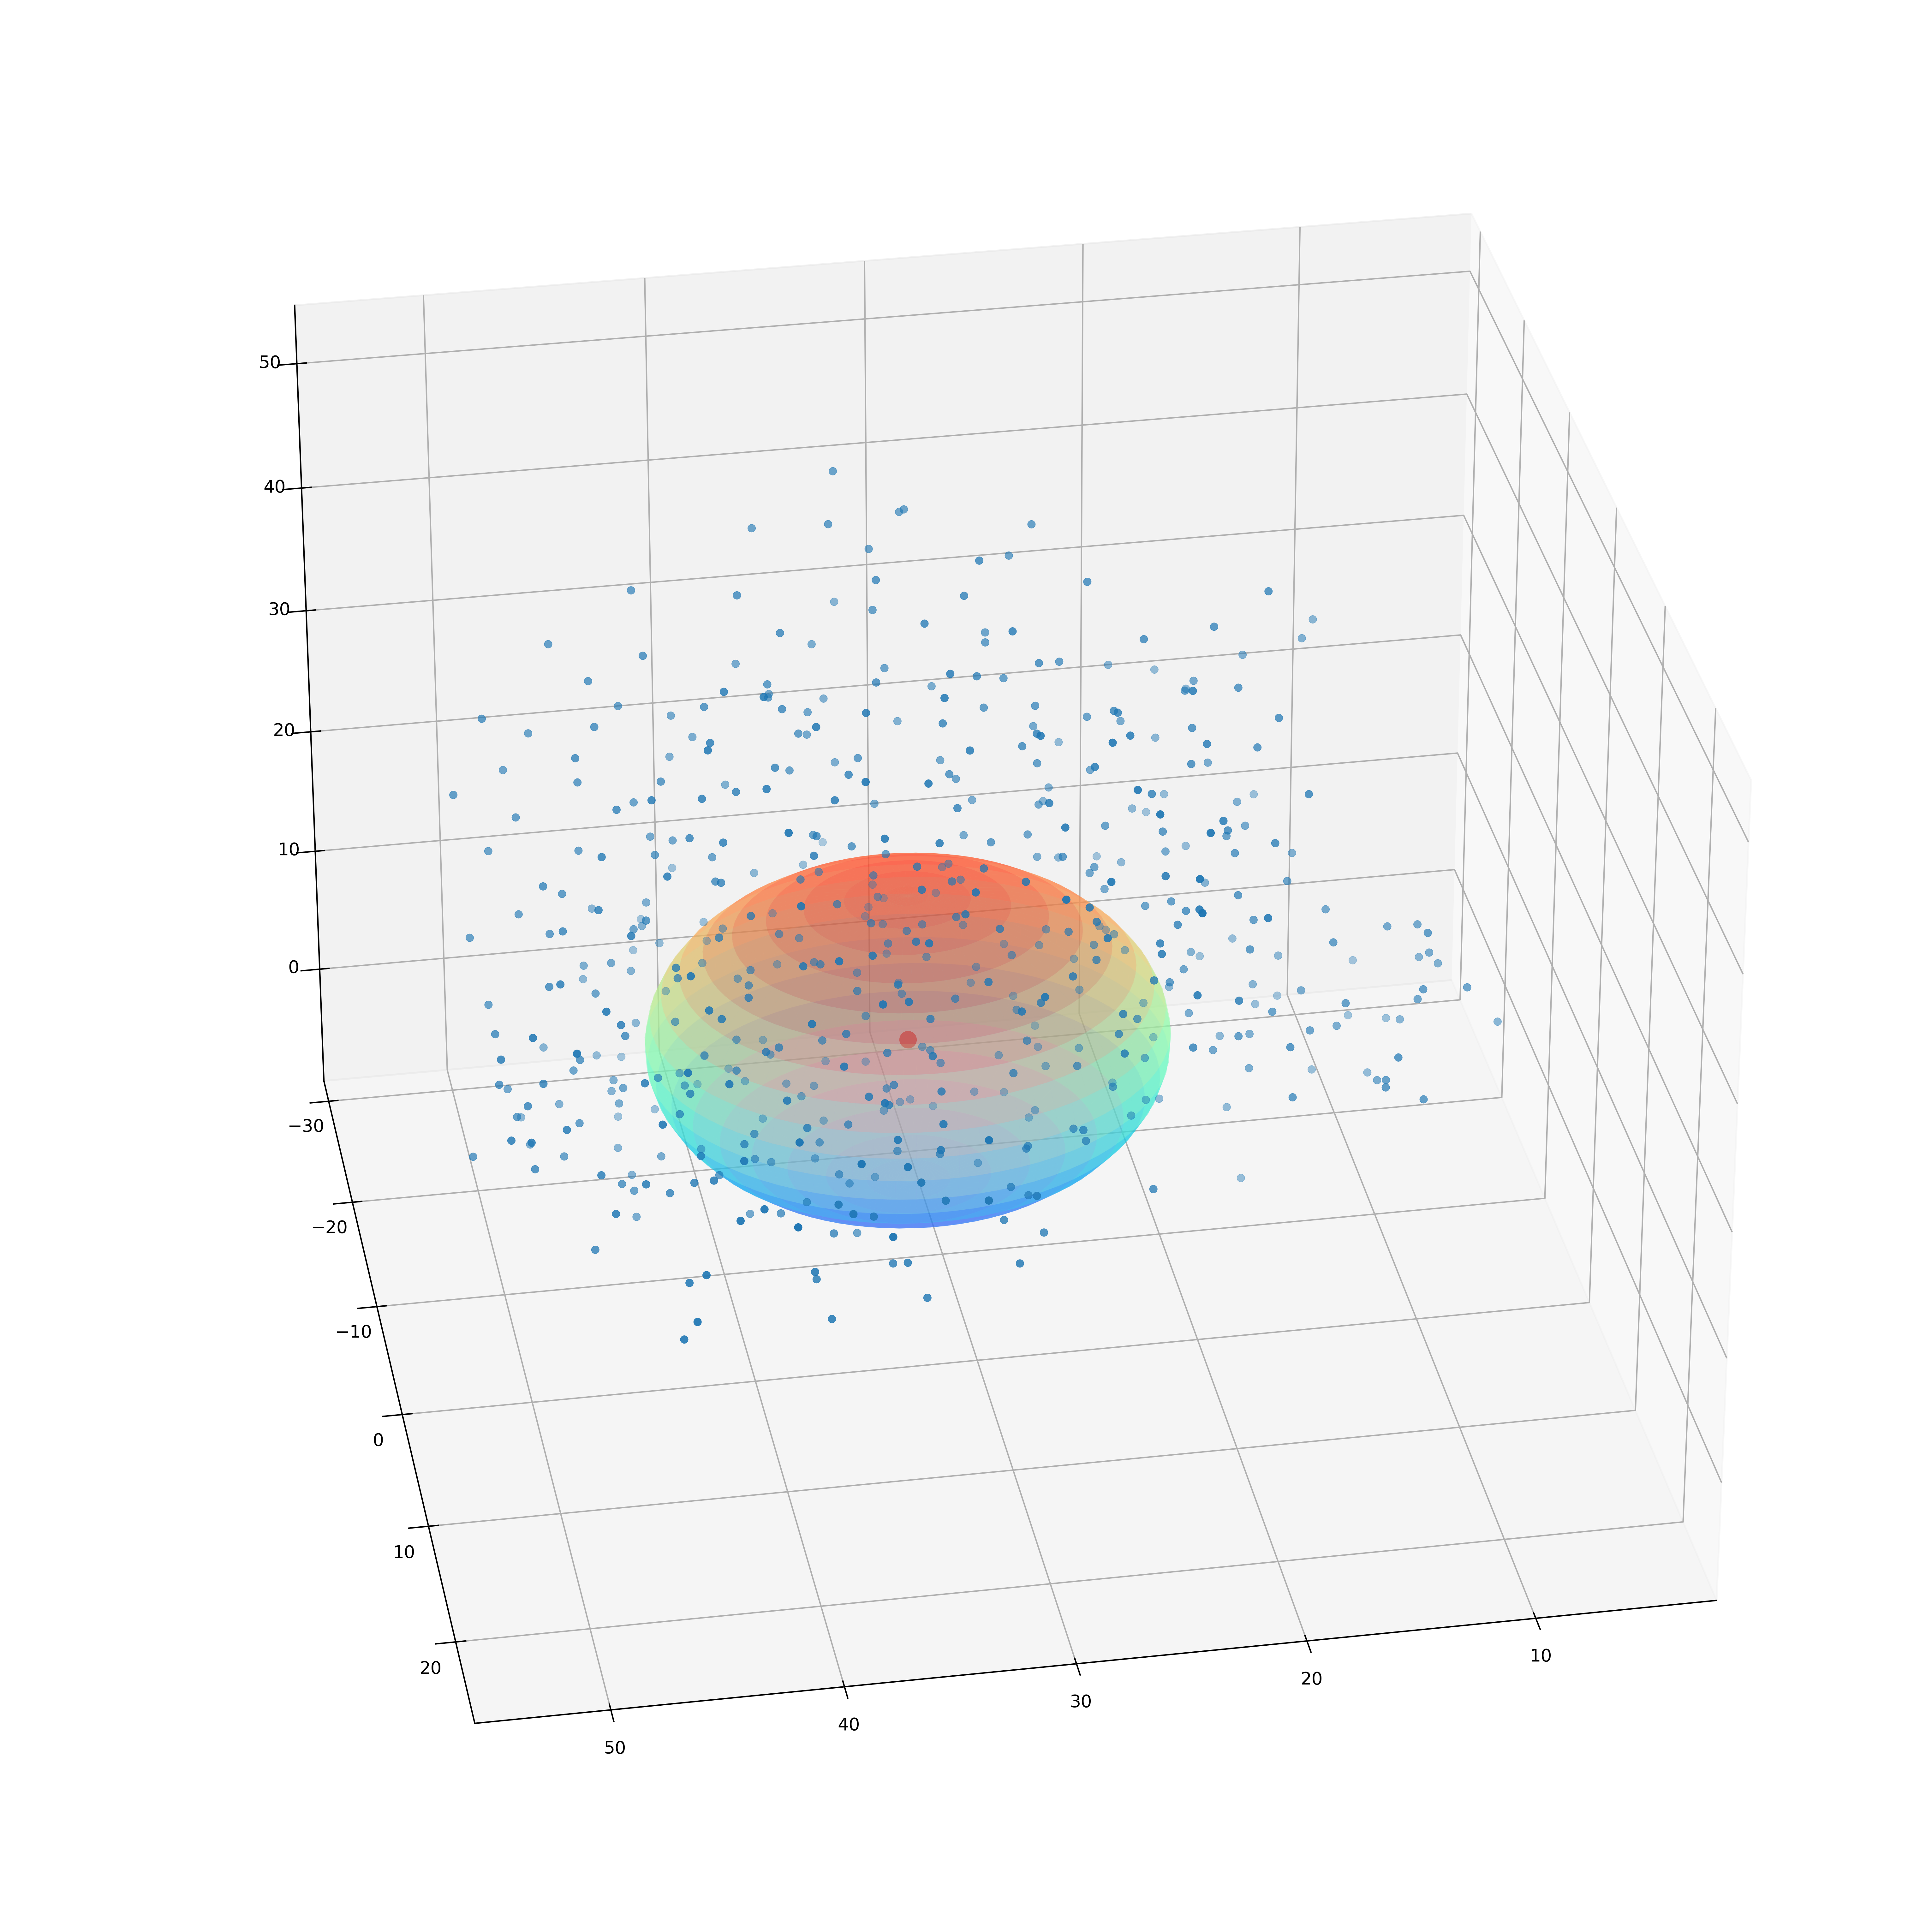

In [27]:
#pdb_name = "4bb9_ligand_2.pdb"
pdb_name = "6b98_ligand_3.pdb"
pdb_data = []                        #一个pdb文件中的信息汇总
pdb_plot_data = []
# [element_name, protein_or_ligand, chain_id, x, y, z]
with open(negativePDBDir+pdb_name) as pdb_file:
    lines = pdb_file.readlines()
    flag = False
    for i, line in enumerate(lines):
        if (line[:4]=='ATOM' or line[:6]=='HETATM') and line[76:78].strip() in valid_elements:
            atom = ['C', 0, 'A', 0.0, 0.0, 0.0]#0代表蛋白质分子。 1代表ligand分子
            atom[0] = line[76:78].strip()                   #element_name
            atom[1] = 0 if line[:4]=='ATOM' else 1  #protein or ligand
            if (i > 0 and int(line[6:11]) < int(lines[i-1][6:11])) or flag:
                flag = True
                atom[1] = 1
            atom[2] = line[21]                      #chain_id
            atom[3] = float(line[30:38].strip())    #x
            atom[4] = float(line[38:46].strip())    #y
            atom[5] = float(line[46:54].strip())    #z
            pdb_data.append(atom)
            if i%5 == 0:
                pdb_plot_data.append([atom[3], atom[4], atom[5]])
ligandBox = ligandCenter(pdb_data)
minX, minY, minZ, maxX, maxY, maxZ = ligandBox
centerX, centerY, centerZ = (minX+maxX)/2, (minY+maxY)/2, (minZ+maxZ)/2
disMin = math.sqrt((centerX-minX)**2+(centerY-minY)**2+(centerZ-minZ)**2)
disMax = math.sqrt((centerX-maxX)**2+(centerY-maxY)**2+(centerZ-maxZ)**2)
radius = disMin if disMin > disMax else disMax

pdb_plot_data = np.array(pdb_plot_data)
pdb_x = np.array(pdb_plot_data[:, 0])
pdb_y = np.array(pdb_plot_data[:, 1])
pdb_z = np.array(pdb_plot_data[:, 2])
# print(pdb_data)
# print(ligandBox)
# eval_data = []
# for i in range(len(pdb_data)):
#     if fartherThan8A(ligandBox, [pdb_data[i][0], pdb_data[i][1], pdb_data[i][2]]):
#         continue
#     if i%10 == 0:
#         eval_data.append(pdb_data[i])

# eval_data = np.array(eval_data)
# eval_x = np.array(eval_data[:, 0])
# eval_y = np.array(eval_data[:, 1])
# eval_z = np.array(eval_data[:, 2])

fig = plt.figure(figsize=(20, 20), dpi=400)
ax = fig.gca(projection='3d')
ax.scatter(pdb_x, pdb_y, pdb_z, cmap=plt.cm.Spectral, linewidth=0.2)
ax.scatter(centerX, centerY, centerZ, c= 'r', s=80)
drawSphere(centerX, centerY, centerZ,radius+8,ax)

# 调整角度，第一个数字为上下，第二个数字为左右。
ax.view_init(30, 80)
plt.savefig('../figs/exclude8AAtoms.png', dpi=400)
plt.show()

In [36]:
f = open('/data/bilab/kaku/docking/5orh_ligand_3.pdbqt')
atom = []
for l in f.readlines():
    data = l.strip().split()
    if data[0] == 'ATOM':
        atom.append(data)
len(atom)

19